In [13]:
%load_ext autoreload
%load_ext tensorboard
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [14]:
import matplotlib
import numpy as np
import os
import random
import yaml
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import rc
from matplotlib import cm
import seaborn as sns
from importlib import reload
from pathlib import Path
import sklearn
import joblib
import torch
import pandas as pd
import copy

# Set the font to a nicer font
rc('text', usetex=True)
plt.style.use('seaborn-whitegrid')
plt.rcParams["font.family"] = "serif"

In [15]:
def get_metric_from_dict(results, method, metric):
    vals = []
    for _, metric_keys in results.items():
        for candidate_method, metric_map in metric_keys.items():
            if method != candidate_method:
                continue
            for metric_name, val in metric_map.items():
                if metric_name == metric:
                    vals.append(val)
    return vals


# Color and Marker Definitions

In [57]:
# Plot Hyperparameters
clrs = sns.color_palette("deep", 10)
color_map = {
    "Bayes MLP": "black",
    "Bayes Classifier": "black",
    "MixCEM (ours)": "red",
    "MixCEM (No Calibration)": "cyan",
    "MixCEM (no IntCEM loss)": "black",
    "MixCEM + IntCEM": "orange",
    "MixIntCEM (ours)": "orange",
    "IntCEM": "cyan",
}

baselines_to_include = [
    "Joint CBM",
    "Hybrid-CBM",
    "CEM",
    # "Sigmoidal CEM",
    "IntCEM",
    "ProbCBM",
    "Posthoc CBM",
    "Posthoc Hybrid CBM",
    "Entropy CMCMixCEM",
    "Bayes MLP",
]
for idx, baseline in enumerate(baselines_to_include):
    if baseline not in color_map:
        color_map[baseline] = clrs[idx]

markers = {
    "Joint CBM": '-o',
    "Vanilla CBM": '-o',
    "Hybrid-CBM": '-v',
    "Hybrid CBM": '-v',
    "CEM": '-^',
    "IntCEM": '-x',
    "ProbCBM": '-s',
    "Posthoc CBM": '-p',
    "P-CBM": '-p',
    "Posthoc Hybrid CBM": '-1',
    "Hybrid Posthoc CBM": '-1',
    "Hybrid P-CBM": '-1',
    "MixCEM (ours)": '--*',
    "MixCEM (No Calibration)": ':*',
    "MixCEM (no IntCEM loss)": ":*",
    "MixCEM + IntCEM": ":*",
    "MixIntCEM (ours)": ":*",
    "Bayes MLP": ":.",
    "Bayes Classifier": ":.",
}

max_limit = 10

select_metric = 'val_acc_y_random_group_level_True_use_prior_False_int_auc'

rename_map = {
    "Entropy CMCMixIntCEM": "MixIntCEM (ours)",
    "Entropy CMCMixCEM": "MixCEM (ours)",
    "Entropy CMCMixIntCEM No Calibration": "MixIntCEM (No Calibration)",
    "Entropy CMCMixCEM No Calibration": "MixCEM (No Calibration)",
    "Posthoc Hybrid CBM": "Residual P-CBM",
    "Hybrid Posthoc CBM": "Residual P-CBM",
    "Posthoc CBM": "P-CBM",
    "Bayes MLP": "Bayes Classifier",
    "Joint CBM": "Vanilla CBM",
    "Hybrid-CBM": "Hybrid CBM",
}
used_rename_map = rename_map
show_variance = True
ood_suffix = 'OOD_sap_0.1_'

# Abstract Figures

For dataset CUB (Complete) we selected
	DNN (Baseline): DNN_extra_dims_200
	Joint CBM (Baseline): CBM_Sigmoid_Baseline_cwl_10
	Joint Logit CBM (Baseline): CBM_Logit_Baseline_cwl_10
	Hybrid-CBM (Baseline): Hybrid-CBM_Sigmoid_extra_dims_50_Baseline_cwl_5
	CEM (Baseline): CEM_Baseline_cwl_1
	IntCEM (Baseline): IntCEM_emb_size_16_intervention_weight_1_intervention_task_discount_1.5_Baseline_cwl_1
	ProbCBM (Baseline): ProbCBM_cwl_class_hidden_dim_128_hidden_dim_32_n_samples_inference_50_max_concept_epochs_70_max_task_epochs_75
	Posthoc CBM (Baseline): PCBM_reg_1e-06_l1_0.99_penalty_1
	Posthoc Hybrid CBM (Baseline): HybridPCBM_reg_1e-06_l1_0.99_penalty_1
	Entropy CMCMixIntCEM No Calibration (Baseline): Entropy_CMCMixIntCEM_t_1_r_1_concat_None_0_mpc_1_tmc_1_emc_50_cwc_False_ce_0_g_ood_0.5_emb_16_True_tip_0.25_itd_1.1_iw_0.1_cwl_1
	Entropy CMCMixIntCEM (Baseline): Entropy_CMCMixIntCEM_t_1_r_1_concat_None_0_mpc_1_tmc_1_emc_50_cwc_False_ce_30_g_ood_0.1_emb_16_True_tip_0.25_itd_1.1_iw_0.1_cwl_1
	

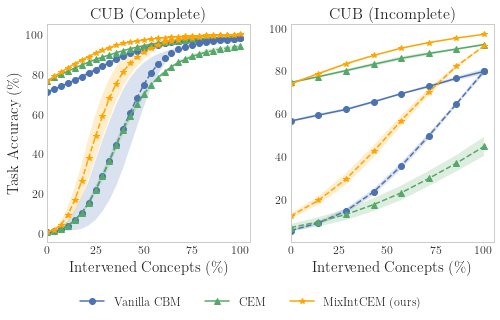

In [187]:
baselines_to_include = [
    "Joint CBM",
    "CEM",
    "Entropy CMCMixIntCEM",
]

fig, axs = plt.subplots(1, 2, figsize=(8, 4))
ax = axs[0]

results_to_use = dict(
    path='/anfs/bigdisc/me466/mixcem_results/cub_complete/',
    name='CUB (Complete)',
    rename={'Posthoc Hybrid CBM': 'Hybrid Posthoc CBM'},
)
results_to_use['results'] = joblib.load(
    os.path.join(results_to_use['path'], 'results.joblib')
)

results = results_to_use['results']
used_select_metric = results_to_use.get(
    'select_metric',
    select_metric,
)
results_to_use['selected_models'] = joblib.load(os.path.join(results_to_use['path'], f'selected_models_{used_select_metric}.joblib'))
print("For dataset", results_to_use['name'], "we selected")
for key, val in results_to_use['selected_models'].items():
    print(f"\t{key}: {val}")
selected_models = results_to_use['selected_models']
for row, (mode_name, mode_key) in enumerate([
    ("Baseline", " (Baseline)"),
    ("Baseline OOD", " (Baseline)"),
]):
    for idx, label in enumerate(baselines_to_include):
        label = results_to_use.get('remap', {}).get(label, label)
        model_name = selected_models.get(
            label + mode_key,
            label + mode_key,
        )
        ints = np.array(get_metric_from_dict(
            results,
            model_name,
            f"{'OOD_' if 'OOD' in mode_name else ''}test_acc_y_random_group_level_True_use_prior_False_ints",
        ))
        if len(ints) == 0:
            print("Skipping", model_name, "for", results_to_use['name'], "as we could not find any results...")
            continue
        label = rename_map.get(label, label)
        means = np.mean(ints, axis=0) * 100
        stds = np.std(ints, axis=0) * 100
        color = color_map.get(label, clrs[idx])
        marker = markers.get(label, "x" if "Mix" in label else "o")
        if "OOD" in mode_name:
            linestyle = '--'
        else:
            linestyle = '-'
        xticks = (
            [0] + list(100 * np.arange(1.0/(len(means) - 1), 1, 1.0/(len(means) - 1)))
        )
        ax.plot(
            xticks,
            means,
            marker[-1:],
            color=color,
            label=label,
            linestyle=linestyle,

        )
        # print(mode_name, label, "means =", means)
        if show_variance:
            ax.fill_between(
                xticks,
                means - stds,
                means + stds,
                alpha=0.2,
                facecolor=color,
            )
    ax.grid(False)
    ax.set_xlim(0, 105)
    ax.set_ylabel("Task Accuracy (\%)", fontsize=15)
    ax.set_xlabel("Intervened Concepts (\%)", fontsize=15)
    ax.xaxis.set_tick_params(labelsize=12)
    ax.yaxis.set_tick_params(labelsize=12)
    ax.set_title(results_to_use['name'], fontsize=16)
    handles, labels = ax.get_legend_handles_labels()



results_to_use = dict(
    path='/anfs/bigdisc/me466/mixcem_results/cub_incomplete/',
    name='CUB (Incomplete)',
    rename={'Posthoc Hybrid CBM': 'Hybrid Posthoc CBM'},
)
results_to_use['results'] = joblib.load(
    os.path.join(results_to_use['path'], 'results.joblib')
)



ax = axs[1]
results = results_to_use['results']
used_select_metric = results_to_use.get(
    'select_metric',
    select_metric,
)
results_to_use['selected_models'] = joblib.load(os.path.join(results_to_use['path'], f'selected_models_{used_select_metric}.joblib'))
print("For dataset", results_to_use['name'], "we selected")
for key, val in results_to_use['selected_models'].items():
    print(f"\t{key}: {val}")
selected_models = results_to_use['selected_models']
for row, (mode_name, mode_key) in enumerate([
    ("Baseline", " (Baseline)"),
    ("Baseline OOD", " (Baseline)"),
]):
    for idx, label in enumerate(baselines_to_include):
        label = results_to_use.get('remap', {}).get(label, label)
        model_name = selected_models.get(
            label + mode_key,
            label + mode_key,
        )
        ints = np.array(get_metric_from_dict(
            results,
            model_name,
            f"{'OOD_sap_0.1_' if 'OOD' in mode_name else ''}test_acc_y_random_group_level_True_use_prior_False_ints",
        ))
        if len(ints) == 0:
            print("Skipping", model_name, "for", results_to_use['name'], "as we could not find any results...")
            continue
        label = rename_map.get(label, label)
        means = np.mean(ints, axis=0) * 100
        stds = np.std(ints, axis=0) * 100
        color = color_map.get(label, clrs[idx])
        marker = markers.get(label, "x" if "Mix" in label else "o")
        if "OOD" in mode_name:
            linestyle = '--'
        else:
            linestyle = '-'
        xticks = (
            [0] + list(100 * np.arange(1.0/(len(means) - 1), 1, 1.0/(len(means) - 1)))
        )
        print("len(means) =", len(means))
        print("xticks =", xticks)
        ax.plot(
            xticks,
            means,
            marker[-1:],
            color=color,
            label=label,
            linestyle=linestyle,

        )
        # print(mode_name, label, "means =", means)
        if show_variance:
            ax.fill_between(
                xticks,
                means - stds,
                means + stds,
                alpha=0.2,
                facecolor=color,
            )
    ax.set_xlim(0, 105)
    ax.set_ylabel("", fontsize=15)
    ax.set_xlabel("Intervened Concepts (\%)", fontsize=15)
    ax.xaxis.set_tick_params(labelsize=12)
    ax.yaxis.set_tick_params(labelsize=12)
    ax.grid(False)
    ax.set_title(results_to_use['name'], fontsize=16)
    handles, labels = ax.get_legend_handles_labels()

ax.legend(
    handles[:len(baselines_to_include)],
    labels[:len(baselines_to_include)],
    fontsize=12,
    loc='upper center',
    bbox_to_anchor=(-0.2,-0.2),
    ncol=len(baselines_to_include),
)
plt.savefig(f"../figures/abstract_interventions_complete_{'_variance' if show_variance else ''}.pdf", bbox_inches='tight')
plt.savefig(f"../figures/abstract_interventions_complete_{'_variance' if show_variance else ''}.png", bbox_inches='tight')
plt.show()

For dataset CUB (Incomplete) we selected
	DNN (Baseline): DNN_extra_dims_200
	Joint CBM (Baseline): CBM_Sigmoid_Baseline_cwl_1
	Hybrid-CBM (Baseline): Hybrid-CBM_Sigmoid_extra_dims_50_Baseline_cwl_1
	CEM (Baseline): CEM_Baseline_cwl_1
	IntCEM (Baseline): IntCEM_emb_size_16_intervention_weight_1_intervention_task_discount_1.1_Baseline_cwl_1
	ProbCBM (Baseline): ProbCBM_cwl_class_hidden_dim_64_hidden_dim_16_n_samples_inference_50_max_concept_epochs_70_max_task_epochs_75
	Posthoc CBM (Baseline): PCBM_reg_0.001_l1_0.99_penalty_1
	Hybrid Posthoc CBM (Baseline): HybridPCBM_reg_0.1_l1_0.99_penalty_1
	Entropy CMCMixIntCEM No Calibration (Baseline): Entropy_CMCMixIntCEM_t_1_r_1_concat_None_0_mpc_1_tmc_1_emc_50_cwc_False_ce_0_g_ood_0.1_emb_16_True_tip_0.25_itd_1.1_iw_0.1_cwl_1
	Entropy CMCMixIntCEM (Baseline): Entropy_CMCMixIntCEM_t_1_r_1_concat_None_0_mpc_1_tmc_1_emc_50_cwc_False_ce_30_g_ood_0.1_emb_16_True_tip_0.25_itd_1.1_iw_0.1_cwl_1
	Entropy CMCMixCEM No Calibration (Baseline): Entropy_CMCM

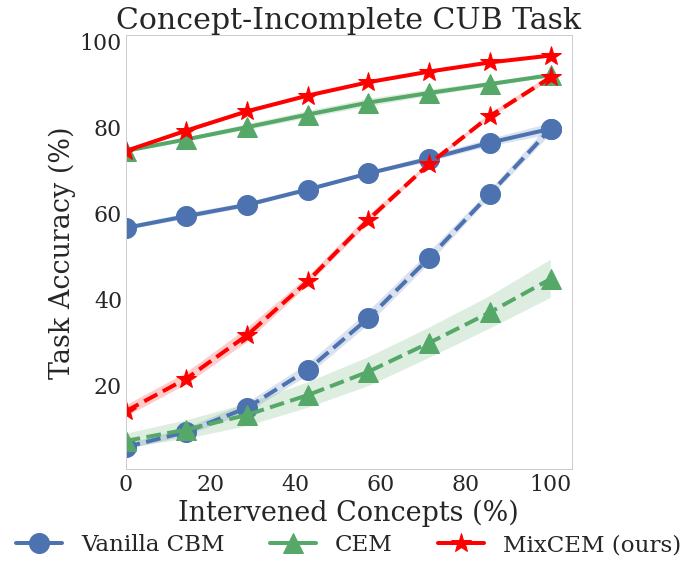

In [188]:
rc('text', usetex=False) # For quality, let's temporarily disable this
baselines_to_include = [
    "Joint CBM",
    "CEM",
    # "ProbCBM",
    "Entropy CMCMixCEM",
]

fig, ax = plt.subplots(figsize=(8, 8))

results_to_use = dict(
    path='/anfs/bigdisc/me466/mixcem_results/cub_incomplete/',
    name='CUB (Incomplete)',
    rename={'Posthoc Hybrid CBM': 'Hybrid Posthoc CBM'},
)
results_to_use['results'] = joblib.load(
    os.path.join(results_to_use['path'], 'results.joblib')
)

results = results_to_use['results']
used_select_metric = results_to_use.get(
    'select_metric',
    select_metric,
)
results_to_use['selected_models'] = joblib.load(os.path.join(results_to_use['path'], f'selected_models_{used_select_metric}.joblib'))
print("For dataset", results_to_use['name'], "we selected")
for key, val in results_to_use['selected_models'].items():
    print(f"\t{key}: {val}")
selected_models = results_to_use['selected_models']
for row, (mode_name, mode_key) in enumerate([
    ("Baseline", " (Baseline)"),
    ("Baseline OOD", " (Baseline)"),
]):
    for idx, label in enumerate(baselines_to_include):
        label = results_to_use.get('remap', {}).get(label, label)
        model_name = selected_models.get(
            label + mode_key,
            label + mode_key,
        )
        ints = np.array(get_metric_from_dict(
            results,
            model_name,
            f"{'OOD_sap_0.1_' if 'OOD' in mode_name else ''}test_acc_y_random_group_level_True_use_prior_False_ints",
        ))
        if len(ints) == 0:
            print("Skipping", model_name, "for", results_to_use['name'], "as we could not find any results...")
            continue
        label = rename_map.get(label, label)
        means = np.mean(ints, axis=0) * 100
        stds = np.std(ints, axis=0) * 100
        color = color_map.get(label, clrs[idx])
        marker = markers.get(label, "x" if "Mix" in label else "o")
        if "OOD" in mode_name:
            # label += " (OOD Sample)"
            linestyle = '--'
        else:
            # label += " (ID Sample)"
            linestyle = '-'
        xticks = (
            [0] + list(100 * np.arange(1.0/(len(means) - 1), 1, 1.0/(len(means) - 1)))
        )
        ax.plot(
            xticks,
            means,
            marker[-1:],
            color=color,
            label=label,
            linestyle=linestyle,
            markersize=20,
            linewidth=4,
        )
        # print(mode_name, label, "means =", means)
        if show_variance:
            ax.fill_between(
                xticks,
                means - stds,
                means + stds,
                alpha=0.2,
                facecolor=color,
            )
    ax.set_xlim(0, 105)
    ax.set_ylabel("Task Accuracy (%)", fontsize=15+15 + -3)
    ax.set_xlabel("Intervened Concepts (%)", fontsize=15+15 + -3)
    ax.xaxis.set_tick_params(labelsize=12 + 13 + -3)
    ax.yaxis.set_tick_params(labelsize=12 + 13 + -3)
    ax.set_title('Concept-Incomplete CUB Task', fontsize=30)
    ax.grid(False)
    handles, labels = ax.get_legend_handles_labels()



results_to_use = dict(
    path='/anfs/bigdisc/me466/mixcem_results/cub_incomplete/',
    name='CUB (Incomplete)',
    rename={'Posthoc Hybrid CBM': 'Hybrid Posthoc CBM'},
)
results_to_use['results'] = joblib.load(
    os.path.join(results_to_use['path'], 'results.joblib')
)
ax.legend(
    handles[:len(baselines_to_include)],
    labels[:len(baselines_to_include)],
    fontsize=15+8,
    loc='upper center',
    bbox_to_anchor=(0.5,-0.1),
    ncol=len(baselines_to_include),
)
plt.savefig(f"../figures/abstract_interventions{'_variance' if show_variance else ''}.pdf", bbox_inches='tight')
plt.savefig(f"../figures/abstract_interventions{'_variance' if show_variance else ''}.png", bbox_inches='tight')
plt.show()
rc('text', usetex=True)


For dataset CUB (Incomplete) we selected
	DNN (Baseline): DNN_extra_dims_200
	Joint CBM (Baseline): CBM_Sigmoid_Baseline_cwl_1
	Hybrid-CBM (Baseline): Hybrid-CBM_Sigmoid_extra_dims_50_Baseline_cwl_1
	CEM (Baseline): CEM_Baseline_cwl_1
	IntCEM (Baseline): IntCEM_emb_size_16_intervention_weight_1_intervention_task_discount_1.1_Baseline_cwl_1
	ProbCBM (Baseline): ProbCBM_cwl_class_hidden_dim_64_hidden_dim_16_n_samples_inference_50_max_concept_epochs_70_max_task_epochs_75
	Posthoc CBM (Baseline): PCBM_reg_0.001_l1_0.99_penalty_1
	Hybrid Posthoc CBM (Baseline): HybridPCBM_reg_0.1_l1_0.99_penalty_1
	Entropy CMCMixIntCEM No Calibration (Baseline): Entropy_CMCMixIntCEM_t_1_r_1_concat_None_0_mpc_1_tmc_1_emc_50_cwc_False_ce_0_g_ood_0.1_emb_16_True_tip_0.25_itd_1.1_iw_0.1_cwl_1
	Entropy CMCMixIntCEM (Baseline): Entropy_CMCMixIntCEM_t_1_r_1_concat_None_0_mpc_1_tmc_1_emc_50_cwc_False_ce_30_g_ood_0.1_emb_16_True_tip_0.25_itd_1.1_iw_0.1_cwl_1
	Entropy CMCMixCEM No Calibration (Baseline): Entropy_CMCM

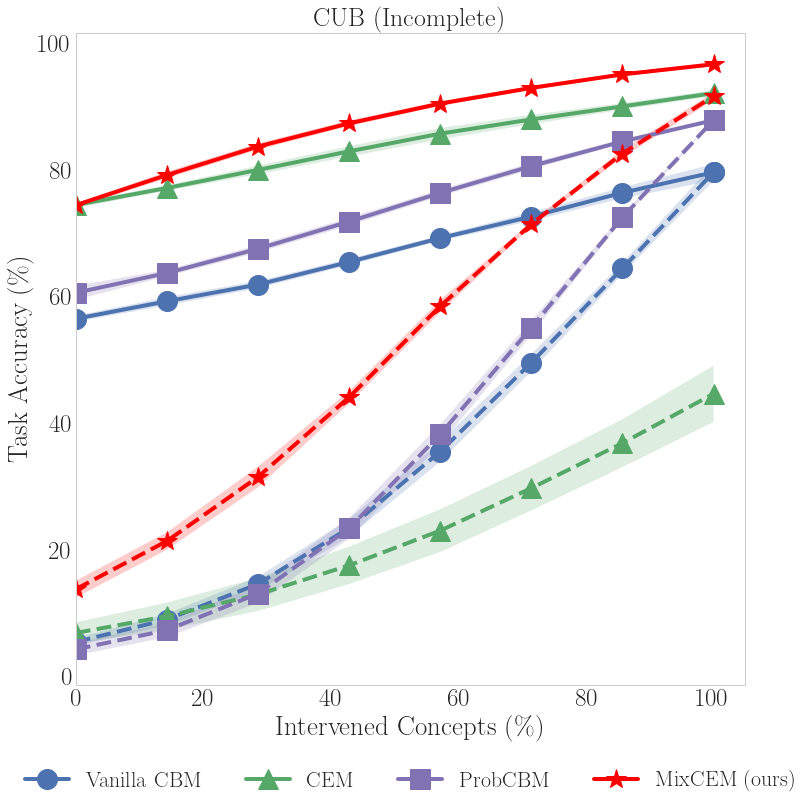

In [189]:
baselines_to_include = [
    "Joint CBM",
    "CEM",
    "ProbCBM",
    "Entropy CMCMixCEM",
]


fig, ax = plt.subplots(figsize=(12, 12))

results_to_use = dict(
    path='/anfs/bigdisc/me466/mixcem_results/cub_incomplete/',
    name='CUB (Incomplete)',
    rename={'Posthoc Hybrid CBM': 'Hybrid Posthoc CBM'},
)
results_to_use['results'] = joblib.load(
    os.path.join(results_to_use['path'], 'results.joblib')
)

results = results_to_use['results']
used_select_metric = results_to_use.get(
    'select_metric',
    select_metric,
)
results_to_use['selected_models'] = joblib.load(os.path.join(results_to_use['path'], f'selected_models_{used_select_metric}.joblib'))
print("For dataset", results_to_use['name'], "we selected")
for key, val in results_to_use['selected_models'].items():
    print(f"\t{key}: {val}")
selected_models = results_to_use['selected_models']
for row, (mode_name, mode_key) in enumerate([
    ("Baseline", " (Baseline)"),
    ("Baseline OOD", " (Baseline)"),
]):
    for idx, label in enumerate(baselines_to_include):
        label = results_to_use.get('remap', {}).get(label, label)
        model_name = selected_models.get(
            label + mode_key,
            label + mode_key,
        )
        ints = np.array(get_metric_from_dict(
            results,
            model_name,
            f"{'OOD_sap_0.1_' if 'OOD' in mode_name else ''}test_acc_y_random_group_level_True_use_prior_False_ints",
        ))
        if len(ints) == 0:
            print("Skipping", model_name, "for", results_to_use['name'], "as we could not find any results...")
            continue
        label = rename_map.get(label, label)
        means = np.mean(ints, axis=0) * 100
        stds = np.std(ints, axis=0) * 100
        color = color_map.get(label, clrs[idx])
        marker = markers.get(label, "x" if "Mix" in label else "o")
        if "OOD" in mode_name:
            linestyle = '--'
        else:
            linestyle = '-'
        xticks = (
            [0] + list(100 * np.arange(1.0/(len(means) - 1), 1, 1.0/(len(means) - 1)))
        )
        ax.plot(
            xticks,
            means,
            marker[-1:],
            color=color,
            label=label,
            linestyle=linestyle,
            markersize=20,
            linewidth=4,
        )
        # print(mode_name, label, "means =", means)
        if show_variance:
            ax.fill_between(
                xticks,
                means - stds,
                means + stds,
                alpha=0.2,
                facecolor=color,
            )
    ax.set_xlim(0, 105)
    ax.set_ylabel("Task Accuracy (\%)", fontsize=12+15)
    ax.set_xlabel("Intervened Concepts (\%)", fontsize=12+15)
    ax.xaxis.set_tick_params(labelsize=12+13)
    ax.yaxis.set_tick_params(labelsize=12+13)
    ax.set_title(results_to_use['name'], fontsize=10+16)
    ax.grid(False)
    handles, labels = ax.get_legend_handles_labels()



results_to_use = dict(
    path='/anfs/bigdisc/me466/mixcem_results/cub_incomplete/',
    name='CUB (Incomplete)',
    rename={'Posthoc Hybrid CBM': 'Hybrid Posthoc CBM'},
)
results_to_use['results'] = joblib.load(
    os.path.join(results_to_use['path'], 'results.joblib')
)
ax.legend(
    handles[:len(baselines_to_include)],
    labels[:len(baselines_to_include)],
    fontsize=10+12,
    loc='upper center',
    bbox_to_anchor=(0.5,-0.1),
    ncol=len(baselines_to_include),
)
plt.savefig(f"../figures/abstract_interventions_all{'_variance' if show_variance else ''}.pdf", bbox_inches='tight')
plt.savefig(f"../figures/abstract_interventions_all{'_variance' if show_variance else ''}.png", bbox_inches='tight')
plt.show()

For dataset CUB (Incomplete) we selected
	DNN (Baseline): DNN_extra_dims_200
	Joint CBM (Baseline): CBM_Sigmoid_Baseline_cwl_1
	Hybrid-CBM (Baseline): Hybrid-CBM_Sigmoid_extra_dims_50_Baseline_cwl_1
	CEM (Baseline): CEM_Baseline_cwl_1
	IntCEM (Baseline): IntCEM_emb_size_16_intervention_weight_1_intervention_task_discount_1.1_Baseline_cwl_1
	ProbCBM (Baseline): ProbCBM_cwl_class_hidden_dim_64_hidden_dim_16_n_samples_inference_50_max_concept_epochs_70_max_task_epochs_75
	Posthoc CBM (Baseline): PCBM_reg_0.001_l1_0.99_penalty_1
	Hybrid Posthoc CBM (Baseline): HybridPCBM_reg_0.1_l1_0.99_penalty_1
	Entropy CMCMixIntCEM No Calibration (Baseline): Entropy_CMCMixIntCEM_t_1_r_1_concat_None_0_mpc_1_tmc_1_emc_50_cwc_False_ce_0_g_ood_0.1_emb_16_True_tip_0.25_itd_1.1_iw_0.1_cwl_1
	Entropy CMCMixIntCEM (Baseline): Entropy_CMCMixIntCEM_t_1_r_1_concat_None_0_mpc_1_tmc_1_emc_50_cwc_False_ce_30_g_ood_0.1_emb_16_True_tip_0.25_itd_1.1_iw_0.1_cwl_1
	Entropy CMCMixCEM No Calibration (Baseline): Entropy_CMCM

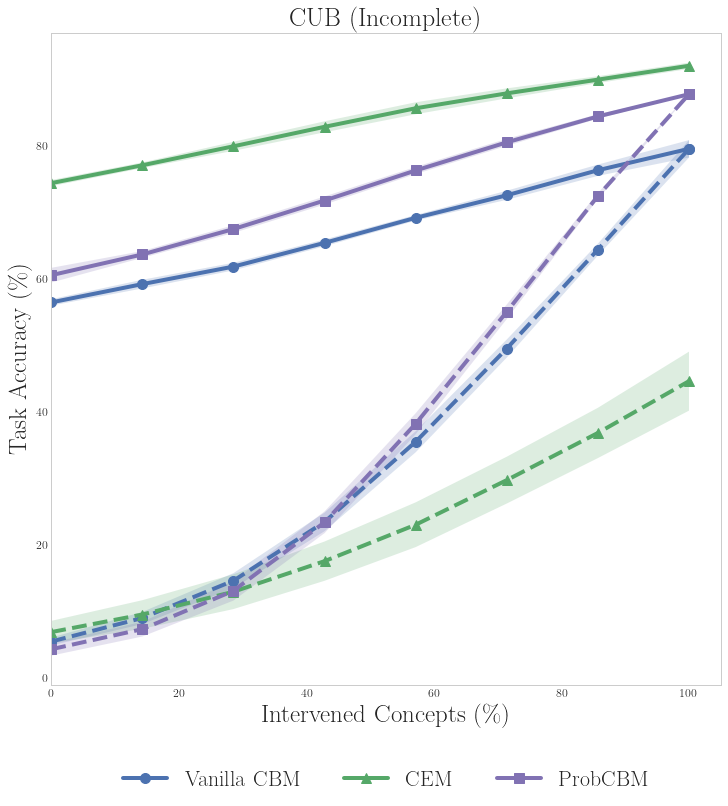

In [190]:
baselines_to_include = [
    "Joint CBM",
    "CEM",
    "ProbCBM",
    # "Entropy CMCMixCEM",
]

fig, ax = plt.subplots(figsize=(12, 12))

results_to_use = dict(
    path='/anfs/bigdisc/me466/mixcem_results/cub_incomplete/',
    name='CUB (Incomplete)',
    rename={'Posthoc Hybrid CBM': 'Hybrid Posthoc CBM'},
)
results_to_use['results'] = joblib.load(
    os.path.join(results_to_use['path'], 'results.joblib')
)

results = results_to_use['results']
used_select_metric = results_to_use.get(
    'select_metric',
    select_metric,
)
results_to_use['selected_models'] = joblib.load(os.path.join(results_to_use['path'], f'selected_models_{used_select_metric}.joblib'))
print("For dataset", results_to_use['name'], "we selected")
for key, val in results_to_use['selected_models'].items():
    print(f"\t{key}: {val}")
selected_models = results_to_use['selected_models']
for row, (mode_name, mode_key) in enumerate([
    ("Baseline", " (Baseline)"),
    ("Baseline OOD", " (Baseline)"),
]):
    for idx, label in enumerate(baselines_to_include):
        label = results_to_use.get('remap', {}).get(label, label)
        model_name = selected_models.get(
            label + mode_key,
            label + mode_key,
        )
        ints = np.array(get_metric_from_dict(
            results,
            model_name,
            f"{'OOD_sap_0.1_' if 'OOD' in mode_name else ''}test_acc_y_random_group_level_True_use_prior_False_ints",
        ))
        if len(ints) == 0:
            print("Skipping", model_name, "for", results_to_use['name'], "as we could not find any results...")
            continue
        label = rename_map.get(label, label)
        means = np.mean(ints, axis=0) * 100
        stds = np.std(ints, axis=0) * 100
        color = color_map.get(label, clrs[idx])
        marker = markers.get(label, "x" if "Mix" in label else "o")
        if "OOD" in mode_name:
            linestyle = '--'
        else:
            linestyle = '-'
        xticks = (
            [0] + list(100 * np.arange(1.0/(len(means) - 1), 1, 1.0/(len(means) - 1)))
        )
        ax.plot(
            xticks,
            means,
            marker[-1:],
            color=color,
            label=label,
            linestyle=linestyle,
            markersize=10,
            linewidth=4,
        )
        # print(mode_name, label, "means =", means)
        if show_variance:
            ax.fill_between(
                xticks,
                means - stds,
                means + stds,
                alpha=0.2,
                facecolor=color,
            )
    ax.set_xlim(0, 105)
    ax.set_ylabel("Task Accuracy (\%)", fontsize=10+15)
    ax.set_xlabel("Intervened Concepts (\%)", fontsize=10+15)
    ax.xaxis.set_tick_params(labelsize=12)
    ax.yaxis.set_tick_params(labelsize=12)
    ax.grid(False)
    ax.set_title(results_to_use['name'], fontsize=10+16)
    handles, labels = ax.get_legend_handles_labels()



results_to_use = dict(
    path='/anfs/bigdisc/me466/mixcem_results/cub_incomplete/',
    name='CUB (Incomplete)',
    rename={'Posthoc Hybrid CBM': 'Hybrid Posthoc CBM'},
)
results_to_use['results'] = joblib.load(
    os.path.join(results_to_use['path'], 'results.joblib')
)
ax.legend(
    handles[:len(baselines_to_include)],
    labels[:len(baselines_to_include)],
    fontsize=10+12,
    loc='upper center',
    bbox_to_anchor=(0.5,-0.1),
    ncol=len(baselines_to_include),
)
plt.savefig(f"../figures/abstract_interventions_probcbm{'_variance' if show_variance else ''}.pdf", bbox_inches='tight')
plt.savefig(f"../figures/abstract_interventions_probcbm{'_variance' if show_variance else ''}.png", bbox_inches='tight')
plt.show()

# Latex Tables

### Task Acc Alone

In [4]:
from texttable import Texttable
import latextable
from collections import defaultdict

num_stds = 1

results_to_include = [
    dict(
        path='/anfs/bigdisc/me466/mixcem_results/cub_complete/',
        name='\\texttt{CUB}',
    ),
    dict(
        path='/anfs/bigdisc/me466/mixcem_results/cub_incomplete/',
        name='\\texttt{CUB-Incomplete}',
        rename={'Posthoc Hybrid CBM': 'Hybrid Posthoc CBM'},
    ),
    dict(
        path='/anfs/bigdisc/me466/mixcem_results/celeba/',
        name='\\texttt{CelebA}',
    ),
    dict(
        path='/anfs/bigdisc/me466/mixcem_results/awa2_complete/',
        name='\\texttt{AwA2}',
    ),
    dict(
        path='/anfs/bigdisc/me466/mixcem_results/awa2_incomplete/',
        name='\\texttt{AwA2-Incomplete}',
    ),
]
for res in results_to_include:
    print(res['name'])
    res['results'] = joblib.load(os.path.join(res['path'], 'results.joblib'))

latex_table = Texttable()
baselines_to_include = [
    "DNN",
    "Joint CBM",
    "Hybrid-CBM",
    # "Sigmoidal CEM",
    "ProbCBM",
    "Posthoc CBM",
    "Posthoc Hybrid CBM",
    "CEM",
    "IntCEM",
    # "Entropy CMCMixCEM",
    "Entropy CMCMixIntCEM",
]
rename_map = {
    "Entropy CMCMixIntCEM": "MixCEM (ours)", #"MixIntCEM",
    "DNN": "DNN (Black Box)", #"MixIntCEM",
    # "Entropy CMCMixCEM": "MixCEM",
    "Posthoc Hybrid CBM": "Residual P-CBM",
    "Hybrid Posthoc CBM": "Residual P-CBM",
    "Posthoc CBM": "P-CBM",
    "Bayes MLP": "Bayes Lower Bound",
    "Joint CBM": "Vanilla CBM",
    "Hybrid-CBM": "Hybrid CBM",
}
metric = 'test_acc_y'
select_metric = 'val_acc_y_random_group_level_True_use_prior_False_int_auc'
cols = ["Method"] + [x['name'] for x in results_to_include]
rows = []
best_col_results = defaultdict(lambda: (-float("inf"), None))
col_results =  defaultdict(list)
for idx, label in enumerate(baselines_to_include):
    new_row = []
    for col, dataset_results in enumerate(results_to_include):
        real_label = dataset_results.get('rename', {}).get(label, label)
        used_select_metric = dataset_results.get(
            'select_metric',
            select_metric,
        )
        dataset_results['selected_models'] = joblib.load(os.path.join(dataset_results['path'], f'selected_models_{used_select_metric}.joblib'))
        selected_models = dataset_results['selected_models']
        model_name = selected_models.get(
            real_label + " (Baseline)",
            real_label + " (Baseline)",
        )
        results = dataset_results['results']
        metric_val = np.array(get_metric_from_dict(
            results,
            model_name,
            metric,
        ))
        used_name = rename_map.get(label, label)
        if len(new_row) == 0:
            new_row.append(used_name)
        mean = np.mean(metric_val, axis=0) * 100
        std = np.std(metric_val, axis=0) * 100
        if mean > best_col_results[col][0]:
            best_col_results[col] = (mean, std)
        col_results[col].append((mean, std))
    rows.append(new_row)

for idx, label in enumerate(baselines_to_include):
    new_row = rows[idx]
    for col, dataset_results in enumerate(results_to_include):
        mean, std = col_results[col][idx]
        if mean + num_stds*std >= (best_col_results[col][0] - num_stds*best_col_results[col][1]):
            new_row.append("$\\mathbf{" + f"{mean:.2f}_{{\pm {std:.2f}}}" + "}$")
        else:
            new_row.append(f"${mean:.2f}_{{\pm {std:.2f}}}$")

latex_table.set_cols_align(["c" for _ in cols])
latex_table.set_cols_valign(["m" for _ in cols])
latex_table.add_rows([cols] + rows)
print('-- Example 1: Basic --')
print('Texttable Output:')
print(latex_table.draw())
print('\nLatextable Output:')
print(
    latextable.draw_latex(
        latex_table,
        caption=(
            "Task and concept fidelities."
        ),
        caption_above=True,
        label="tab:task_accuracy_summary",
        position="ht",
        use_booktabs=True,
))


\texttt{CUB}
\texttt{CUB-Incomplete}
\texttt{CelebA}
\texttt{AwA2}
\texttt{AwA2-Incomplete}
-- Example 1: Basic --
Texttable Output:
+-------------+------------+------------+------------+------------+------------+
|   Method    | \texttt{CU | \texttt{CU | \texttt{Ce | \texttt{Aw | \texttt{Aw |
|             |     B}     | B-Incomple |   lebA}    |    A2}     | A2-Incompl |
|             |            |    te}     |            |            |    ete}    |
+=============+============+============+============+============+============+
| DNN (Black  | $71.18_{\p | $71.42_{\p | $25.39_{\p | $89.20_{\p | $89.33_{\p |
|    Box)     |  m 0.67}$  |  m 0.30}$  |  m 0.49}$  |  m 0.26}$  |  m 0.22}$  |
+-------------+------------+------------+------------+------------+------------+
| Vanilla CBM | $70.97_{\p | $56.46_{\p | $24.18_{\p | $87.52_{\p | $76.28_{\p |
|             |  m 0.76}$  |  m 0.48}$  |  m 0.65}$  |  m 0.41}$  |  m 0.82}$  |
+-------------+------------+------------+------------+---

### Task Acc and Concept AUC Combined

In [5]:
from texttable import Texttable
import latextable
from collections import defaultdict

results_to_include = [
    dict(
        path='/anfs/bigdisc/me466/mixcem_results/cub_complete/',
        name='\\texttt{CUB}',
    ),
    dict(
        path='/anfs/bigdisc/me466/mixcem_results/cub_incomplete/',
        name='\\texttt{CUB-Incomplete}',
        rename={'Posthoc Hybrid CBM': 'Hybrid Posthoc CBM'},
    ),
    dict(
        path='/anfs/bigdisc/me466/mixcem_results/celeba/',
        name='\\texttt{CelebA}',
    ),
    dict(
        path='/anfs/bigdisc/me466/mixcem_results/awa2_complete/',
        name='\\texttt{AwA2}',
    ),
    dict(
        path='/anfs/bigdisc/me466/mixcem_results/awa2_incomplete/',
        name='\\texttt{AwA2-Incomplete}',
    ),
]
for res in results_to_include:
    print(res['name'])
    res['results'] = joblib.load(os.path.join(res['path'], 'results.joblib'))

num_stds = 1

latex_table = Texttable()
baselines_to_include = [
    "DNN",
    "Joint CBM",
    "Hybrid-CBM",
    # "Sigmoidal CEM",
    "ProbCBM",
    "Posthoc CBM",
    "Posthoc Hybrid CBM",
    "CEM",
    "IntCEM",
    # "Entropy CMCMixCEM",
    "Entropy CMCMixIntCEM",
    "Entropy CMCMixIntCEM No Calibration",
]
rename_map = {
    "Entropy CMCMixIntCEM": "MixCEM (ours)",
    "Entropy CMCMixIntCEM No Calibration": "MixCEM (No Calibration) (ours)",
    "DNN": "DNN (Black Box)",
    "Posthoc Hybrid CBM": "Residual P-CBM",
    "Hybrid Posthoc CBM": "Residual P-CBM",
    "Posthoc CBM": "P-CBM",
    "Bayes MLP": "Bayes Lower Bound",
    "Joint CBM": "Vanilla CBM",
    "Hybrid-CBM": "Hybrid CBM",
}
select_metric = 'val_acc_y_random_group_level_True_use_prior_False_int_auc'
cols = ["Method"] + [x['name'] for x in results_to_include]
rows = []
metrics_to_include = [('test_acc_y', 'mediumred'), ('test_auc_c', 'mediumblue')]
col_results =  [defaultdict(list) for _ in metrics_to_include]
best_col_results = [defaultdict(lambda: (-float("inf"), None)) for _ in metrics_to_include]

for idx, label in enumerate(baselines_to_include):
    new_row = []
    for col, dataset_results in enumerate(results_to_include):
        real_label = dataset_results.get('rename', {}).get(label, label)
        used_select_metric = dataset_results.get(
            'select_metric',
            select_metric,
        )
        dataset_results['selected_models'] = joblib.load(os.path.join(dataset_results['path'], f'selected_models_{used_select_metric}.joblib'))
        selected_models = dataset_results['selected_models']
        model_name = selected_models.get(
            real_label + " (Baseline)",
            real_label + " (Baseline)",
        )
        results = dataset_results['results']
        metric_vals = []
        for metric_idx, (metric, color) in enumerate(metrics_to_include):
            metric_val = np.array(get_metric_from_dict(
                results,
                model_name,
                metric,
            ))
            used_name = rename_map.get(label, label)
            if len(new_row) == 0:
                new_row.append(used_name)
            mean = np.mean(metric_val, axis=0) * 100
            std = np.std(metric_val, axis=0) * 100
            if mean > best_col_results[metric_idx][col][0]:
                best_col_results[metric_idx][col] = (mean, std)
            col_results[metric_idx][col].append((mean, std))
    rows.append(new_row)

for idx, label in enumerate(baselines_to_include):
    new_row = rows[idx]
    for col, dataset_results in enumerate(results_to_include):
        entry = '$'
        for metric_idx, (metric, color) in enumerate(metrics_to_include):
            mean, std = col_results[metric_idx][col][idx]
            if metric_idx:
                entry += " \; / \;"
            if "Black Box" in label and metric == "test_auc_c":
                # Then this is not applicable
                entry += " \\text{N/A \; \; \;} "
            if mean + num_stds*std >= (best_col_results[metric_idx][col][0] - num_stds*best_col_results[metric_idx][col][1]):
                entry += (f" \\textcolor{{{color}}}{{\\underline{{{mean:.2f}_{{\pm {std:.2f}}}}}}}")
            else:
                entry += (f" \\textcolor{{{color}}}{{{mean:.2f}_{{\pm {std:.2f}}}}}")
        new_row.append(entry + "$")

latex_table.set_cols_align(["c" for _ in cols])
latex_table.set_cols_valign(["m" for _ in cols])
latex_table.add_rows([cols] + rows)
print('-- Example 1: Basic --')
print('Texttable Output:')
print(latex_table.draw())
print('\nLatextable Output:')
print(
    latextable.draw_latex(
        latex_table,
        caption=(
            "Task and concept fidelities."
        ),
        caption_above=True,
        label="tab:task_accuracy_summary",
        position="ht",
        use_booktabs=True,
))


\texttt{CUB}
\texttt{CUB-Incomplete}
\texttt{CelebA}
\texttt{AwA2}
\texttt{AwA2-Incomplete}
-- Example 1: Basic --
Texttable Output:
+-------------+------------+------------+------------+------------+------------+
|   Method    | \texttt{CU | \texttt{CU | \texttt{Ce | \texttt{Aw | \texttt{Aw |
|             |     B}     | B-Incomple |   lebA}    |    A2}     | A2-Incompl |
|             |            |    te}     |            |            |    ete}    |
+=============+============+============+============+============+============+
|             | $ \textcol | $ \textcol | $ \textcol | $ \textcol | $ \textcol |
|             | or{mediumr | or{mediumr | or{mediumr | or{mediumr | or{mediumr |
|             | ed}{71.18_ | ed}{71.42_ | ed}{25.39_ | ed}{89.20_ | ed}{89.33_ |
|             |    {\pm    |    {\pm    |    {\pm    |    {\pm    |    {\pm    |
| DNN (Black  | 0.67}} \;  | 0.30}} \;  | 0.49}} \;  | 0.26}} \;  | 0.22}} \;  |
|    Box)     | / \; \text | / \; \text | / \; \text | / 

In [6]:
from texttable import Texttable
import latextable
from collections import defaultdict

results_to_include = [
    dict(
        path='/anfs/bigdisc/me466/mixcem_results/cub_complete/',
        name='\\texttt{CUB}',
    ),
    dict(
        path='/anfs/bigdisc/me466/mixcem_results/cub_incomplete/',
        name='\\texttt{CUB-Incomplete}',
        rename={'Posthoc Hybrid CBM': 'Hybrid Posthoc CBM'},
    ),
    dict(
        path='/anfs/bigdisc/me466/mixcem_results/celeba/',
        name='\\texttt{CelebA}',
    ),
    dict(
        path='/anfs/bigdisc/me466/mixcem_results/awa2_complete/',
        name='\\texttt{AwA2}',
    ),
    dict(
        path='/anfs/bigdisc/me466/mixcem_results/awa2_incomplete/',
        name='\\texttt{AwA2-Incomplete}',
    ),
    dict(
        path='/anfs/bigdisc/me466/mixcem_results/cifar10/',
        name='\\texttt{Cifar10}',
    ),
]
for res in results_to_include:
    print(res['name'])
    res['results'] = joblib.load(os.path.join(res['path'], 'results.joblib'))

latex_table = Texttable()
baselines_to_include = [
    "DNN",
    "Joint CBM",
    "Hybrid-CBM",
    # "Sigmoidal CEM",
    "ProbCBM",
    "Posthoc CBM",
    "Posthoc Hybrid CBM",
    "CEM",
    "IntCEM",
    # "Entropy CMCMixCEM",
    "Entropy CMCMixIntCEM",
]
rename_map = {
    "Entropy CMCMixIntCEM": "MixCEM (ours)", #"MixIntCEM",
    "DNN": "DNN (Black Box)", #"MixIntCEM",
    # "Entropy CMCMixCEM": "MixCEM",
    "Posthoc Hybrid CBM": "Residual P-CBM",
    "Hybrid Posthoc CBM": "Residual P-CBM",
    "Posthoc CBM": "P-CBM",
    "Bayes MLP": "Bayes Lower Bound",
    "Joint CBM": "Vanilla CBM",
    "Hybrid-CBM": "Hybrid CBM",
}
num_stds = 2
select_metric = 'val_acc_y_random_group_level_True_use_prior_False_int_auc'
cols = ["Method"] + [x['name'] for x in results_to_include]
rows = []
metrics_to_include = [('test_acc_y', 'mediumred'), ('test_auc_c', 'mediumblue')]
col_results =  [defaultdict(list) for _ in metrics_to_include]
best_col_results = [defaultdict(lambda: (-float("inf"), None)) for _ in metrics_to_include]

for idx, label in enumerate(baselines_to_include):
    new_row = []
    for col, dataset_results in enumerate(results_to_include):
        real_label = dataset_results.get('rename', {}).get(label, label)
        used_select_metric = dataset_results.get(
            'select_metric',
            select_metric,
        )
        dataset_results['selected_models'] = joblib.load(os.path.join(dataset_results['path'], f'selected_models_{used_select_metric}.joblib'))
        selected_models = dataset_results['selected_models']
        model_name = selected_models.get(
            real_label + " (Baseline)",
            real_label + " (Baseline)",
        )
        results = dataset_results['results']
        metric_vals = []
        for metric_idx, (metric, color) in enumerate(metrics_to_include):
            metric_val = np.array(get_metric_from_dict(
                results,
                model_name,
                metric,
            ))
            used_name = rename_map.get(label, label)
            if len(new_row) == 0:
                new_row.append(used_name)
            mean = np.mean(metric_val, axis=0) * 100
            std = np.std(metric_val, axis=0) * 100
            if mean > best_col_results[metric_idx][col][0]:
                best_col_results[metric_idx][col] = (mean, std)
            col_results[metric_idx][col].append((mean, std))
    rows.append(new_row)

for idx, label in enumerate(baselines_to_include):
    new_row = rows[idx]
    for col, dataset_results in enumerate(results_to_include):
        entry = '$'
        for metric_idx, (metric, color) in enumerate(metrics_to_include):
            mean, std = col_results[metric_idx][col][idx]
            if metric_idx:
                entry += " \; / \;"
            if "DNN" in label and metric == "test_auc_c":
                # Then this is not applicable
                entry += " \\textcolor{gray}{\\text{N/A \; \; \; \; \;}} "
            else:
                if mean + num_stds * std >= (best_col_results[metric_idx][col][0] - num_stds * best_col_results[metric_idx][col][1]):
                    entry += (f" \\textcolor{{{color}}}{{\\underline{{{mean:.2f}_{{\pm {std:.2f}}}}}}}")
                else:
                    entry += (f" \\textcolor{{{color}}}{{{mean:.2f}_{{\pm {std:.2f}}}}}")
        new_row.append(entry + "$")

latex_table.set_cols_align(["c" for _ in cols])
latex_table.set_cols_valign(["m" for _ in cols])
latex_table.add_rows([cols] + rows)
print('-- Example 1: Basic --')
print('Texttable Output:')
print(latex_table.draw())
print('\nLatextable Output:')
print(
    latextable.draw_latex(
        latex_table,
        caption=(
            "Task Accuracy results"
        ),
        caption_above=True,
        label="tab:task_accuracy_summary",
        position="ht",
        use_booktabs=True,
))


\texttt{CUB}
\texttt{CUB-Incomplete}
\texttt{CelebA}
\texttt{AwA2}
\texttt{AwA2-Incomplete}
\texttt{Cifar10}
-- Example 1: Basic --
Texttable Output:
+-----------+-----------+----------+----------+----------+----------+----------+
|  Method   | \texttt{C | \texttt{ | \texttt{ | \texttt{ | \texttt{ | \texttt{ |
|           |    UB}    | CUB-Inco | CelebA}  |  AwA2}   | AwA2-Inc | Cifar10} |
|           |           | mplete}  |          |          | omplete} |          |
+===========+===========+==========+==========+==========+==========+==========+
|           |           | $ \textc | $ \textc | $ \textc | $ \textc | $ \textc |
|           | $ \textco | olor{med | olor{med | olor{med | olor{med | olor{med |
|           | lor{mediu | iumred}{ | iumred}{ | iumred}{ | iumred}{ | iumred}{ |
|           | mred}{71. | 71.42_{\ | 25.39_{\ | 89.20_{\ | 89.33_{\ | \underli |
|           |  18_{\pm  |    pm    |    pm    |    pm    |    pm    | ne{80.79 |
|    DNN    | 0.67}} \; |  0.30}}  |  0.

### Combined table for MixCEM without IntCEM's losses

In [7]:
from texttable import Texttable
import latextable
from collections import defaultdict

results_to_include = [
    dict(
        path='/anfs/bigdisc/me466/mixcem_results/cub_complete/',
        name='\\texttt{CUB}',
    ),
    dict(
        path='/anfs/bigdisc/me466/mixcem_results/cub_incomplete/',
        name='\\texttt{CUB-Incomplete}',
        rename={'Posthoc Hybrid CBM': 'Hybrid Posthoc CBM'},
    ),
    dict(
        path='/anfs/bigdisc/me466/mixcem_results/celeba/',
        name='\\texttt{CelebA}',
    ),
    dict(
        path='/anfs/bigdisc/me466/mixcem_results/awa2_complete/',
        name='\\texttt{AwA2}',
    ),
    dict(
        path='/anfs/bigdisc/me466/mixcem_results/awa2_incomplete/',
        name='\\texttt{AwA2-Incomplete}',
    ),
    dict(
        path='/anfs/bigdisc/me466/mixcem_results/cifar10/',
        name='\\texttt{Cifar10}',
    ),
]
for res in results_to_include:
    print(res['name'])
    res['results'] = joblib.load(os.path.join(res['path'], 'results.joblib'))

latex_table = Texttable()
baselines_to_include = [
    "DNN",
    "Joint CBM",
    "Hybrid-CBM",
    # "Sigmoidal CEM",
    "ProbCBM",
    "Posthoc CBM",
    "Posthoc Hybrid CBM",
    "CEM",
    "IntCEM",
    "Entropy CMCMixCEM",
    # "Entropy CMCMixIntCEM",
]
rename_map = {
    "Entropy CMCMixCEM": "MixCEM (ours)",
    "Entropy CMCMixIntCEM": "MixCEM + IntCEM (ours)",
    "DNN": "DNN (Black Box)",
    "Posthoc Hybrid CBM": "Residual P-CBM",
    "Hybrid Posthoc CBM": "Residual P-CBM",
    "Posthoc CBM": "P-CBM",
    "Bayes MLP": "Bayes Lower Bound",
    "Joint CBM": "Vanilla CBM",
    "Hybrid-CBM": "Hybrid CBM",
}
num_stds = 2
select_metric = 'val_acc_y_random_group_level_True_use_prior_False_int_auc'
cols = ["Method"] + [x['name'] for x in results_to_include]
rows = []
metrics_to_include = [('test_acc_y', 'mediumred'), ('test_auc_c', 'mediumblue')]
col_results =  [defaultdict(list) for _ in metrics_to_include]
best_col_results = [defaultdict(lambda: (-float("inf"), None)) for _ in metrics_to_include]

for idx, label in enumerate(baselines_to_include):
    new_row = []
    for col, dataset_results in enumerate(results_to_include):
        real_label = dataset_results.get('rename', {}).get(label, label)
        used_select_metric = dataset_results.get(
            'select_metric',
            select_metric,
        )
        dataset_results['selected_models'] = joblib.load(os.path.join(dataset_results['path'], f'selected_models_{used_select_metric}.joblib'))
        selected_models = dataset_results['selected_models']
        model_name = selected_models.get(
            real_label + " (Baseline)",
            real_label + " (Baseline)",
        )
        results = dataset_results['results']
        metric_vals = []
        for metric_idx, (metric, color) in enumerate(metrics_to_include):
            metric_val = np.array(get_metric_from_dict(
                results,
                model_name,
                metric,
            ))
            used_name = rename_map.get(label, label)
            if len(new_row) == 0:
                new_row.append(used_name)
            mean = np.mean(metric_val, axis=0) * 100
            std = np.std(metric_val, axis=0) * 100
            if mean > best_col_results[metric_idx][col][0]:
                best_col_results[metric_idx][col] = (mean, std)
            col_results[metric_idx][col].append((mean, std))
    rows.append(new_row)

for idx, label in enumerate(baselines_to_include):
    new_row = rows[idx]
    for col, dataset_results in enumerate(results_to_include):
        entry = '$'
        for metric_idx, (metric, color) in enumerate(metrics_to_include):
            mean, std = col_results[metric_idx][col][idx]
            if metric_idx:
                entry += " \; / \;"
            if "DNN" in label and metric == "test_auc_c":
                # Then this is not applicable
                entry += " \\textcolor{gray}{\\text{N/A \; \; \; \; \;}} "
            else:
                if mean + num_stds * std >= (best_col_results[metric_idx][col][0] - num_stds * best_col_results[metric_idx][col][1]):
                    entry += (f" \\textcolor{{{color}}}{{\\underline{{{mean:.2f}_{{\pm {std:.2f}}}}}}}")
                else:
                    entry += (f" \\textcolor{{{color}}}{{{mean:.2f}_{{\pm {std:.2f}}}}}")
        new_row.append(entry + "$")

latex_table.set_cols_align(["c" for _ in cols])
latex_table.set_cols_valign(["m" for _ in cols])
latex_table.add_rows([cols] + rows)
print('-- Example 1: Basic --')
print('Texttable Output:')
print(latex_table.draw())
print('\nLatextable Output:')
print(
    latextable.draw_latex(
        latex_table,
        caption=(
            "Task Accuracy results"
        ),
        caption_above=True,
        label="tab:task_accuracy_summary",
        position="ht",
        use_booktabs=True,
))


\texttt{CUB}
\texttt{CUB-Incomplete}
\texttt{CelebA}
\texttt{AwA2}
\texttt{AwA2-Incomplete}
\texttt{Cifar10}
-- Example 1: Basic --
Texttable Output:
+-----------+-----------+----------+----------+----------+----------+----------+
|  Method   | \texttt{C | \texttt{ | \texttt{ | \texttt{ | \texttt{ | \texttt{ |
|           |    UB}    | CUB-Inco | CelebA}  |  AwA2}   | AwA2-Inc | Cifar10} |
|           |           | mplete}  |          |          | omplete} |          |
+===========+===========+==========+==========+==========+==========+==========+
|           |           | $ \textc | $ \textc | $ \textc | $ \textc | $ \textc |
|           | $ \textco | olor{med | olor{med | olor{med | olor{med | olor{med |
|           | lor{mediu | iumred}{ | iumred}{ | iumred}{ | iumred}{ | iumred}{ |
|           | mred}{71. | 71.42_{\ | 25.39_{\ | 89.20_{\ | 89.33_{\ | \underli |
|           |  18_{\pm  |    pm    |    pm    |    pm    |    pm    | ne{80.79 |
|    DNN    | 0.67}} \; |  0.30}}  |  0.

### Combined table for MixCEM with and without IntCEM's losses

In [8]:
from texttable import Texttable
import latextable
from collections import defaultdict

results_to_include = [
    dict(
        path='/anfs/bigdisc/me466/mixcem_results/cub_complete/',
        name='\\texttt{CUB}',
    ),
    dict(
        path='/anfs/bigdisc/me466/mixcem_results/cub_incomplete/',
        name='\\texttt{CUB-Incomplete}',
        rename={'Posthoc Hybrid CBM': 'Hybrid Posthoc CBM'},
    ),
    dict(
        path='/anfs/bigdisc/me466/mixcem_results/celeba/',
        name='\\texttt{CelebA}',
    ),
    dict(
        path='/anfs/bigdisc/me466/mixcem_results/awa2_complete/',
        name='\\texttt{AwA2}',
    ),
    dict(
        path='/anfs/bigdisc/me466/mixcem_results/awa2_incomplete/',
        name='\\texttt{AwA2-Incomplete}',
    ),
    dict(
        path='/anfs/bigdisc/me466/mixcem_results/cifar10/',
        name='\\texttt{Cifar10}',
    ),
]
for res in results_to_include:
    print(res['name'])
    res['results'] = joblib.load(os.path.join(res['path'], 'results.joblib'))

latex_table = Texttable()
baselines_to_include = [
    "DNN",
    "Joint CBM",
    "Hybrid-CBM",
    # "Sigmoidal CEM",
    "ProbCBM",
    "Posthoc CBM",
    "Posthoc Hybrid CBM",
    "CEM",
    "IntCEM",
    "Entropy CMCMixCEM",
    "Entropy CMCMixIntCEM",
]
rename_map = {
    "Entropy CMCMixCEM": "MixCEM (ours)",
    "Entropy CMCMixIntCEM": "MixCEM + IntCEM (ours)",
    "DNN": "DNN (Black Box)",
    "Posthoc Hybrid CBM": "Residual P-CBM",
    "Hybrid Posthoc CBM": "Residual P-CBM",
    "Posthoc CBM": "P-CBM",
    "Bayes MLP": "Bayes Lower Bound",
    "Joint CBM": "Vanilla CBM",
    "Hybrid-CBM": "Hybrid CBM",
}
num_stds = 2
select_metric = 'val_acc_y_random_group_level_True_use_prior_False_int_auc'
cols = ["Method"] + [x['name'] for x in results_to_include]
rows = []
metrics_to_include = [('test_acc_y', 'mediumred'), ('test_auc_c', 'mediumblue')]
col_results =  [defaultdict(list) for _ in metrics_to_include]
best_col_results = [defaultdict(lambda: (-float("inf"), None)) for _ in metrics_to_include]

for idx, label in enumerate(baselines_to_include):
    new_row = []
    for col, dataset_results in enumerate(results_to_include):
        real_label = dataset_results.get('rename', {}).get(label, label)
        used_select_metric = dataset_results.get(
            'select_metric',
            select_metric,
        )
        dataset_results['selected_models'] = joblib.load(os.path.join(dataset_results['path'], f'selected_models_{used_select_metric}.joblib'))
        selected_models = dataset_results['selected_models']
        model_name = selected_models.get(
            real_label + " (Baseline)",
            real_label + " (Baseline)",
        )
        results = dataset_results['results']
        metric_vals = []
        for metric_idx, (metric, color) in enumerate(metrics_to_include):
            metric_val = np.array(get_metric_from_dict(
                results,
                model_name,
                metric,
            ))
            used_name = rename_map.get(label, label)
            if len(new_row) == 0:
                new_row.append(used_name)
            mean = np.mean(metric_val, axis=0) * 100
            std = np.std(metric_val, axis=0) * 100
            if mean > best_col_results[metric_idx][col][0]:
                best_col_results[metric_idx][col] = (mean, std)
            col_results[metric_idx][col].append((mean, std))
    rows.append(new_row)

for idx, label in enumerate(baselines_to_include):
    new_row = rows[idx]
    for col, dataset_results in enumerate(results_to_include):
        entry = '$'
        for metric_idx, (metric, color) in enumerate(metrics_to_include):
            mean, std = col_results[metric_idx][col][idx]
            if metric_idx:
                entry += " \; / \;"
            if "DNN" in label and metric == "test_auc_c":
                # Then this is not applicable
                entry += " \\textcolor{gray}{\\text{N/A \; \; \; \; \;}} "
            else:
                if mean + num_stds * std >= (best_col_results[metric_idx][col][0] - num_stds * best_col_results[metric_idx][col][1]):
                    entry += (f" \\textcolor{{{color}}}{{\\underline{{{mean:.2f}_{{\pm {std:.2f}}}}}}}")
                else:
                    entry += (f" \\textcolor{{{color}}}{{{mean:.2f}_{{\pm {std:.2f}}}}}")
        new_row.append(entry + "$")

latex_table.set_cols_align(["c" for _ in cols])
latex_table.set_cols_valign(["m" for _ in cols])
latex_table.add_rows([cols] + rows)
print('-- Example 1: Basic --')
print('Texttable Output:')
print(latex_table.draw())
print('\nLatextable Output:')
print(
    latextable.draw_latex(
        latex_table,
        caption=(
            "Task Accuracy results"
        ),
        caption_above=True,
        label="tab:task_accuracy_summary",
        position="ht",
        use_booktabs=True,
))


\texttt{CUB}
\texttt{CUB-Incomplete}
\texttt{CelebA}
\texttt{AwA2}
\texttt{AwA2-Incomplete}
\texttt{Cifar10}
-- Example 1: Basic --
Texttable Output:
+-----------+-----------+----------+----------+----------+----------+----------+
|  Method   | \texttt{C | \texttt{ | \texttt{ | \texttt{ | \texttt{ | \texttt{ |
|           |    UB}    | CUB-Inco | CelebA}  |  AwA2}   | AwA2-Inc | Cifar10} |
|           |           | mplete}  |          |          | omplete} |          |
+===========+===========+==========+==========+==========+==========+==========+
|           |           | $ \textc | $ \textc | $ \textc | $ \textc | $ \textc |
|           | $ \textco | olor{med | olor{med | olor{med | olor{med | olor{med |
|           | lor{mediu | iumred}{ | iumred}{ | iumred}{ | iumred}{ | iumred}{ |
|           | mred}{71. | 71.42_{\ | 25.39_{\ | 89.20_{\ | 89.33_{\ | \underli |
|           |  18_{\pm  |    pm    |    pm    |    pm    |    pm    | ne{80.79 |
|    DNN    | 0.67}} \; |  0.30}}  |  0.

# Combined Results

#### All Non-OOD Results

In [53]:
results_to_include = [
    dict(
        path='/anfs/bigdisc/me466/mixcem_results/cub_complete/',
        name=r'\texttt{CUB}',
    ),
    dict(
        path='/anfs/bigdisc/me466/mixcem_results/cub_incomplete/',
        name=r'\texttt{CUB-Incomplete}',
        rename={'Posthoc Hybrid CBM': 'Hybrid Posthoc CBM'},
    ),
    dict(
        path='/anfs/bigdisc/me466/mixcem_results/awa2_complete/',
        name=r'\texttt{AwA2}',
    ),
    dict(
        path='/anfs/bigdisc/me466/mixcem_results/awa2_incomplete/',
        name=r'\texttt{AwA2-Incomplete}',
    ),
    dict(
        path='/anfs/bigdisc/me466/mixcem_results/cifar10/',
        name=r'\texttt{CIFAR10}',
        intervention_freq=11,
    ),
    dict(
        path='/anfs/bigdisc/me466/mixcem_results/celeba/',
        name=r'\texttt{CelebA}',
    ),
]
for res in results_to_include:
    res['results'] = joblib.load(os.path.join(res['path'], 'results.joblib'))

For dataset \texttt{CUB} we selected
	DNN (Baseline): DNN_extra_dims_200
	Joint CBM (Baseline): CBM_Sigmoid_Baseline_cwl_10
	Joint Logit CBM (Baseline): CBM_Logit_Baseline_cwl_10
	Hybrid-CBM (Baseline): Hybrid-CBM_Sigmoid_extra_dims_50_Baseline_cwl_5
	CEM (Baseline): CEM_Baseline_cwl_1
	IntCEM (Baseline): IntCEM_emb_size_16_intervention_weight_1_intervention_task_discount_1.5_Baseline_cwl_1
	ProbCBM (Baseline): ProbCBM_cwl_class_hidden_dim_128_hidden_dim_32_n_samples_inference_50_max_concept_epochs_70_max_task_epochs_75
	Posthoc CBM (Baseline): PCBM_reg_1e-06_l1_0.99_penalty_1
	Posthoc Hybrid CBM (Baseline): HybridPCBM_reg_1e-06_l1_0.99_penalty_1
	Entropy CMCMixIntCEM No Calibration (Baseline): Entropy_CMCMixIntCEM_t_1_r_1_concat_None_0_mpc_1_tmc_1_emc_50_cwc_False_ce_0_g_ood_0.5_emb_16_True_tip_0.25_itd_1.1_iw_0.1_cwl_1
	Entropy CMCMixIntCEM (Baseline): Entropy_CMCMixIntCEM_t_1_r_1_concat_None_0_mpc_1_tmc_1_emc_50_cwc_False_ce_30_g_ood_0.1_emb_16_True_tip_0.25_itd_1.1_iw_0.1_cwl_1
	En

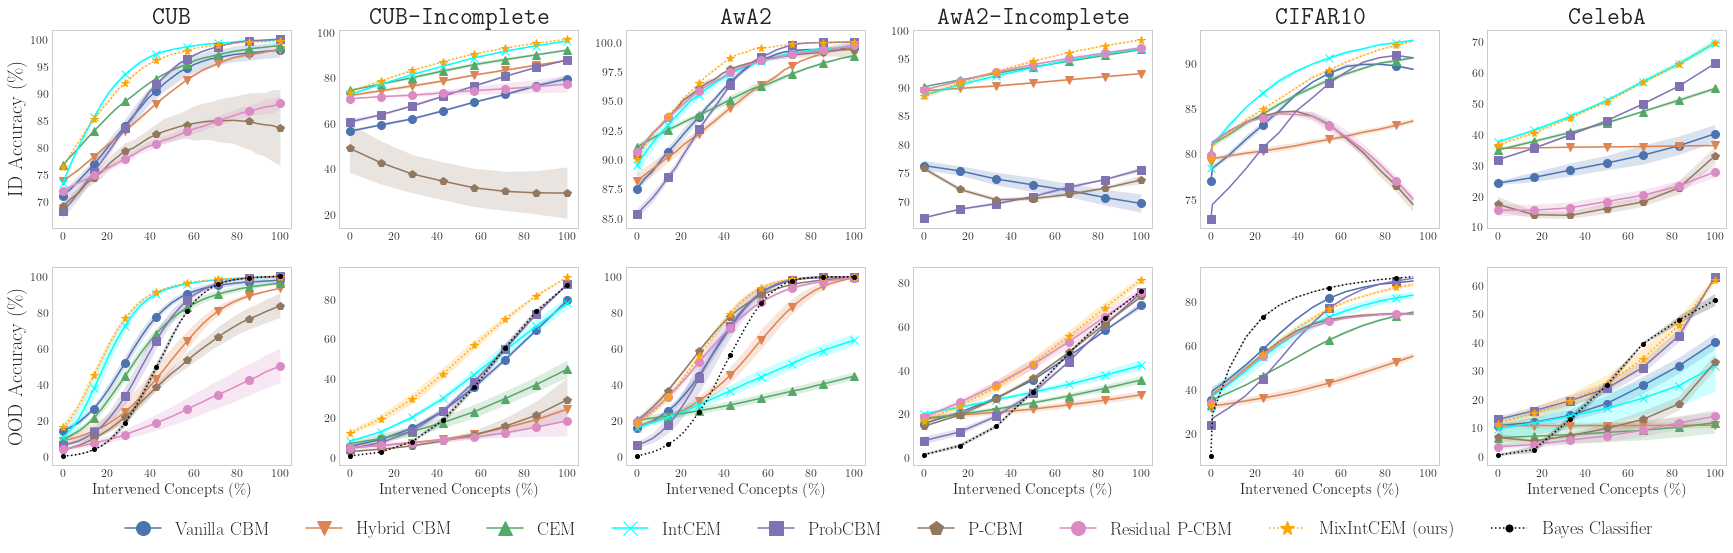

In [58]:
baselines_to_include = [
    "Joint CBM",
    "Hybrid-CBM",
    "CEM",
    # "Sigmoidal CEM",
    "IntCEM",
    "ProbCBM",
    "Posthoc CBM",
    "Posthoc Hybrid CBM",
    "Entropy CMCMixIntCEM",
    "Bayes MLP",
]

fig, axs = plt.subplots(2, len(results_to_include), figsize=(5*len(results_to_include), 8), squeeze=False)
for col, dataset_results in enumerate(results_to_include):
    results = dataset_results['results']
    used_select_metric = dataset_results.get(
        'select_metric',
        select_metric,
    )
    dataset_results['selected_models'] = joblib.load(os.path.join(dataset_results['path'], f'selected_models_{used_select_metric}.joblib'))
    print("For dataset", dataset_results['name'], "we selected")
    for key, val in dataset_results['selected_models'].items():
        print(f"\t{key}: {val}")
    selected_models = dataset_results['selected_models']
    for row, (mode_name, mode_key) in enumerate([
        ("Baseline", " (Baseline)"),
        ("Baseline OOD", " (Baseline)"),
    ]):
        ax = axs[row, col]
        for idx, label in enumerate(baselines_to_include):
            label = dataset_results.get('rename', {}).get(label, label)
            model_name = selected_models.get(
                label + mode_key,
                label + mode_key,
            )
            ints = np.array(get_metric_from_dict(
                results,
                model_name,
                f"{ood_suffix if 'OOD' in mode_name else ''}test_acc_y_random_group_level_True_use_prior_False_ints",
            ))
            if len(ints) == 0:
                print("Skipping", model_name, "for", dataset_results['name'], "as we could not find any results...")
                continue
            label = rename_map.get(label, label)
            if ("Bayes" in label) and ("OOD" not in mode_name):
                continue
            means = np.mean(ints, axis=0) * 100
            stds = np.std(ints, axis=0) * 100
            color = color_map.get(label, clrs[idx])
            marker = markers.get(label, "-x" if "Mix" in label else "-o")
            if dataset_results.get('intervention_freq', 1) != 1:
                freq = dataset_results.get('intervention_freq', 1)
                total_concepts = (len(means) - 1) * freq
                xticks = (
                    [0] + list(100 * np.arange(1.0/total_concepts, 1, freq/total_concepts))
                )
            else:
                xticks = (
                    [0] + list(100 * np.arange(1.0/(len(means) - 1), 1, 1.0/(len(means) - 1)))
                )
            if len(means) > max_limit:
                # Then let's only plot half the points to avoid clutter
                # Make the line first
                ax.plot(
                    xticks,
                    means,
                    marker[:-1],
                    color=color,
                    label=label,
                    markersize=8,
                )
                # Then make all the points
                ax.plot(
                    xticks[::4],
                    means[::4],
                    marker[-1:],
                    color=color,
                    label=label,
                    markersize=8,
                )
            else:
                # Otherwise, plot all points
                ax.plot(
                    xticks,
                    means,
                    marker,
                    color=color,
                    label=label,
                    markersize=8,
                )

            # print(mode_name, label, "means =", means)
            if show_variance:
                ax.fill_between(
                    xticks,
                    means - stds,
                    means + stds,
                    alpha=0.2,
                    facecolor=color,
                )
        ax.set_xlim(-5, 105)
        if col == 0:
            if row == 0:
                ax.set_ylabel("ID Accuracy (\%)", fontsize=20)
            else:
                ax.set_ylabel("OOD Accuracy (\%)", fontsize=20)

        if row == (axs.shape[0] - 1):
            ax.set_xlabel("Intervened Concepts (\%)", fontsize=15)
        ax.xaxis.set_tick_params(labelsize=12)
        ax.yaxis.set_tick_params(labelsize=12)
        ax.grid(False)
        if row == 0:
            ax.set_title(dataset_results['name'], fontsize=25)
        handles, labels = ax.get_legend_handles_labels()
ax.legend(
    handles,
    labels,
    fontsize=18,
    loc='upper center',
    bbox_to_anchor=(-2.5,-0.2),
    ncol=9,
    markerscale=1.75,
)
plt.savefig(f"../figures/all_non_ood_together{'_variance' if show_variance else ''}.pdf", bbox_inches='tight')
plt.savefig(f"../figures/all_non_ood_together{'_variance' if show_variance else ''}.png", bbox_inches='tight')
plt.show()

### Same results but with the non-intcem version of MixCEM

For dataset \texttt{CUB} we selected
	DNN (Baseline): DNN_extra_dims_200
	Joint CBM (Baseline): CBM_Sigmoid_Baseline_cwl_10
	Joint Logit CBM (Baseline): CBM_Logit_Baseline_cwl_10
	Hybrid-CBM (Baseline): Hybrid-CBM_Sigmoid_extra_dims_50_Baseline_cwl_5
	CEM (Baseline): CEM_Baseline_cwl_1
	IntCEM (Baseline): IntCEM_emb_size_16_intervention_weight_1_intervention_task_discount_1.5_Baseline_cwl_1
	ProbCBM (Baseline): ProbCBM_cwl_class_hidden_dim_128_hidden_dim_32_n_samples_inference_50_max_concept_epochs_70_max_task_epochs_75
	Posthoc CBM (Baseline): PCBM_reg_1e-06_l1_0.99_penalty_1
	Posthoc Hybrid CBM (Baseline): HybridPCBM_reg_1e-06_l1_0.99_penalty_1
	Entropy CMCMixIntCEM No Calibration (Baseline): Entropy_CMCMixIntCEM_t_1_r_1_concat_None_0_mpc_1_tmc_1_emc_50_cwc_False_ce_0_g_ood_0.5_emb_16_True_tip_0.25_itd_1.1_iw_0.1_cwl_1
	Entropy CMCMixIntCEM (Baseline): Entropy_CMCMixIntCEM_t_1_r_1_concat_None_0_mpc_1_tmc_1_emc_50_cwc_False_ce_30_g_ood_0.1_emb_16_True_tip_0.25_itd_1.1_iw_0.1_cwl_1
	En

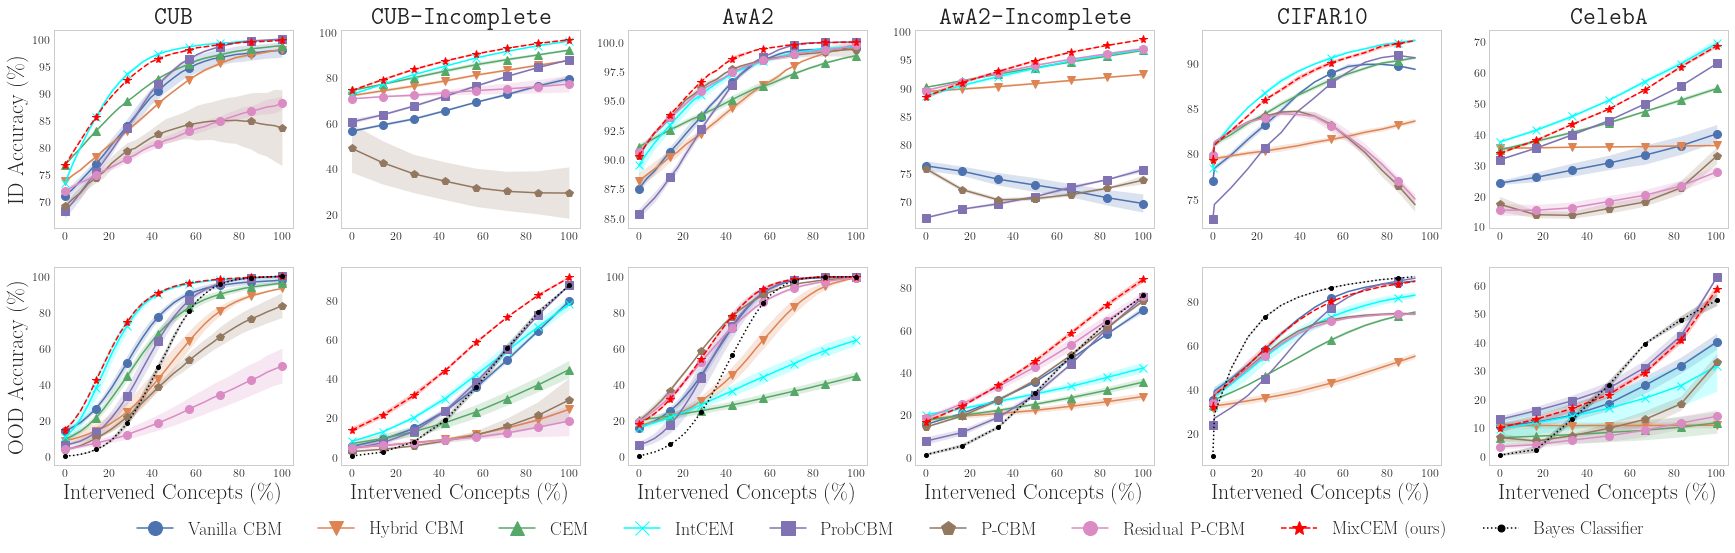

In [63]:
used_baselines_to_include = [
    "Joint CBM",
    "Hybrid-CBM",
    "CEM",
    "IntCEM",
    "ProbCBM",
    "Posthoc CBM",
    "Posthoc Hybrid CBM",
    "Entropy CMCMixCEM",
    "Bayes MLP",
]

fig, axs = plt.subplots(2, len(results_to_include), figsize=(5*len(results_to_include), 8), squeeze=False)
for col, dataset_results in enumerate(results_to_include):
    results = dataset_results['results']
    used_select_metric = dataset_results.get(
        'select_metric',
        select_metric,
    )
    dataset_results['selected_models'] = joblib.load(os.path.join(dataset_results['path'], f'selected_models_{used_select_metric}.joblib'))
    print("For dataset", dataset_results['name'], "we selected")
    for key, val in dataset_results['selected_models'].items():
        print(f"\t{key}: {val}")
    selected_models = dataset_results['selected_models']
    for row, (mode_name, mode_key) in enumerate([
        ("Baseline", " (Baseline)"),
        ("Baseline OOD", " (Baseline)"),
    ]):
        ax = axs[row, col]
        for idx, label in enumerate(used_baselines_to_include):
            label = dataset_results.get('rename', {}).get(label, label)
            model_name = selected_models.get(
                label + mode_key,
                label + mode_key,
            )
            ints = np.array(get_metric_from_dict(
                results,
                model_name,
                f"{ood_suffix if 'OOD' in mode_name else ''}test_acc_y_random_group_level_True_use_prior_False_ints",
            ))
            if len(ints) == 0:
                print("Skipping", model_name, "for", dataset_results['name'], "as we could not find any results...")
                continue
            label = rename_map.get(label, label)
            if ("Bayes" in label) and ("OOD" not in mode_name):
                continue
            means = np.mean(ints, axis=0) * 100
            stds = np.std(ints, axis=0) * 100
            color = color_map.get(label, clrs[idx])
            marker = markers.get(label, "-x" if "Mix" in label else "-o")
            if dataset_results.get('intervention_freq', 1) != 1:
                freq = dataset_results.get('intervention_freq', 1)
                total_concepts = (len(means) - 1) * freq
                xticks = (
                    [0] + list(100 * np.arange(1.0/total_concepts, 1, freq/total_concepts))
                )
            else:
                xticks = (
                    [0] + list(100 * np.arange(1.0/(len(means) - 1), 1, 1.0/(len(means) - 1)))
                )
            if len(means) > max_limit:
                # Then let's only plot half the points to avoid clutter
                # Make the line first
                ax.plot(
                    xticks,
                    means,
                    marker[:-1],
                    color=color,
                    label=label,
                    markersize=8,
                )
                # Then make all the points
                ax.plot(
                    xticks[::4],
                    means[::4],
                    marker[-1:],
                    color=color,
                    label=label,
                    markersize=8,
                )
            else:
                # Otherwise, plot all points
                ax.plot(
                    xticks,
                    means,
                    marker,
                    color=color,
                    label=label,
                    markersize=8,
                )

            # print(mode_name, label, "means =", means)
            if show_variance:
                ax.fill_between(
                    xticks,
                    means - stds,
                    means + stds,
                    alpha=0.2,
                    facecolor=color,
                )
        ax.set_xlim(-5, 105)
        if col == 0:
            if row == 0:
                ax.set_ylabel("ID Accuracy (\%)", fontsize=22)
            else:
                ax.set_ylabel("OOD Accuracy (\%)", fontsize=22)

        if row == (axs.shape[0] - 1):
            ax.set_xlabel("Intervened Concepts (\%)", fontsize=22)
        ax.xaxis.set_tick_params(labelsize=12)
        ax.yaxis.set_tick_params(labelsize=12)
        ax.grid(False)
        if row == 0:
            ax.set_title(dataset_results['name'], fontsize=25)
        handles, labels = ax.get_legend_handles_labels()
ax.legend(
    handles,
    labels,
    fontsize=18,
    loc='upper center',
    bbox_to_anchor=(-2.5,-0.2),
    ncol=9,
    markerscale=1.75,
)
plt.savefig(f"../figures/all_non_ood_results_together_true_mixcem{'_variance' if show_variance else ''}.pdf", bbox_inches='tight')
plt.savefig(f"../figures/all_non_ood_results_together_true_mixcem{'_variance' if show_variance else ''}.png", bbox_inches='tight')
plt.show()

For dataset \texttt{CUB} we selected
	DNN (Baseline): DNN_extra_dims_200
	Joint CBM (Baseline): CBM_Sigmoid_Baseline_cwl_10
	Joint Logit CBM (Baseline): CBM_Logit_Baseline_cwl_10
	Hybrid-CBM (Baseline): Hybrid-CBM_Sigmoid_extra_dims_50_Baseline_cwl_5
	CEM (Baseline): CEM_Baseline_cwl_1
	IntCEM (Baseline): IntCEM_emb_size_16_intervention_weight_1_intervention_task_discount_1.5_Baseline_cwl_1
	ProbCBM (Baseline): ProbCBM_cwl_class_hidden_dim_128_hidden_dim_32_n_samples_inference_50_max_concept_epochs_70_max_task_epochs_75
	Posthoc CBM (Baseline): PCBM_reg_1e-06_l1_0.99_penalty_1
	Posthoc Hybrid CBM (Baseline): HybridPCBM_reg_1e-06_l1_0.99_penalty_1
	Entropy CMCMixIntCEM No Calibration (Baseline): Entropy_CMCMixIntCEM_t_1_r_1_concat_None_0_mpc_1_tmc_1_emc_50_cwc_False_ce_0_g_ood_0.5_emb_16_True_tip_0.25_itd_1.1_iw_0.1_cwl_1
	Entropy CMCMixIntCEM (Baseline): Entropy_CMCMixIntCEM_t_1_r_1_concat_None_0_mpc_1_tmc_1_emc_50_cwc_False_ce_30_g_ood_0.1_emb_16_True_tip_0.25_itd_1.1_iw_0.1_cwl_1
	En

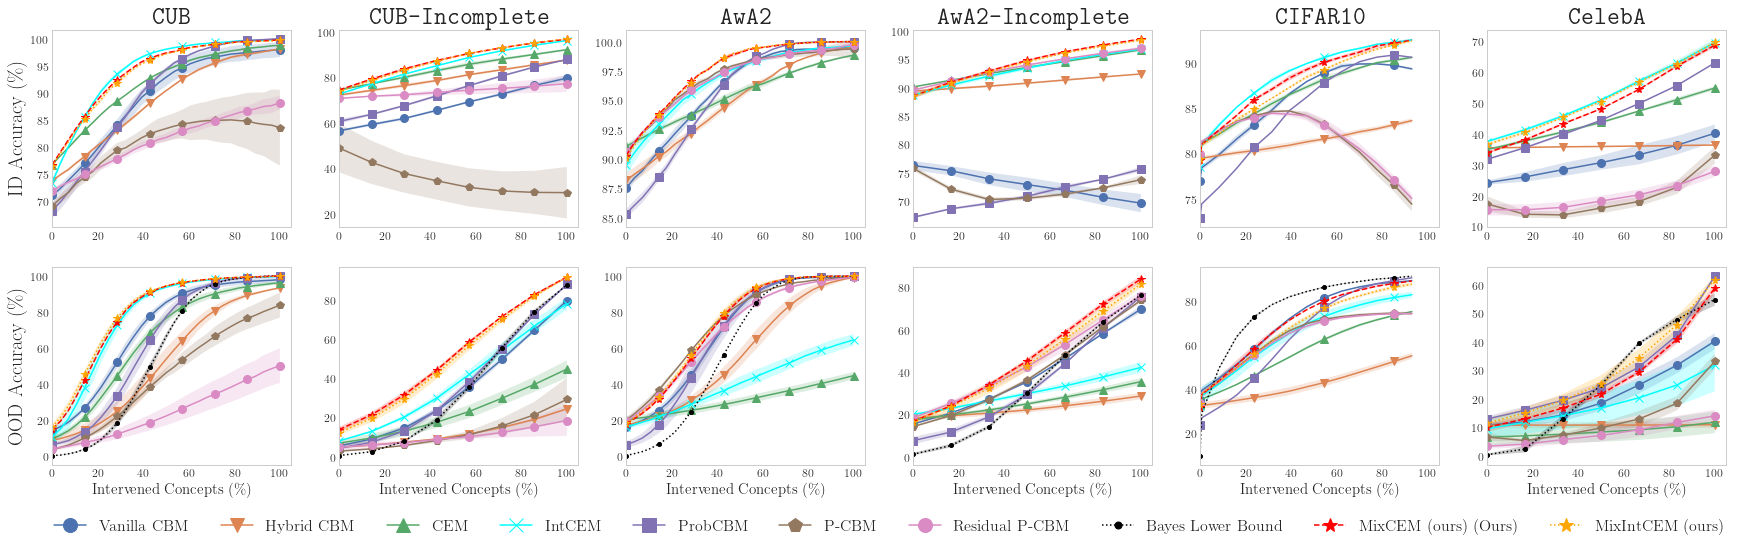

In [19]:
used_baselines_to_include = [
    "Joint CBM",
    "Hybrid-CBM",
    "CEM",
    "IntCEM",
    "ProbCBM",
    "Posthoc CBM",
    "Posthoc Hybrid CBM",
    "Bayes MLP",
    "Entropy CMCMixCEM",
    "Entropy CMCMixIntCEM",
]

fig, axs = plt.subplots(2, len(results_to_include), figsize=(5*len(results_to_include), 8), squeeze=False)
for col, dataset_results in enumerate(results_to_include):
    results = dataset_results['results']
    used_select_metric = dataset_results.get(
        'select_metric',
        select_metric,
    )
    dataset_results['selected_models'] = joblib.load(os.path.join(dataset_results['path'], f'selected_models_{used_select_metric}.joblib'))
    print("For dataset", dataset_results['name'], "we selected")
    for key, val in dataset_results['selected_models'].items():
        print(f"\t{key}: {val}")
    selected_models = dataset_results['selected_models']
    for row, (mode_name, mode_key) in enumerate([
        ("Baseline", " (Baseline)"),
        ("Baseline OOD", " (Baseline)"),
    ]):
        ax = axs[row, col]
        for idx, label in enumerate(used_baselines_to_include):
            label = dataset_results.get('rename', {}).get(label, label)
            model_name = selected_models.get(
                label + mode_key,
                label + mode_key,
            )
            ints = np.array(get_metric_from_dict(
                results,
                model_name,
                f"{ood_suffix if 'OOD' in mode_name else ''}test_acc_y_random_group_level_True_use_prior_False_ints",
            ))
            if len(ints) == 0:
                print("Skipping", model_name, "for", dataset_results['name'], "as we could not find any results...")
                continue
            label = used_rename_map.get(label, label)
            if ("Bayes" in label) and ("OOD" not in mode_name):
                continue
            means = np.mean(ints, axis=0) * 100
            stds = np.std(ints, axis=0) * 100
            color = color_map.get(label, clrs[idx])
            marker = markers.get(label, "-x" if "Mix" in label else "-o")
            if dataset_results.get('intervention_freq', 1) != 1:
                freq = dataset_results.get('intervention_freq', 1)
                total_concepts = (len(means) - 1) * freq
                xticks = (
                    [0] + list(100 * np.arange(1.0/total_concepts, 1, freq/total_concepts))
                )
            else:
                xticks = (
                    [0] + list(100 * np.arange(1.0/(len(means) - 1), 1, 1.0/(len(means) - 1)))
                )
            if "MixCEM" in label:
                label += " (Ours)"
            if len(means) > max_limit:
                # Then let's only plot half the points to avoid clutter
                # Make the line first
                ax.plot(
                    xticks,
                    means,
                    marker[:-1],
                    color=color,
                    label=label,
                    markersize=8,
                )
                # Then make all the points
                ax.plot(
                    xticks[::4],
                    means[::4],
                    marker[-1:],
                    color=color,
                    label=label,
                    markersize=8,
                )
            else:
                # Otherwise, plot all points
                ax.plot(
                    xticks,
                    means,
                    marker,
                    color=color,
                    label=label,
                    markersize=8,
                )

            # print(mode_name, label, "means =", means)
            if show_variance:
                ax.fill_between(
                    xticks,
                    means - stds,
                    means + stds,
                    alpha=0.2,
                    facecolor=color,
                )
        ax.set_xlim(0, 105)
        if col == 0:
            if row == 0:
                ax.set_ylabel("ID Accuracy (\%)", fontsize=20)
            else:
                ax.set_ylabel("OOD Accuracy (\%)", fontsize=20)

        if row == (axs.shape[0] - 1):
            ax.set_xlabel("Intervened Concepts (\%)", fontsize=15)
        ax.xaxis.set_tick_params(labelsize=12)
        ax.yaxis.set_tick_params(labelsize=12)
        ax.grid(False)
        if row == 0:
            ax.set_title(dataset_results['name'], fontsize=25)
        handles, labels = ax.get_legend_handles_labels()
ax.legend(
    handles,
    labels,
    fontsize=16,
    loc='upper center',
    bbox_to_anchor=(-2.5,-0.2),
    ncol=10,
    markerscale=1.75,
)
plt.savefig(f"../figures/all_non_ood_results_together_both_versions{'_variance' if show_variance else ''}.pdf", bbox_inches='tight')
plt.savefig(f"../figures/all_non_ood_results_together_both_versions{'_variance' if show_variance else ''}.png", bbox_inches='tight')
plt.show()

For dataset \texttt{CUB} we selected
	DNN (Baseline): DNN_extra_dims_200
	Joint CBM (Baseline): CBM_Sigmoid_Baseline_cwl_10
	Joint Logit CBM (Baseline): CBM_Logit_Baseline_cwl_10
	Hybrid-CBM (Baseline): Hybrid-CBM_Sigmoid_extra_dims_50_Baseline_cwl_5
	CEM (Baseline): CEM_Baseline_cwl_1
	IntCEM (Baseline): IntCEM_emb_size_16_intervention_weight_1_intervention_task_discount_1.5_Baseline_cwl_1
	ProbCBM (Baseline): ProbCBM_cwl_class_hidden_dim_128_hidden_dim_32_n_samples_inference_50_max_concept_epochs_70_max_task_epochs_75
	Posthoc CBM (Baseline): PCBM_reg_1e-06_l1_0.99_penalty_1
	Posthoc Hybrid CBM (Baseline): HybridPCBM_reg_1e-06_l1_0.99_penalty_1
	Entropy CMCMixIntCEM No Calibration (Baseline): Entropy_CMCMixIntCEM_t_1_r_1_concat_None_0_mpc_1_tmc_1_emc_50_cwc_False_ce_0_g_ood_0.5_emb_16_True_tip_0.25_itd_1.1_iw_0.1_cwl_1
	Entropy CMCMixIntCEM (Baseline): Entropy_CMCMixIntCEM_t_1_r_1_concat_None_0_mpc_1_tmc_1_emc_50_cwc_False_ce_30_g_ood_0.1_emb_16_True_tip_0.25_itd_1.1_iw_0.1_cwl_1
	En

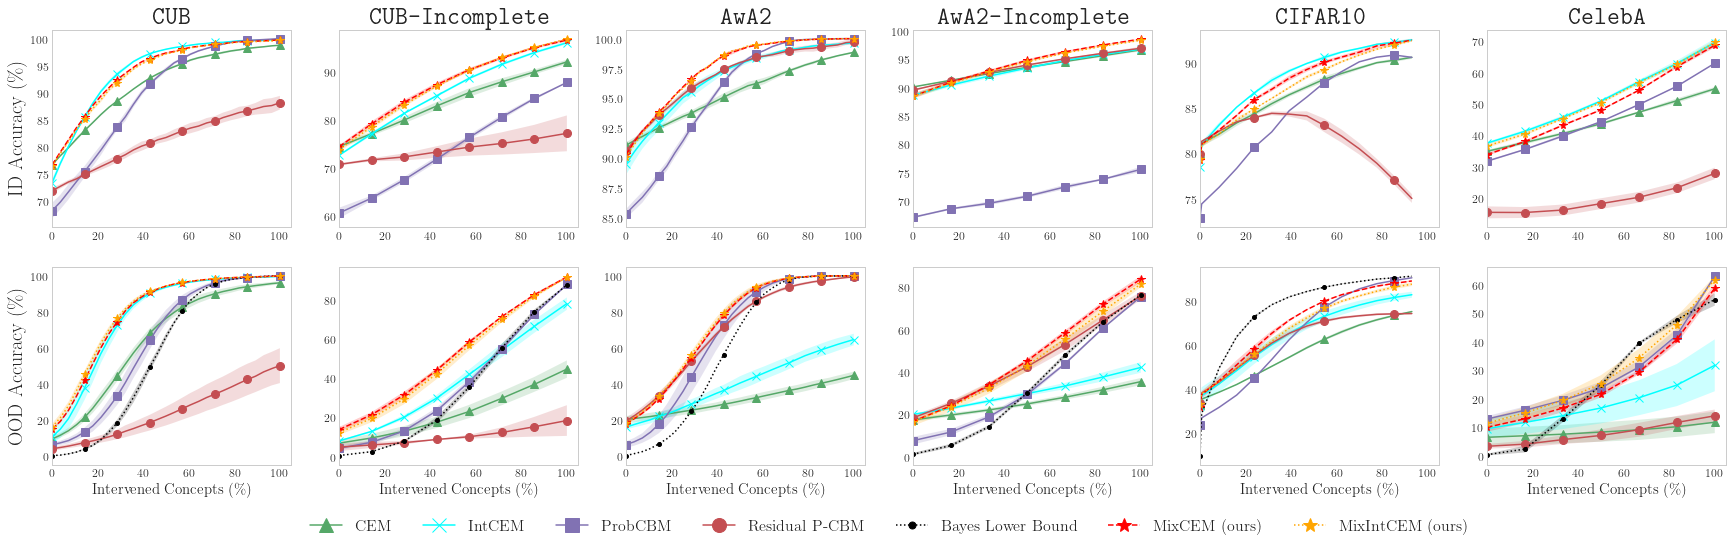

In [20]:
used_baselines_to_include = [
    # "Joint CBM",
    # "Hybrid-CBM",
    "CEM",
    "IntCEM",
    "ProbCBM",
    # "Posthoc CBM",
    "Posthoc Hybrid CBM",
    "Bayes MLP",
    "Entropy CMCMixCEM",
    "Entropy CMCMixIntCEM",
]


fig, axs = plt.subplots(2, len(results_to_include), figsize=(5*len(results_to_include), 8), squeeze=False)
for col, dataset_results in enumerate(results_to_include):
    results = dataset_results['results']
    used_select_metric = dataset_results.get(
        'select_metric',
        select_metric,
    )
    dataset_results['selected_models'] = joblib.load(os.path.join(dataset_results['path'], f'selected_models_{used_select_metric}.joblib'))
    print("For dataset", dataset_results['name'], "we selected")
    for key, val in dataset_results['selected_models'].items():
        print(f"\t{key}: {val}")
    selected_models = dataset_results['selected_models']
    for row, (mode_name, mode_key) in enumerate([
        ("Baseline", " (Baseline)"),
        ("Baseline OOD", " (Baseline)"),
    ]):
        ax = axs[row, col]
        for idx, label in enumerate(used_baselines_to_include):
            label = dataset_results.get('rename', {}).get(label, label)
            print("label =", label)
            model_name = selected_models.get(
                label + mode_key,
                label + mode_key,
            )
            ints = np.array(get_metric_from_dict(
                results,
                model_name,
                f"{ood_suffix if 'OOD' in mode_name else ''}test_acc_y_random_group_level_True_use_prior_False_ints",
            ))
            if len(ints) == 0:
                print("Skipping", model_name, "for", dataset_results['name'], "as we could not find any results...")
                continue
            label = used_rename_map.get(label, label)
            if ("Bayes" in label) and ("OOD" not in mode_name):
                continue
            means = np.mean(ints, axis=0) * 100
            stds = np.std(ints, axis=0) * 100
            color = color_map.get(label, clrs[idx])
            marker = markers.get(label, "-x" if "Mix" in label else "-o")
            if dataset_results.get('intervention_freq', 1) != 1:
                freq = dataset_results.get('intervention_freq', 1)
                total_concepts = (len(means) - 1) * freq
                xticks = (
                    [0] + list(100 * np.arange(1.0/total_concepts, 1, freq/total_concepts))
                )
            else:
                xticks = (
                    [0] + list(100 * np.arange(1.0/(len(means) - 1), 1, 1.0/(len(means) - 1)))
                )
            if len(means) > max_limit:
                # Then let's only plot half the points to avoid clutter
                # Make the line first
                ax.plot(
                    xticks,
                    means,
                    marker[:-1],
                    color=color,
                    label=label,
                    markersize=8,
                )
                # Then make all the points
                ax.plot(
                    xticks[::4],
                    means[::4],
                    marker[-1:],
                    color=color,
                    label=label,
                    markersize=8,
                )
            else:
                # Otherwise, plot all points
                ax.plot(
                    xticks,
                    means,
                    marker,
                    color=color,
                    label=label,
                    markersize=8,
                )

            # print(mode_name, label, "means =", means)
            if show_variance:
                ax.fill_between(
                    xticks,
                    means - stds,
                    means + stds,
                    alpha=0.2,
                    facecolor=color,
                )
        ax.set_xlim(0, 105)
        if col == 0:
            if row == 0:
                ax.set_ylabel("ID Accuracy (\%)", fontsize=20)
            else:
                ax.set_ylabel("OOD Accuracy (\%)", fontsize=20)

        if row == (axs.shape[0] - 1):
            ax.set_xlabel("Intervened Concepts (\%)", fontsize=15)
        ax.xaxis.set_tick_params(labelsize=12)
        ax.yaxis.set_tick_params(labelsize=12)
        ax.grid(False)
        if row == 0:
            ax.set_title(dataset_results['name'], fontsize=25)
        handles, labels = ax.get_legend_handles_labels()
ax.legend(
    handles,
    labels,
    fontsize=16,
    loc='upper center',
    bbox_to_anchor=(-2.5,-0.2),
    ncol=10,
    markerscale=1.75,
)
plt.savefig(f"../figures/all_non_ood_results_together_both_versions_smaller{'_variance' if show_variance else ''}.pdf", bbox_inches='tight')
plt.savefig(f"../figures/all_non_ood_results_together_both_versions_smaller{'_variance' if show_variance else ''}.png", bbox_inches='tight')
plt.show()

### Comparison Between the InCEM and non-IntCEM versions of MixCEM

For dataset \texttt{CUB} we selected
	DNN (Baseline): DNN_extra_dims_200
	Joint CBM (Baseline): CBM_Sigmoid_Baseline_cwl_10
	Joint Logit CBM (Baseline): CBM_Logit_Baseline_cwl_10
	Hybrid-CBM (Baseline): Hybrid-CBM_Sigmoid_extra_dims_50_Baseline_cwl_5
	CEM (Baseline): CEM_Baseline_cwl_1
	IntCEM (Baseline): IntCEM_emb_size_16_intervention_weight_1_intervention_task_discount_1.5_Baseline_cwl_1
	ProbCBM (Baseline): ProbCBM_cwl_class_hidden_dim_128_hidden_dim_32_n_samples_inference_50_max_concept_epochs_70_max_task_epochs_75
	Posthoc CBM (Baseline): PCBM_reg_1e-06_l1_0.99_penalty_1
	Posthoc Hybrid CBM (Baseline): HybridPCBM_reg_1e-06_l1_0.99_penalty_1
	Entropy CMCMixIntCEM No Calibration (Baseline): Entropy_CMCMixIntCEM_t_1_r_1_concat_None_0_mpc_1_tmc_1_emc_50_cwc_False_ce_0_g_ood_0.5_emb_16_True_tip_0.25_itd_1.1_iw_0.1_cwl_1
	Entropy CMCMixIntCEM (Baseline): Entropy_CMCMixIntCEM_t_1_r_1_concat_None_0_mpc_1_tmc_1_emc_50_cwc_False_ce_30_g_ood_0.1_emb_16_True_tip_0.25_itd_1.1_iw_0.1_cwl_1
	En

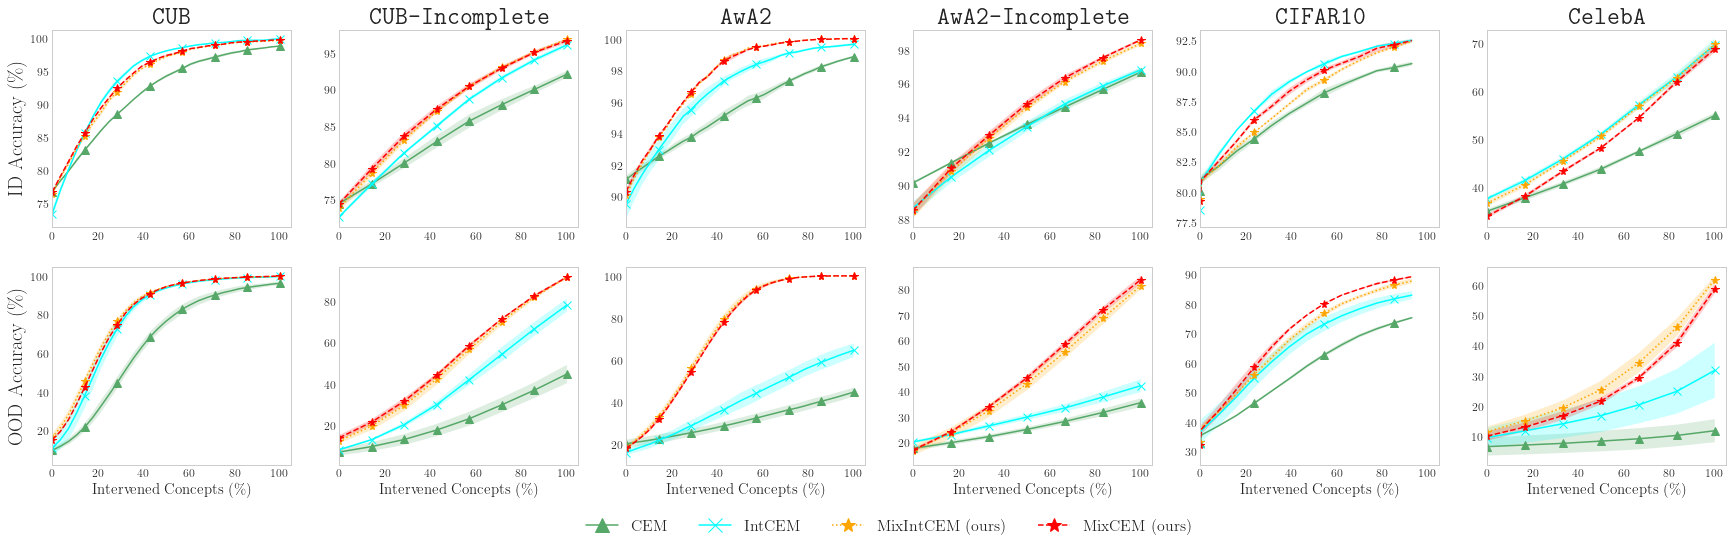

In [21]:
used_baselines_to_include = [
    "CEM",
    "IntCEM",
    "Entropy CMCMixIntCEM",
    "Entropy CMCMixCEM",
]

fig, axs = plt.subplots(2, len(results_to_include), figsize=(5*len(results_to_include), 8), squeeze=False)
for col, dataset_results in enumerate(results_to_include):
    results = dataset_results['results']
    used_select_metric = dataset_results.get(
        'select_metric',
        select_metric,
    )
    dataset_results['selected_models'] = joblib.load(os.path.join(dataset_results['path'], f'selected_models_{used_select_metric}.joblib'))
    print("For dataset", dataset_results['name'], "we selected")
    for key, val in dataset_results['selected_models'].items():
        print(f"\t{key}: {val}")
    selected_models = dataset_results['selected_models']
    for row, (mode_name, mode_key) in enumerate([
        ("Baseline", " (Baseline)"),
        ("Baseline OOD", " (Baseline)"),
    ]):
        ax = axs[row, col]
        for idx, label in enumerate(used_baselines_to_include):
            label = dataset_results.get('rename', {}).get(label, label)
            model_name = selected_models.get(
                label + mode_key,
                label + mode_key,
            )
            print("label =", label)
            print("\tmodel_name =", model_name)
            ints = np.array(get_metric_from_dict(
                results,
                model_name,
                f"{ood_suffix if 'OOD' in mode_name else ''}test_acc_y_random_group_level_True_use_prior_False_ints",
            ))
            if len(ints) == 0:
                print("Skipping", model_name, "for", dataset_results['name'], "as we could not find any results...")
                continue
            label = used_rename_map.get(label, label)
            if ("Bayes" in label) and ("OOD" not in mode_name):
                continue
            means = np.mean(ints, axis=0) * 100
            stds = np.std(ints, axis=0) * 100
            color = color_map.get(label, clrs[idx])
            marker = markers.get(label, "-x" if "Mix" in label else "-o")
            if dataset_results.get('intervention_freq', 1) != 1:
                freq = dataset_results.get('intervention_freq', 1)
                total_concepts = (len(means) - 1) * freq
                xticks = (
                    [0] + list(100 * np.arange(1.0/total_concepts, 1, freq/total_concepts))
                )
            else:
                xticks = (
                    [0] + list(100 * np.arange(1.0/(len(means) - 1), 1, 1.0/(len(means) - 1)))
                )
            if len(means) > max_limit:
                # Then let's only plot half the points to avoid clutter
                # Make the line first
                ax.plot(
                    xticks,
                    means,
                    marker[:-1],
                    color=color,
                    label=label,
                    markersize=8,
                )
                # Then make all the points
                ax.plot(
                    xticks[::4],
                    means[::4],
                    marker[-1:],
                    color=color,
                    label=label,
                    markersize=8,
                )
            else:
                # Otherwise, plot all points
                ax.plot(
                    xticks,
                    means,
                    marker,
                    color=color,
                    label=label,
                    markersize=8,
                )

            # print(mode_name, label, "means =", means)
            if show_variance:
                ax.fill_between(
                    xticks,
                    means - stds,
                    means + stds,
                    alpha=0.2,
                    facecolor=color,
                )
        ax.set_xlim(0, 105)
        if col == 0:
            if row == 0:
                ax.set_ylabel("ID Accuracy (\%)", fontsize=20)
            else:
                ax.set_ylabel("OOD Accuracy (\%)", fontsize=20)

        if row == (axs.shape[0] - 1):
            ax.set_xlabel("Intervened Concepts (\%)", fontsize=15)
        ax.xaxis.set_tick_params(labelsize=12)
        ax.yaxis.set_tick_params(labelsize=12)
        ax.grid(False)
        if row == 0:
            ax.set_title(dataset_results['name'], fontsize=25)
        handles, labels = ax.get_legend_handles_labels()
ax.legend(
    handles,
    labels,
    fontsize=16,
    loc='upper center',
    bbox_to_anchor=(-2.5,-0.2),
    ncol=9,
    markerscale=1.75,
)
plt.savefig(f"../figures/all_non_ood_results_mixcem_vs_mixintcem{'_variance' if show_variance else ''}.pdf", bbox_inches='tight')
plt.savefig(f"../figures/all_non_ood_results_mixcem_vs_mixintcem{'_variance' if show_variance else ''}.png", bbox_inches='tight')
plt.show()

### Same plots without any calibration

For dataset \texttt{CUB} we selected
	DNN (Baseline): DNN_extra_dims_200
	Joint CBM (Baseline): CBM_Sigmoid_Baseline_cwl_10
	Joint Logit CBM (Baseline): CBM_Logit_Baseline_cwl_10
	Hybrid-CBM (Baseline): Hybrid-CBM_Sigmoid_extra_dims_50_Baseline_cwl_5
	CEM (Baseline): CEM_Baseline_cwl_1
	IntCEM (Baseline): IntCEM_emb_size_16_intervention_weight_1_intervention_task_discount_1.5_Baseline_cwl_1
	ProbCBM (Baseline): ProbCBM_cwl_class_hidden_dim_128_hidden_dim_32_n_samples_inference_50_max_concept_epochs_70_max_task_epochs_75
	Posthoc CBM (Baseline): PCBM_reg_1e-06_l1_0.99_penalty_1
	Posthoc Hybrid CBM (Baseline): HybridPCBM_reg_1e-06_l1_0.99_penalty_1
	Entropy CMCMixIntCEM No Calibration (Baseline): Entropy_CMCMixIntCEM_t_1_r_1_concat_None_0_mpc_1_tmc_1_emc_50_cwc_False_ce_0_g_ood_0.5_emb_16_True_tip_0.25_itd_1.1_iw_0.1_cwl_1
	Entropy CMCMixIntCEM (Baseline): Entropy_CMCMixIntCEM_t_1_r_1_concat_None_0_mpc_1_tmc_1_emc_50_cwc_False_ce_30_g_ood_0.1_emb_16_True_tip_0.25_itd_1.1_iw_0.1_cwl_1
	En

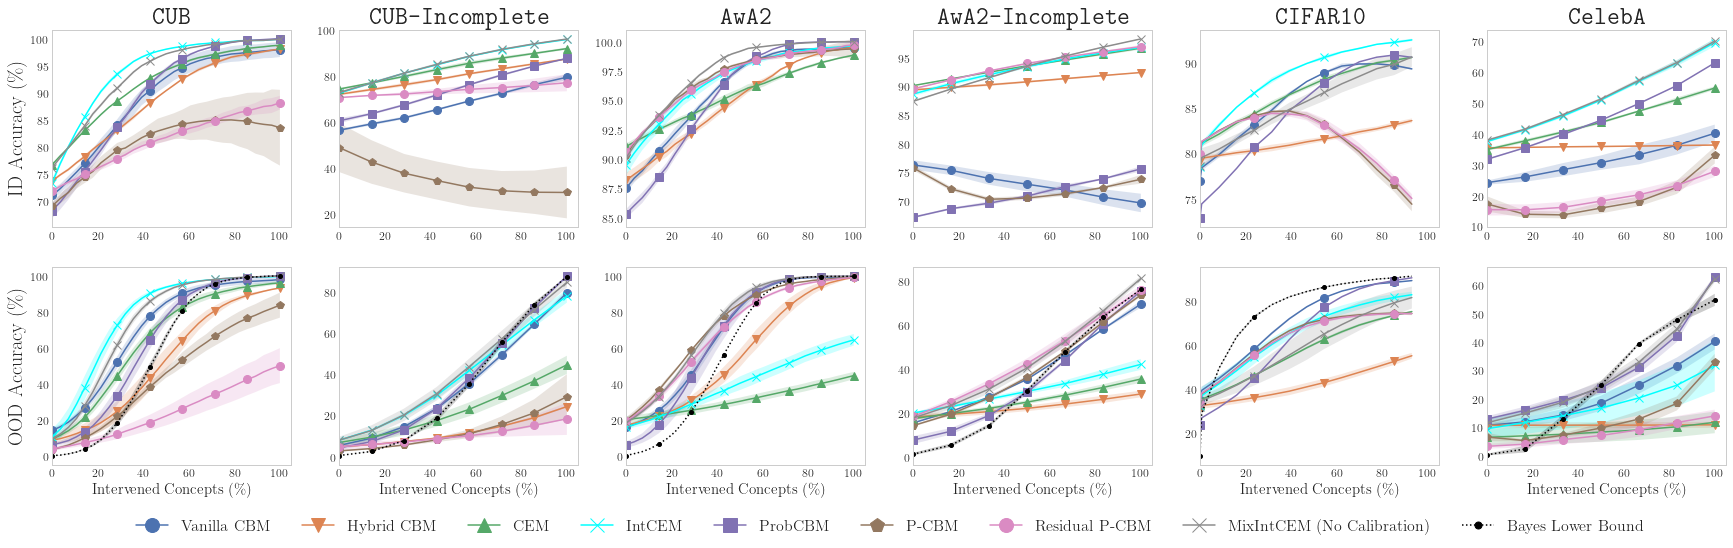

In [22]:
baselines_to_include = [
    "Joint CBM",
    "Hybrid-CBM",
    "CEM",
    "IntCEM",
    "ProbCBM",
    "Posthoc CBM",
    "Posthoc Hybrid CBM",
    "Entropy CMCMixIntCEM No Calibration",
    "Bayes MLP",
]

used_rename_map["Entropy CMCMixIntCEM No Calibration"] = "MixIntCEM (No Calibration)"

fig, axs = plt.subplots(2, len(results_to_include), figsize=(5*len(results_to_include), 8), squeeze=False)
for col, dataset_results in enumerate(results_to_include):
    results = dataset_results['results']
    used_select_metric = dataset_results.get(
        'select_metric',
        select_metric,
    )
    dataset_results['selected_models'] = joblib.load(os.path.join(dataset_results['path'], f'selected_models_{used_select_metric}.joblib'))
    print("For dataset", dataset_results['name'], "we selected")
    for key, val in dataset_results['selected_models'].items():
        print(f"\t{key}: {val}")
    selected_models = dataset_results['selected_models']
    for row, (mode_name, mode_key) in enumerate([
        ("Baseline", " (Baseline)"),
        ("Baseline OOD", " (Baseline)"),
    ]):
        ax = axs[row, col]
        for idx, label in enumerate(baselines_to_include):
            label = dataset_results.get('rename', {}).get(label, label)
            model_name = selected_models.get(
                label + mode_key,
                label + mode_key,
            )
            ints = np.array(get_metric_from_dict(
                results,
                model_name,
                f"{ood_suffix if 'OOD' in mode_name else ''}test_acc_y_random_group_level_True_use_prior_False_ints",
            ))
            if len(ints) == 0:
                print("Skipping", model_name, "for", dataset_results['name'], "as we could not find any results...")
                continue
            label = used_rename_map.get(label, label)
            if ("Bayes" in label) and ("OOD" not in mode_name):
                continue
            means = np.mean(ints, axis=0) * 100
            stds = np.std(ints, axis=0) * 100
            color = color_map.get(label, clrs[idx])
            marker = markers.get(label, "-x" if "Mix" in label else "-o")
            if dataset_results.get('intervention_freq', 1) != 1:
                freq = dataset_results.get('intervention_freq', 1)
                total_concepts = (len(means) - 1) * freq
                xticks = (
                    [0] + list(100 * np.arange(1.0/total_concepts, 1, freq/total_concepts))
                )
            else:
                xticks = (
                    [0] + list(100 * np.arange(1.0/(len(means) - 1), 1, 1.0/(len(means) - 1)))
                )
            if len(means) > max_limit:
                # Then let's only plot half the points to avoid clutter
                # Make the line first
                ax.plot(
                    xticks,
                    means,
                    marker[:-1],
                    color=color,
                    label=label,
                    markersize=8,
                )
                # Then make all the points
                ax.plot(
                    xticks[::4],
                    means[::4],
                    marker[-1:],
                    color=color,
                    label=label,
                    markersize=8,
                )
            else:
                # Otherwise, plot all points
                ax.plot(
                    xticks,
                    means,
                    marker,
                    color=color,
                    label=label,
                    markersize=8,
                )

            # print(mode_name, label, "means =", means)
            if show_variance:
                ax.fill_between(
                    xticks,
                    means - stds,
                    means + stds,
                    alpha=0.2,
                    facecolor=color,
                )
        ax.set_xlim(0, 105)
        if col == 0:
            if row == 0:
                ax.set_ylabel("ID Accuracy (\%)", fontsize=20)
            else:
                ax.set_ylabel("OOD Accuracy (\%)", fontsize=20)

        if row == (axs.shape[0] - 1):
            ax.set_xlabel("Intervened Concepts (\%)", fontsize=15)
        ax.xaxis.set_tick_params(labelsize=12)
        ax.yaxis.set_tick_params(labelsize=12)
        ax.grid(False)
        if row == 0:
            ax.set_title(dataset_results['name'], fontsize=25)
        handles, labels = ax.get_legend_handles_labels()
ax.legend(
    handles,
    labels,
    fontsize=16,
    loc='upper center',
    bbox_to_anchor=(-2.5,-0.2),
    ncol=9,
    markerscale=1.75,
)
plt.savefig(f"../figures/all_non_ood_results_together_no_cal{'_variance' if show_variance else ''}.pdf", bbox_inches='tight')
plt.savefig(f"../figures/all_non_ood_results_together_no_cal{'_variance' if show_variance else ''}.png", bbox_inches='tight')
plt.show()

For dataset \texttt{CUB} we selected
	DNN (Baseline): DNN_extra_dims_200
	Joint CBM (Baseline): CBM_Sigmoid_Baseline_cwl_10
	Joint Logit CBM (Baseline): CBM_Logit_Baseline_cwl_10
	Hybrid-CBM (Baseline): Hybrid-CBM_Sigmoid_extra_dims_50_Baseline_cwl_5
	CEM (Baseline): CEM_Baseline_cwl_1
	IntCEM (Baseline): IntCEM_emb_size_16_intervention_weight_1_intervention_task_discount_1.5_Baseline_cwl_1
	ProbCBM (Baseline): ProbCBM_cwl_class_hidden_dim_128_hidden_dim_32_n_samples_inference_50_max_concept_epochs_70_max_task_epochs_75
	Posthoc CBM (Baseline): PCBM_reg_1e-06_l1_0.99_penalty_1
	Posthoc Hybrid CBM (Baseline): HybridPCBM_reg_1e-06_l1_0.99_penalty_1
	Entropy CMCMixIntCEM No Calibration (Baseline): Entropy_CMCMixIntCEM_t_1_r_1_concat_None_0_mpc_1_tmc_1_emc_50_cwc_False_ce_0_g_ood_0.5_emb_16_True_tip_0.25_itd_1.1_iw_0.1_cwl_1
	Entropy CMCMixIntCEM (Baseline): Entropy_CMCMixIntCEM_t_1_r_1_concat_None_0_mpc_1_tmc_1_emc_50_cwc_False_ce_30_g_ood_0.1_emb_16_True_tip_0.25_itd_1.1_iw_0.1_cwl_1
	En

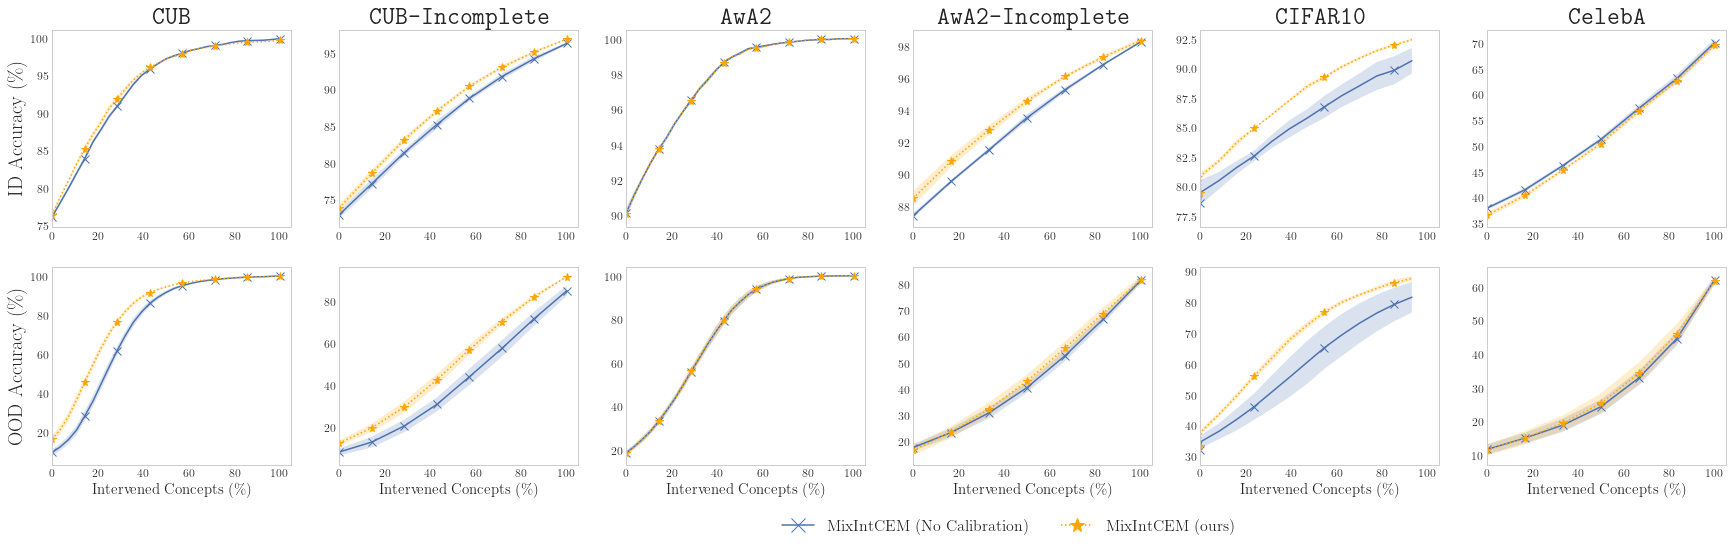

In [23]:
baselines_to_include = [
    "Entropy CMCMixIntCEM No Calibration",
    "Entropy CMCMixIntCEM",
]

used_rename_map["Entropy CMCMixIntCEM No Calibration"] = "MixIntCEM (No Calibration)"

fig, axs = plt.subplots(2, len(results_to_include), figsize=(5*len(results_to_include), 8), squeeze=False)
for col, dataset_results in enumerate(results_to_include):
    results = dataset_results['results']
    used_select_metric = dataset_results.get(
        'select_metric',
        select_metric,
    )
    dataset_results['selected_models'] = joblib.load(os.path.join(dataset_results['path'], f'selected_models_{used_select_metric}.joblib'))
    print("For dataset", dataset_results['name'], "we selected")
    for key, val in dataset_results['selected_models'].items():
        print(f"\t{key}: {val}")
    selected_models = dataset_results['selected_models']
    for row, (mode_name, mode_key) in enumerate([
        ("Baseline", " (Baseline)"),
        ("Baseline OOD", " (Baseline)"),
    ]):
        ax = axs[row, col]
        for idx, label in enumerate(baselines_to_include):
            label = dataset_results.get('rename', {}).get(label, label)
            model_name = selected_models.get(
                label + mode_key,
                label + mode_key,
            )
            ints = np.array(get_metric_from_dict(
                results,
                model_name,
                f"{ood_suffix if 'OOD' in mode_name else ''}test_acc_y_random_group_level_True_use_prior_False_ints",
            ))
            if len(ints) == 0:
                print("Skipping", model_name, "for", dataset_results['name'], "as we could not find any results...")
                continue
            label = used_rename_map.get(label, label)
            if ("Bayes" in label) and ("OOD" not in mode_name):
                continue
            means = np.mean(ints, axis=0) * 100
            stds = np.std(ints, axis=0) * 100
            color = color_map.get(label, clrs[idx])
            marker = markers.get(label, "-x" if "Mix" in label else "-o")
            if dataset_results.get('intervention_freq', 1) != 1:
                freq = dataset_results.get('intervention_freq', 1)
                total_concepts = (len(means) - 1) * freq
                xticks = (
                    [0] + list(100 * np.arange(1.0/total_concepts, 1, freq/total_concepts))
                )
            else:
                xticks = (
                    [0] + list(100 * np.arange(1.0/(len(means) - 1), 1, 1.0/(len(means) - 1)))
                )
            if len(means) > max_limit:
                # Then let's only plot half the points to avoid clutter
                # Make the line first
                ax.plot(
                    xticks,
                    means,
                    marker[:-1],
                    color=color,
                    label=label,
                    markersize=8,
                )
                # Then make all the points
                ax.plot(
                    xticks[::4],
                    means[::4],
                    marker[-1:],
                    color=color,
                    label=label,
                    markersize=8,
                )
            else:
                # Otherwise, plot all points
                ax.plot(
                    xticks,
                    means,
                    marker,
                    color=color,
                    label=label,
                    markersize=8,
                )

            # print(mode_name, label, "means =", means)
            if show_variance:
                ax.fill_between(
                    xticks,
                    means - stds,
                    means + stds,
                    alpha=0.2,
                    facecolor=color,
                )
        ax.set_xlim(0, 105)
        if col == 0:
            if row == 0:
                ax.set_ylabel("ID Accuracy (\%)", fontsize=20)
            else:
                ax.set_ylabel("OOD Accuracy (\%)", fontsize=20)

        if row == (axs.shape[0] - 1):
            ax.set_xlabel("Intervened Concepts (\%)", fontsize=15)
        ax.xaxis.set_tick_params(labelsize=12)
        ax.yaxis.set_tick_params(labelsize=12)
        ax.grid(False)
        if row == 0:
            ax.set_title(dataset_results['name'], fontsize=25)
        handles, labels = ax.get_legend_handles_labels()
ax.legend(
    handles,
    labels,
    fontsize=16,
    loc='upper center',
    bbox_to_anchor=(-2,-0.2),
    ncol=9,
    markerscale=1.75,
)
plt.savefig(f"../figures/all_non_ood_results_no_cal_vs_cal{'_variance' if show_variance else ''}.pdf", bbox_inches='tight')
plt.savefig(f"../figures/all_non_ood_results_no_cal_vs_cal{'_variance' if show_variance else ''}.png", bbox_inches='tight')
plt.show()

### No calibration but for MixCEM without any IntCEM loss terms

For dataset \texttt{CUB} we selected
	DNN (Baseline): DNN_extra_dims_200
	Joint CBM (Baseline): CBM_Sigmoid_Baseline_cwl_10
	Joint Logit CBM (Baseline): CBM_Logit_Baseline_cwl_10
	Hybrid-CBM (Baseline): Hybrid-CBM_Sigmoid_extra_dims_50_Baseline_cwl_5
	CEM (Baseline): CEM_Baseline_cwl_1
	IntCEM (Baseline): IntCEM_emb_size_16_intervention_weight_1_intervention_task_discount_1.5_Baseline_cwl_1
	ProbCBM (Baseline): ProbCBM_cwl_class_hidden_dim_128_hidden_dim_32_n_samples_inference_50_max_concept_epochs_70_max_task_epochs_75
	Posthoc CBM (Baseline): PCBM_reg_1e-06_l1_0.99_penalty_1
	Posthoc Hybrid CBM (Baseline): HybridPCBM_reg_1e-06_l1_0.99_penalty_1
	Entropy CMCMixIntCEM No Calibration (Baseline): Entropy_CMCMixIntCEM_t_1_r_1_concat_None_0_mpc_1_tmc_1_emc_50_cwc_False_ce_0_g_ood_0.5_emb_16_True_tip_0.25_itd_1.1_iw_0.1_cwl_1
	Entropy CMCMixIntCEM (Baseline): Entropy_CMCMixIntCEM_t_1_r_1_concat_None_0_mpc_1_tmc_1_emc_50_cwc_False_ce_30_g_ood_0.1_emb_16_True_tip_0.25_itd_1.1_iw_0.1_cwl_1
	En

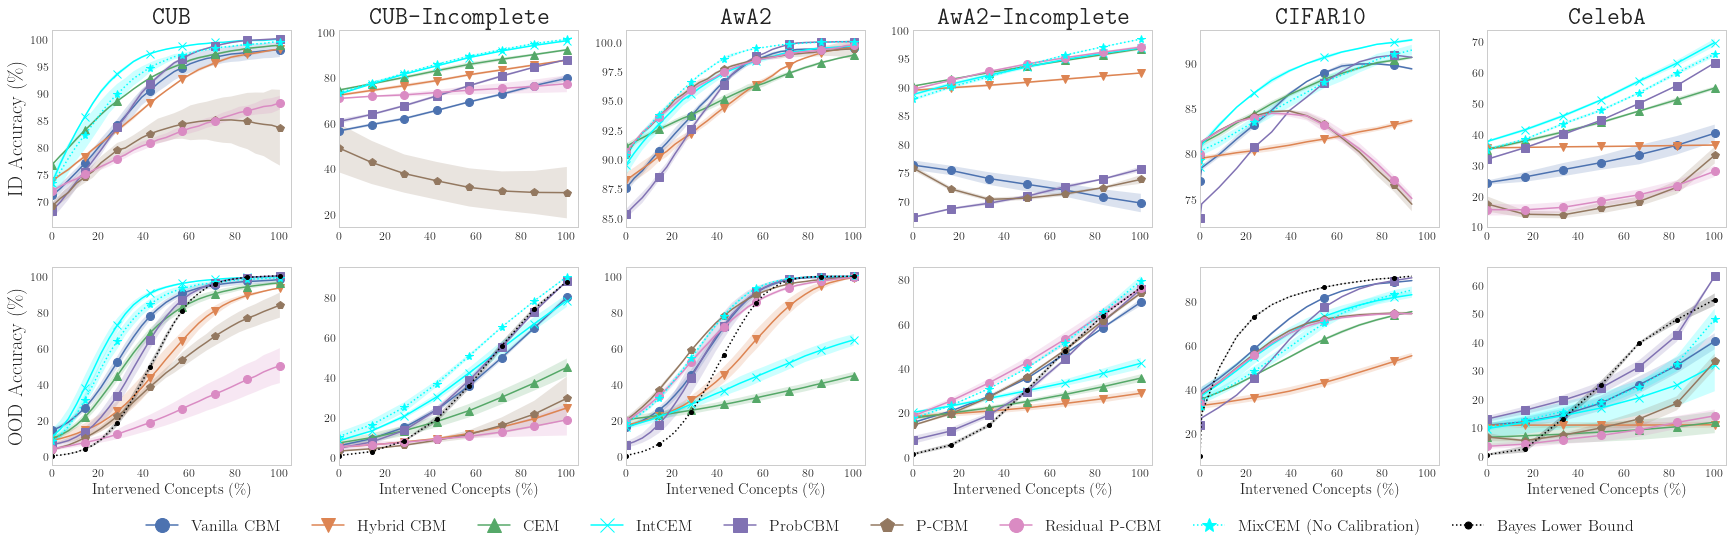

In [24]:
baselines_to_include = [
    "Joint CBM",
    "Hybrid-CBM",
    "CEM",
    "IntCEM",
    "ProbCBM",
    "Posthoc CBM",
    "Posthoc Hybrid CBM",
    "Entropy CMCMixCEM No Calibration",
    "Bayes MLP",
]

fig, axs = plt.subplots(2, len(results_to_include), figsize=(5*len(results_to_include), 8), squeeze=False)
for col, dataset_results in enumerate(results_to_include):
    results = dataset_results['results']
    used_select_metric = dataset_results.get(
        'select_metric',
        select_metric,
    )
    dataset_results['selected_models'] = joblib.load(os.path.join(dataset_results['path'], f'selected_models_{used_select_metric}.joblib'))
    print("For dataset", dataset_results['name'], "we selected")
    for key, val in dataset_results['selected_models'].items():
        print(f"\t{key}: {val}")
    selected_models = dataset_results['selected_models']
    for row, (mode_name, mode_key) in enumerate([
        ("Baseline", " (Baseline)"),
        ("Baseline OOD", " (Baseline)"),
    ]):
        ax = axs[row, col]
        for idx, label in enumerate(baselines_to_include):
            label = dataset_results.get('rename', {}).get(label, label)
            model_name = selected_models.get(
                label + mode_key,
                label + mode_key,
            )
            ints = np.array(get_metric_from_dict(
                results,
                model_name,
                f"{ood_suffix if 'OOD' in mode_name else ''}test_acc_y_random_group_level_True_use_prior_False_ints",
            ))
            if len(ints) == 0:
                print("Skipping", model_name, "for", dataset_results['name'], "as we could not find any results...")
                continue
            label = used_rename_map.get(label, label)
            if ("Bayes" in label) and ("OOD" not in mode_name):
                continue
            means = np.mean(ints, axis=0) * 100
            stds = np.std(ints, axis=0) * 100
            color = color_map.get(label, clrs[idx])
            marker = markers.get(label, "-x" if "Mix" in label else "-o")
            if dataset_results.get('intervention_freq', 1) != 1:
                freq = dataset_results.get('intervention_freq', 1)
                total_concepts = (len(means) - 1) * freq
                xticks = (
                    [0] + list(100 * np.arange(1.0/total_concepts, 1, freq/total_concepts))
                )
            else:
                xticks = (
                    [0] + list(100 * np.arange(1.0/(len(means) - 1), 1, 1.0/(len(means) - 1)))
                )
            if len(means) > max_limit:
                # Then let's only plot half the points to avoid clutter
                # Make the line first
                ax.plot(
                    xticks,
                    means,
                    marker[:-1],
                    color=color,
                    label=label,
                    markersize=8,
                )
                # Then make all the points
                ax.plot(
                    xticks[::4],
                    means[::4],
                    marker[-1:],
                    color=color,
                    label=label,
                    markersize=8,
                )
            else:
                # Otherwise, plot all points
                ax.plot(
                    xticks,
                    means,
                    marker,
                    color=color,
                    label=label,
                    markersize=8,
                )

            # print(mode_name, label, "means =", means)
            if show_variance:
                ax.fill_between(
                    xticks,
                    means - stds,
                    means + stds,
                    alpha=0.2,
                    facecolor=color,
                )
        ax.set_xlim(0, 105)
        if col == 0:
            if row == 0:
                ax.set_ylabel("ID Accuracy (\%)", fontsize=20)
            else:
                ax.set_ylabel("OOD Accuracy (\%)", fontsize=20)

        if row == (axs.shape[0] - 1):
            ax.set_xlabel("Intervened Concepts (\%)", fontsize=15)
        ax.xaxis.set_tick_params(labelsize=12)
        ax.yaxis.set_tick_params(labelsize=12)
        ax.grid(False)
        if row == 0:
            ax.set_title(dataset_results['name'], fontsize=25)
        handles, labels = ax.get_legend_handles_labels()
ax.legend(
    handles,
    labels,
    fontsize=16,
    loc='upper center',
    bbox_to_anchor=(-2.5,-0.2),
    ncol=9,
    markerscale=1.75,
)
plt.savefig(f"../figures/all_non_ood_results_together_no_cal_true_mixcem{'_variance' if show_variance else ''}.pdf", bbox_inches='tight')
plt.savefig(f"../figures/all_non_ood_results_together_no_cal_true_mixcem{'_variance' if show_variance else ''}.png", bbox_inches='tight')
plt.show()

For dataset \texttt{CUB} we selected
	DNN (Baseline): DNN_extra_dims_200
	Joint CBM (Baseline): CBM_Sigmoid_Baseline_cwl_10
	Joint Logit CBM (Baseline): CBM_Logit_Baseline_cwl_10
	Hybrid-CBM (Baseline): Hybrid-CBM_Sigmoid_extra_dims_50_Baseline_cwl_5
	CEM (Baseline): CEM_Baseline_cwl_1
	IntCEM (Baseline): IntCEM_emb_size_16_intervention_weight_1_intervention_task_discount_1.5_Baseline_cwl_1
	ProbCBM (Baseline): ProbCBM_cwl_class_hidden_dim_128_hidden_dim_32_n_samples_inference_50_max_concept_epochs_70_max_task_epochs_75
	Posthoc CBM (Baseline): PCBM_reg_1e-06_l1_0.99_penalty_1
	Posthoc Hybrid CBM (Baseline): HybridPCBM_reg_1e-06_l1_0.99_penalty_1
	Entropy CMCMixIntCEM No Calibration (Baseline): Entropy_CMCMixIntCEM_t_1_r_1_concat_None_0_mpc_1_tmc_1_emc_50_cwc_False_ce_0_g_ood_0.5_emb_16_True_tip_0.25_itd_1.1_iw_0.1_cwl_1
	Entropy CMCMixIntCEM (Baseline): Entropy_CMCMixIntCEM_t_1_r_1_concat_None_0_mpc_1_tmc_1_emc_50_cwc_False_ce_30_g_ood_0.1_emb_16_True_tip_0.25_itd_1.1_iw_0.1_cwl_1
	En

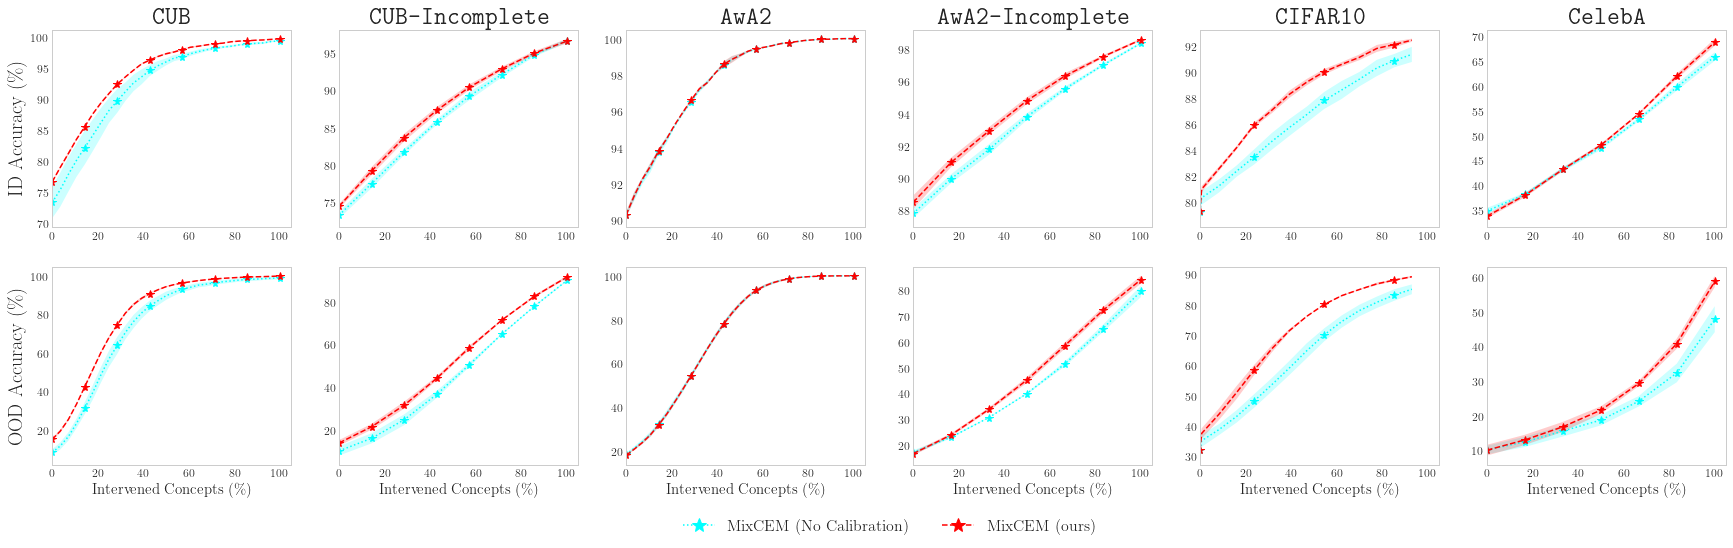

In [25]:
baselines_to_include = [
    "Entropy CMCMixCEM No Calibration",
    "Entropy CMCMixCEM",
]

used_rename_map["Entropy CMCMixCEM No Calibration"] = "MixCEM (No Calibration)"

fig, axs = plt.subplots(2, len(results_to_include), figsize=(5*len(results_to_include), 8), squeeze=False)
for col, dataset_results in enumerate(results_to_include):
    results = dataset_results['results']
    used_select_metric = dataset_results.get(
        'select_metric',
        select_metric,
    )
    dataset_results['selected_models'] = joblib.load(os.path.join(dataset_results['path'], f'selected_models_{used_select_metric}.joblib'))
    print("For dataset", dataset_results['name'], "we selected")
    for key, val in dataset_results['selected_models'].items():
        print(f"\t{key}: {val}")
    selected_models = dataset_results['selected_models']
    for row, (mode_name, mode_key) in enumerate([
        ("Baseline", " (Baseline)"),
        ("Baseline OOD", " (Baseline)"),
    ]):
        ax = axs[row, col]
        for idx, label in enumerate(baselines_to_include):
            label = dataset_results.get('rename', {}).get(label, label)
            model_name = selected_models.get(
                label + mode_key,
                label + mode_key,
            )
            ints = np.array(get_metric_from_dict(
                results,
                model_name,
                f"{ood_suffix if 'OOD' in mode_name else ''}test_acc_y_random_group_level_True_use_prior_False_ints",
            ))
            if len(ints) == 0:
                print("Skipping", model_name, "for", dataset_results['name'], "as we could not find any results...")
                continue
            label = used_rename_map.get(label, label)
            if ("Bayes" in label) and ("OOD" not in mode_name):
                continue
            means = np.mean(ints, axis=0) * 100
            stds = np.std(ints, axis=0) * 100
            color = color_map.get(label, clrs[idx])
            marker = markers.get(label, "-x" if "Mix" in label else "-o")
            if dataset_results.get('intervention_freq', 1) != 1:
                freq = dataset_results.get('intervention_freq', 1)
                total_concepts = (len(means) - 1) * freq
                xticks = (
                    [0] + list(100 * np.arange(1.0/total_concepts, 1, freq/total_concepts))
                )
            else:
                xticks = (
                    [0] + list(100 * np.arange(1.0/(len(means) - 1), 1, 1.0/(len(means) - 1)))
                )
            if len(means) > max_limit:
                # Then let's only plot half the points to avoid clutter
                # Make the line first
                ax.plot(
                    xticks,
                    means,
                    marker[:-1],
                    color=color,
                    label=label,
                    markersize=8,
                )
                # Then make all the points
                ax.plot(
                    xticks[::4],
                    means[::4],
                    marker[-1:],
                    color=color,
                    label=label,
                    markersize=8,
                )
            else:
                # Otherwise, plot all points
                ax.plot(
                    xticks,
                    means,
                    marker,
                    color=color,
                    label=label,
                    markersize=8,
                )

            # print(mode_name, label, "means =", means)
            if show_variance:
                ax.fill_between(
                    xticks,
                    means - stds,
                    means + stds,
                    alpha=0.2,
                    facecolor=color,
                )
        ax.set_xlim(0, 105)
        if col == 0:
            if row == 0:
                ax.set_ylabel("ID Accuracy (\%)", fontsize=20)
            else:
                ax.set_ylabel("OOD Accuracy (\%)", fontsize=20)

        if row == (axs.shape[0] - 1):
            ax.set_xlabel("Intervened Concepts (\%)", fontsize=15)
        ax.xaxis.set_tick_params(labelsize=12)
        ax.yaxis.set_tick_params(labelsize=12)
        ax.grid(False)
        if row == 0:
            ax.set_title(dataset_results['name'], fontsize=25)
        handles, labels = ax.get_legend_handles_labels()
ax.legend(
    handles,
    labels,
    fontsize=16,
    loc='upper center',
    bbox_to_anchor=(-2.5,-0.2),
    ncol=9,
    markerscale=1.75,
)
plt.savefig(f"../figures/all_non_ood_results_no_cal_vs_cal_true_mixcem{'_variance' if show_variance else ''}.pdf", bbox_inches='tight')
plt.savefig(f"../figures/all_non_ood_results_no_cal_vs_cal_true_mixcem{'_variance' if show_variance else ''}.png", bbox_inches='tight')
plt.show()

For dataset \texttt{CUB} we selected
	DNN (Baseline): DNN_extra_dims_200
	Joint CBM (Baseline): CBM_Sigmoid_Baseline_cwl_10
	Joint Logit CBM (Baseline): CBM_Logit_Baseline_cwl_10
	Hybrid-CBM (Baseline): Hybrid-CBM_Sigmoid_extra_dims_50_Baseline_cwl_5
	CEM (Baseline): CEM_Baseline_cwl_1
	IntCEM (Baseline): IntCEM_emb_size_16_intervention_weight_1_intervention_task_discount_1.5_Baseline_cwl_1
	ProbCBM (Baseline): ProbCBM_cwl_class_hidden_dim_128_hidden_dim_32_n_samples_inference_50_max_concept_epochs_70_max_task_epochs_75
	Posthoc CBM (Baseline): PCBM_reg_1e-06_l1_0.99_penalty_1
	Posthoc Hybrid CBM (Baseline): HybridPCBM_reg_1e-06_l1_0.99_penalty_1
	Entropy CMCMixIntCEM No Calibration (Baseline): Entropy_CMCMixIntCEM_t_1_r_1_concat_None_0_mpc_1_tmc_1_emc_50_cwc_False_ce_0_g_ood_0.5_emb_16_True_tip_0.25_itd_1.1_iw_0.1_cwl_1
	Entropy CMCMixIntCEM (Baseline): Entropy_CMCMixIntCEM_t_1_r_1_concat_None_0_mpc_1_tmc_1_emc_50_cwc_False_ce_30_g_ood_0.1_emb_16_True_tip_0.25_itd_1.1_iw_0.1_cwl_1
	En

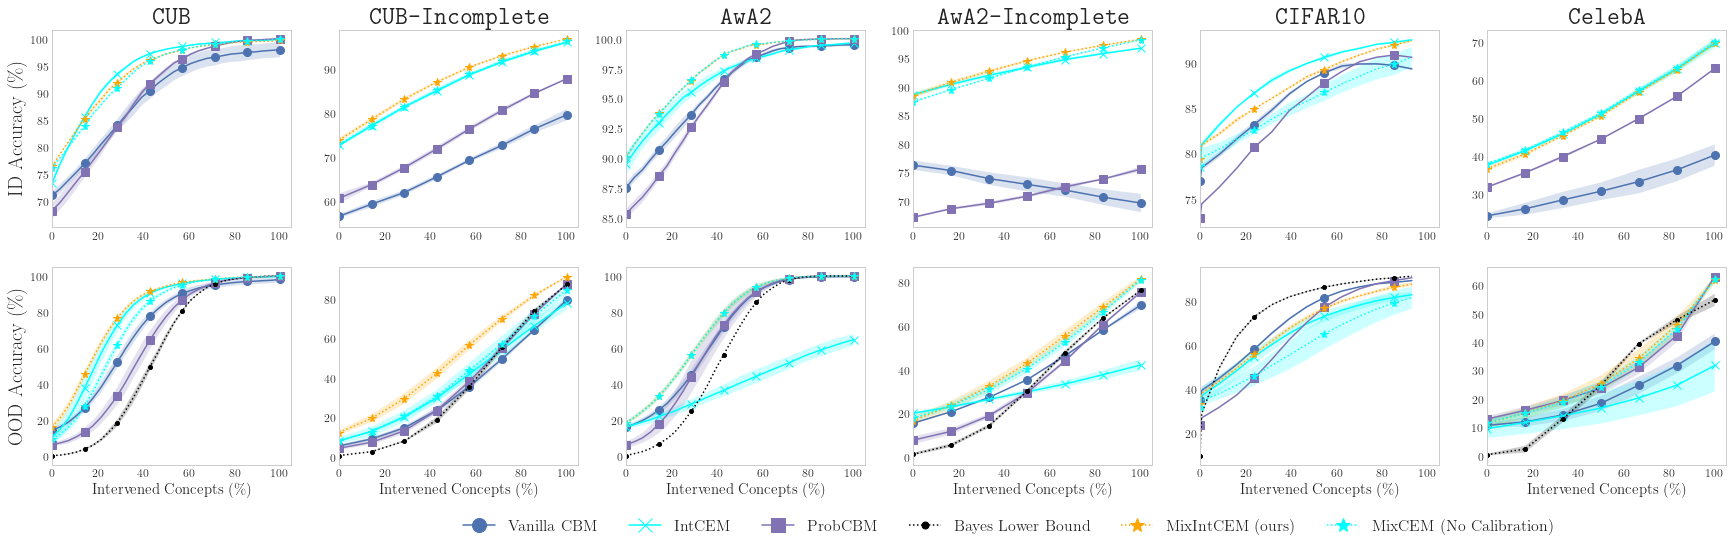

In [26]:
baselines_to_include = [
    "Joint CBM",
    "IntCEM",
    "ProbCBM",
    "Bayes MLP",
    "Entropy CMCMixIntCEM",
    "Entropy CMCMixIntCEM No Calibration",
]
used_rename_map["Entropy CMCMixIntCEM No Calibration"] = "MixCEM (No Calibration)"

fig, axs = plt.subplots(2, len(results_to_include), figsize=(5*len(results_to_include), 8), squeeze=False)
for col, dataset_results in enumerate(results_to_include):
    results = dataset_results['results']
    used_select_metric = dataset_results.get(
        'select_metric',
        select_metric,
    )
    dataset_results['selected_models'] = joblib.load(os.path.join(dataset_results['path'], f'selected_models_{used_select_metric}.joblib'))
    print("For dataset", dataset_results['name'], "we selected")
    for key, val in dataset_results['selected_models'].items():
        print(f"\t{key}: {val}")
    selected_models = dataset_results['selected_models']
    for row, (mode_name, mode_key) in enumerate([
        ("Baseline", " (Baseline)"),
        ("Baseline OOD", " (Baseline)"),
    ]):
        ax = axs[row, col]
        for idx, label in enumerate(baselines_to_include):
            label = dataset_results.get('rename', {}).get(label, label)
            model_name = selected_models.get(
                label + mode_key,
                label + mode_key,
            )
            ints = np.array(get_metric_from_dict(
                results,
                model_name,
                f"{ood_suffix if 'OOD' in mode_name else ''}test_acc_y_random_group_level_True_use_prior_False_ints",
            ))
            if len(ints) == 0:
                print("Skipping", model_name, "for", dataset_results['name'], "as we could not find any results...")
                continue
            label = used_rename_map.get(label, label)
            if ("Bayes" in label) and ("OOD" not in mode_name):
                continue
            means = np.mean(ints, axis=0) * 100
            stds = np.std(ints, axis=0) * 100
            color = color_map.get(label, clrs[idx])
            marker = markers.get(label, "-x" if "Mix" in label else "-o")
            if dataset_results.get('intervention_freq', 1) != 1:
                freq = dataset_results.get('intervention_freq', 1)
                total_concepts = (len(means) - 1) * freq
                xticks = (
                    [0] + list(100 * np.arange(1.0/total_concepts, 1, freq/total_concepts))
                )
            else:
                xticks = (
                    [0] + list(100 * np.arange(1.0/(len(means) - 1), 1, 1.0/(len(means) - 1)))
                )
            if len(means) > max_limit:
                # Then let's only plot half the points to avoid clutter
                # Make the line first
                ax.plot(
                    xticks,
                    means,
                    marker[:-1],
                    color=color,
                    label=label,
                    markersize=8,
                )
                # Then make all the points
                ax.plot(
                    xticks[::4],
                    means[::4],
                    marker[-1:],
                    color=color,
                    label=label,
                    markersize=8,
                )
            else:
                # Otherwise, plot all points
                ax.plot(
                    xticks,
                    means,
                    marker,
                    color=color,
                    label=label,
                    markersize=8,
                )

            # print(mode_name, label, "means =", means)
            if show_variance:
                ax.fill_between(
                    xticks,
                    means - stds,
                    means + stds,
                    alpha=0.2,
                    facecolor=color,
                )
        ax.set_xlim(0, 105)
        if col == 0:
            if row == 0:
                ax.set_ylabel("ID Accuracy (\%)", fontsize=20)
            else:
                ax.set_ylabel("OOD Accuracy (\%)", fontsize=20)

        if row == (axs.shape[0] - 1):
            ax.set_xlabel("Intervened Concepts (\%)", fontsize=15)
        ax.xaxis.set_tick_params(labelsize=12)
        ax.yaxis.set_tick_params(labelsize=12)
        ax.grid(False)
        if row == 0:
            ax.set_title(dataset_results['name'], fontsize=25)
        handles, labels = ax.get_legend_handles_labels()
ax.legend(
    handles,
    labels,
    fontsize=16,
    loc='upper center',
    bbox_to_anchor=(-2,-0.2),
    ncol=9,
    markerscale=1.75,
)
plt.savefig(f"../figures/all_non_ood_results_cal_vs_no_cal_all{'_variance' if show_variance else ''}.pdf", bbox_inches='tight')
plt.savefig(f"../figures/all_non_ood_results_cal_vs_no_cal_all{'_variance' if show_variance else ''}.png", bbox_inches='tight')
plt.show()

### Noise Ablation (with IntCEM losses)

For dataset CUB-Incomplete we selected
	DNN (Baseline): DNN_extra_dims_200
	Joint CBM (Baseline): CBM_Sigmoid_Baseline_cwl_1
	Hybrid-CBM (Baseline): Hybrid-CBM_Sigmoid_extra_dims_50_Baseline_cwl_1
	CEM (Baseline): CEM_Baseline_cwl_1
	IntCEM (Baseline): IntCEM_emb_size_16_intervention_weight_1_intervention_task_discount_1.1_Baseline_cwl_1
	ProbCBM (Baseline): ProbCBM_cwl_class_hidden_dim_64_hidden_dim_16_n_samples_inference_50_max_concept_epochs_70_max_task_epochs_75
	Posthoc CBM (Baseline): PCBM_reg_0.001_l1_0.99_penalty_1
	Hybrid Posthoc CBM (Baseline): HybridPCBM_reg_0.1_l1_0.99_penalty_1
	Entropy CMCMixIntCEM No Calibration (Baseline): Entropy_CMCMixIntCEM_t_1_r_1_concat_None_0_mpc_1_tmc_1_emc_50_cwc_False_ce_0_g_ood_0.1_emb_16_True_tip_0.25_itd_1.1_iw_0.1_cwl_1
	Entropy CMCMixIntCEM (Baseline): Entropy_CMCMixIntCEM_t_1_r_1_concat_None_0_mpc_1_tmc_1_emc_50_cwc_False_ce_30_g_ood_0.1_emb_16_True_tip_0.25_itd_1.1_iw_0.1_cwl_1
	Entropy CMCMixCEM No Calibration (Baseline): Entropy_CMCMix

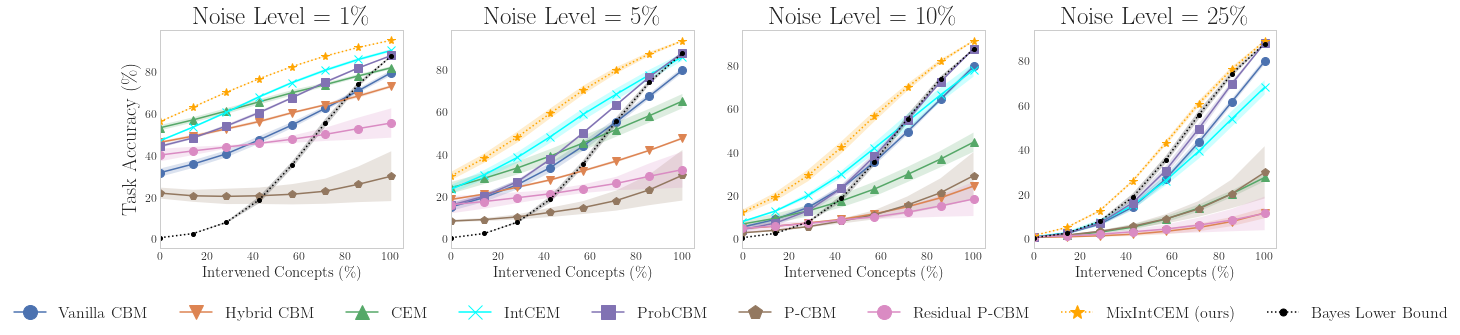

In [27]:
results_to_include = [
    dict(
        path='/anfs/bigdisc/me466/mixcem_results/cub_incomplete/',
        name='CUB-Incomplete',
        rename={'Posthoc Hybrid CBM': 'Hybrid Posthoc CBM'},
    ),
]
for res in results_to_include:
    res['results'] = joblib.load(os.path.join(res['path'], 'results.joblib'))
baselines_to_include = [
    "Joint CBM",
    "Hybrid-CBM",
    "CEM",
    "IntCEM",
    "ProbCBM",
    "Posthoc CBM",
    "Hybrid Posthoc CBM",
    "Entropy CMCMixIntCEM",
    "Bayes MLP",
]

noise_levels = [
    0.01,
    0.05,
    0.1,
    0.25,
    # 0.5,
    # 0.75,
    # 0.9,
    # 0.99,
]

dataset_results = results_to_include[0]

fig, axs = plt.subplots(1, len(noise_levels), figsize=(5*len(noise_levels), 4))
results = dataset_results['results']
used_select_metric = dataset_results.get(
    'select_metric',
    select_metric,
)
dataset_results['selected_models'] = joblib.load(os.path.join(dataset_results['path'], f'selected_models_{used_select_metric}.joblib'))
print("For dataset", dataset_results['name'], "we selected")
for key, val in dataset_results['selected_models'].items():
    print(f"\t{key}: {val}")
selected_models = dataset_results['selected_models']
for col, noise_level in enumerate(noise_levels):
    ood_suffix = f'OOD_sap_{noise_level}_'
    ax = axs[col]
    for idx, label in enumerate(baselines_to_include):
        mode_key = " (Baseline)"
        mode_name = "Baseline OOD"
        label = dataset_results.get('rename', {}).get(label, label)
        model_name = selected_models.get(
            label + mode_key,
            label + mode_key,
        )
        ints = np.array(get_metric_from_dict(
            results,
            model_name,
            f"{ood_suffix if 'OOD' in mode_name else ''}test_acc_y_random_group_level_True_use_prior_False_ints",
        ))
        if len(ints) == 0:
            print("Skipping", model_name, "for", dataset_results['name'], "as we could not find any results...")
            continue
        label = rename_map.get(label, label)
        means = np.mean(ints, axis=0) * 100
        stds = np.std(ints, axis=0) * 100
        color = color_map.get(label, clrs[idx])
        marker = markers.get(label, "-x" if "Mix" in label else "-o")
        if dataset_results.get('intervention_freq', 1) != 1:
            freq = dataset_results.get('intervention_freq', 1)
            total_concepts = (len(means) - 1) * freq
            xticks = (
                [0] + list(100 * np.arange(1.0/total_concepts, 1, freq/total_concepts))
            )
        else:
            xticks = (
                [0] + list(100 * np.arange(1.0/(len(means) - 1), 1, 1.0/(len(means) - 1)))
            )
        if len(means) > max_limit:
            # Then let's only plot half the points to avoid clutter
            # Make the line first
            ax.plot(
                xticks,
                means,
                marker[:-1],
                color=color,
                label=label,
                markersize=8,
            )
            # Then make all the points
            ax.plot(
                xticks[::4],
                means[::4],
                marker[-1:],
                color=color,
                label=label,
                markersize=8,
            )
        else:
            # Otherwise, plot all points
            ax.plot(
                xticks,
                means,
                marker,
                color=color,
                label=label,
                markersize=8,
            )
        # print(mode_name, label, "means =", means)
        if show_variance:
            ax.fill_between(
                xticks,
                means - stds,
                means + stds,
                alpha=0.2,
                facecolor=color,
            )
    ax.set_xlim(0, 105)
    if col == 0:
        ax.set_ylabel("Task Accuracy (\%)", fontsize=20)

    ax.set_xlabel("Intervened Concepts (\%)", fontsize=15)
    ax.xaxis.set_tick_params(labelsize=12)
    ax.yaxis.set_tick_params(labelsize=12)
    ax.set_title(f"Noise Level = {int(noise_level*100)}\%", fontsize=25)
    ax.grid(False)
    handles, labels = ax.get_legend_handles_labels()
ax.legend(
    handles,
    labels,
    fontsize=16,
    loc='upper center',
    bbox_to_anchor=(-1.25,-0.2),
    ncol=9,
    markerscale=1.75,
)
plt.savefig(f"../figures/noise_ablation{'_variance' if show_variance else ''}.pdf", bbox_inches='tight')
plt.savefig(f"../figures/noise_ablation{'_variance' if show_variance else ''}.png", bbox_inches='tight')
plt.show()

For dataset CUB-Incomplete we selected
	DNN (Baseline): DNN_extra_dims_200
	Joint CBM (Baseline): CBM_Sigmoid_Baseline_cwl_1
	Hybrid-CBM (Baseline): Hybrid-CBM_Sigmoid_extra_dims_50_Baseline_cwl_1
	CEM (Baseline): CEM_Baseline_cwl_1
	IntCEM (Baseline): IntCEM_emb_size_16_intervention_weight_1_intervention_task_discount_1.1_Baseline_cwl_1
	ProbCBM (Baseline): ProbCBM_cwl_class_hidden_dim_64_hidden_dim_16_n_samples_inference_50_max_concept_epochs_70_max_task_epochs_75
	Posthoc CBM (Baseline): PCBM_reg_0.001_l1_0.99_penalty_1
	Hybrid Posthoc CBM (Baseline): HybridPCBM_reg_0.1_l1_0.99_penalty_1
	Entropy CMCMixIntCEM No Calibration (Baseline): Entropy_CMCMixIntCEM_t_1_r_1_concat_None_0_mpc_1_tmc_1_emc_50_cwc_False_ce_0_g_ood_0.1_emb_16_True_tip_0.25_itd_1.1_iw_0.1_cwl_1
	Entropy CMCMixIntCEM (Baseline): Entropy_CMCMixIntCEM_t_1_r_1_concat_None_0_mpc_1_tmc_1_emc_50_cwc_False_ce_30_g_ood_0.1_emb_16_True_tip_0.25_itd_1.1_iw_0.1_cwl_1
	Entropy CMCMixCEM No Calibration (Baseline): Entropy_CMCMix

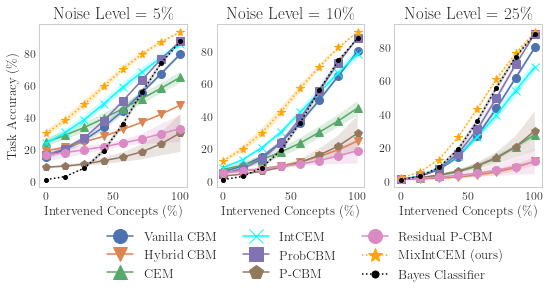

In [64]:
results_to_include = [
    dict(
        path='/anfs/bigdisc/me466/mixcem_results/cub_incomplete/',
        name='CUB-Incomplete',
        rename={'Posthoc Hybrid CBM': 'Hybrid Posthoc CBM'},
    ),
]
for res in results_to_include:
    res['results'] = joblib.load(os.path.join(res['path'], 'results.joblib'))
baselines_to_include = [
    "Joint CBM",
    "Hybrid-CBM",
    "CEM",
    "IntCEM",
    "ProbCBM",
    "Posthoc CBM",
    "Hybrid Posthoc CBM",
    "Entropy CMCMixIntCEM",
    "Bayes MLP",
]

noise_levels = [
    # 0.01,
    0.05,
    0.1,
    0.25,
    # 0.5,
    # 0.75,
    # 0.9,
    # 0.99,
]

dataset_results = results_to_include[0]

fig, axs = plt.subplots(1, len(noise_levels), figsize=(3*len(noise_levels), 3))
results = dataset_results['results']
used_select_metric = dataset_results.get(
    'select_metric',
    select_metric,
)
dataset_results['selected_models'] = joblib.load(os.path.join(dataset_results['path'], f'selected_models_{used_select_metric}.joblib'))
print("For dataset", dataset_results['name'], "we selected")
for key, val in dataset_results['selected_models'].items():
    print(f"\t{key}: {val}")
selected_models = dataset_results['selected_models']
for col, noise_level in enumerate(noise_levels):
    print("Working with noise level", noise_level)
    ood_suffix = f'OOD_sap_{noise_level}_'
    ax = axs[col]
    for idx, label in enumerate(baselines_to_include):
        mode_key = " (Baseline)"
        mode_name = "Baseline OOD"
        label = dataset_results.get('rename', {}).get(label, label)
        model_name = selected_models.get(
            label + mode_key,
            label + mode_key,
        )
        ints = np.array(get_metric_from_dict(
            results,
            model_name,
            f"{ood_suffix if 'OOD' in mode_name else ''}test_acc_y_random_group_level_True_use_prior_False_ints",
        ))
        if len(ints) == 0:
            print("Skipping", model_name, "for", dataset_results['name'], "as we could not find any results...")
            continue
        label = rename_map.get(label, label)
        means = np.mean(ints, axis=0) * 100
        stds = np.std(ints, axis=0) * 100
        color = color_map.get(label, clrs[idx])
        marker = markers.get(label, "-x" if "Mix" in label else "-o")
        if dataset_results.get('intervention_freq', 1) != 1:
            freq = dataset_results.get('intervention_freq', 1)
            total_concepts = (len(means) - 1) * freq
            xticks = (
                [0] + list(100 * np.arange(1.0/total_concepts, 1, freq/total_concepts))
            )
        else:
            xticks = (
                [0] + list(100 * np.arange(1.0/(len(means) - 1), 1, 1.0/(len(means) - 1)))
            )
        if len(means) > max_limit:
            # Then let's only plot half the points to avoid clutter
            # Make the line first
            ax.plot(
                xticks,
                means,
                marker[:-1],
                color=color,
                label=label,
                markersize=8,
            )
            # Then make all the points
            ax.plot(
                xticks[::4],
                means[::4],
                marker[-1:],
                color=color,
                label=label,
                markersize=8,
            )
        else:
            # Otherwise, plot all points
            ax.plot(
                xticks,
                means,
                marker,
                color=color,
                label=label,
                markersize=8,
            )
        # print(mode_name, label, "means =", means)
        if show_variance:
            ax.fill_between(
                xticks,
                means - stds,
                means + stds,
                alpha=0.2,
                facecolor=color,
            )
        print("\t", label, f"has unintervened performance {means[0]:.2f} ± {stds[0]:.2f} %")
    ax.set_xlim(-5, 105)
    if col == 0:
        ax.set_ylabel("Task Accuracy (\%)", fontsize=13)

    ax.set_xlabel("Intervened Concepts (\%)", fontsize=13)
    ax.xaxis.set_tick_params(labelsize=12)
    ax.yaxis.set_tick_params(labelsize=12)
    ax.set_title(f"Noise Level = {int(noise_level*100)}\%", fontsize=20-3)
    ax.grid(False)
    handles, labels = ax.get_legend_handles_labels()
ax.legend(
    handles,
    labels,
    fontsize=13,
    loc='upper center',
    bbox_to_anchor=(-0.6,-0.2),
    ncol=3,
    markerscale=1.75,
)
plt.savefig(f"../figures/noise_ablation_small{'_variance' if show_variance else ''}.pdf", bbox_inches='tight')
plt.savefig(f"../figures/noise_ablation_small{'_variance' if show_variance else ''}.png", bbox_inches='tight')
plt.show()

For dataset CUB-Incomplete we selected
	DNN (Baseline): DNN_extra_dims_200
	Joint CBM (Baseline): CBM_Sigmoid_Baseline_cwl_1
	Hybrid-CBM (Baseline): Hybrid-CBM_Sigmoid_extra_dims_50_Baseline_cwl_1
	CEM (Baseline): CEM_Baseline_cwl_1
	IntCEM (Baseline): IntCEM_emb_size_16_intervention_weight_1_intervention_task_discount_1.1_Baseline_cwl_1
	ProbCBM (Baseline): ProbCBM_cwl_class_hidden_dim_64_hidden_dim_16_n_samples_inference_50_max_concept_epochs_70_max_task_epochs_75
	Posthoc CBM (Baseline): PCBM_reg_0.001_l1_0.99_penalty_1
	Hybrid Posthoc CBM (Baseline): HybridPCBM_reg_0.1_l1_0.99_penalty_1
	Entropy CMCMixIntCEM No Calibration (Baseline): Entropy_CMCMixIntCEM_t_1_r_1_concat_None_0_mpc_1_tmc_1_emc_50_cwc_False_ce_0_g_ood_0.1_emb_16_True_tip_0.25_itd_1.1_iw_0.1_cwl_1
	Entropy CMCMixIntCEM (Baseline): Entropy_CMCMixIntCEM_t_1_r_1_concat_None_0_mpc_1_tmc_1_emc_50_cwc_False_ce_30_g_ood_0.1_emb_16_True_tip_0.25_itd_1.1_iw_0.1_cwl_1
	Entropy CMCMixCEM No Calibration (Baseline): Entropy_CMCMix

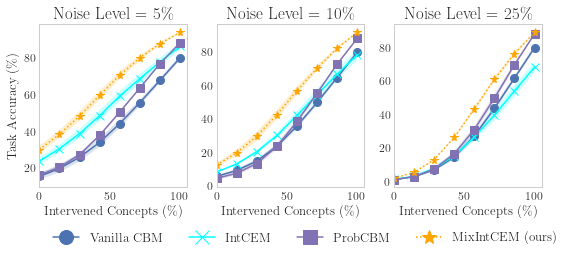

In [29]:
results_to_include = [
    dict(
        path='/anfs/bigdisc/me466/mixcem_results/cub_incomplete/',
        name='CUB-Incomplete',
        rename={'Posthoc Hybrid CBM': 'Hybrid Posthoc CBM'},
    ),
]
for res in results_to_include:
    res['results'] = joblib.load(os.path.join(res['path'], 'results.joblib'))
baselines_to_include = [
    "Joint CBM",
    # "Hybrid-CBM",
    # "CEM",
    "IntCEM",
    "ProbCBM",
    # "Posthoc CBM",
    # "Hybrid Posthoc CBM",
    "Entropy CMCMixIntCEM",
    # "Bayes MLP",
]

noise_levels = [
    # 0.01,
    0.05,
    0.1,
    0.25,
    # 0.5,
    # 0.75,
    # 0.9,
    # 0.99,
]

dataset_results = results_to_include[0]

fig, axs = plt.subplots(1, len(noise_levels), figsize=(3*len(noise_levels), 3))
results = dataset_results['results']
used_select_metric = dataset_results.get(
    'select_metric',
    select_metric,
)
dataset_results['selected_models'] = joblib.load(os.path.join(dataset_results['path'], f'selected_models_{used_select_metric}.joblib'))
print("For dataset", dataset_results['name'], "we selected")
for key, val in dataset_results['selected_models'].items():
    print(f"\t{key}: {val}")
selected_models = dataset_results['selected_models']
for col, noise_level in enumerate(noise_levels):
    ood_suffix = f'OOD_sap_{noise_level}_'
    ax = axs[col]
    for idx, label in enumerate(baselines_to_include):
        mode_key = " (Baseline)"
        mode_name = "Baseline OOD"
        label = dataset_results.get('rename', {}).get(label, label)
        model_name = selected_models.get(
            label + mode_key,
            label + mode_key,
        )
        ints = np.array(get_metric_from_dict(
            results,
            model_name,
            f"{ood_suffix if 'OOD' in mode_name else ''}test_acc_y_random_group_level_True_use_prior_False_ints",
        ))
        if len(ints) == 0:
            print("Skipping", model_name, "for", dataset_results['name'], "as we could not find any results...")
            continue
        label = rename_map.get(label, label)
        means = np.mean(ints, axis=0) * 100
        stds = np.std(ints, axis=0) * 100
        color = color_map.get(label, clrs[idx])
        marker = markers.get(label, "-x" if "Mix" in label else "-o")
        if dataset_results.get('intervention_freq', 1) != 1:
            freq = dataset_results.get('intervention_freq', 1)
            total_concepts = (len(means) - 1) * freq
            xticks = (
                [0] + list(100 * np.arange(1.0/total_concepts, 1, freq/total_concepts))
            )
        else:
            xticks = (
                [0] + list(100 * np.arange(1.0/(len(means) - 1), 1, 1.0/(len(means) - 1)))
            )
        if len(means) > max_limit:
            # Then let's only plot half the points to avoid clutter
            # Make the line first
            ax.plot(
                xticks,
                means,
                marker[:-1],
                color=color,
                label=label,
                markersize=8,
            )
            # Then make all the points
            ax.plot(
                xticks[::4],
                means[::4],
                marker[-1:],
                color=color,
                label=label,
                markersize=8,
            )
        else:
            # Otherwise, plot all points
            ax.plot(
                xticks,
                means,
                marker,
                color=color,
                label=label,
                markersize=8,
            )
        # print(mode_name, label, "means =", means)
        if show_variance:
            ax.fill_between(
                xticks,
                means - stds,
                means + stds,
                alpha=0.2,
                facecolor=color,
            )
    ax.set_xlim(0, 105)
    if col == 0:
        ax.set_ylabel("Task Accuracy (\%)", fontsize=13)

    ax.set_xlabel("Intervened Concepts (\%)", fontsize=13)
    ax.xaxis.set_tick_params(labelsize=12)
    ax.yaxis.set_tick_params(labelsize=12)
    ax.set_title(f"Noise Level = {int(noise_level*100)}\%", fontsize=20-3)
    ax.grid(False)
    handles, labels = ax.get_legend_handles_labels()
ax.legend(
    handles,
    labels,
    fontsize=13,
    loc='upper center',
    bbox_to_anchor=(-0.6,-0.2),
    ncol=4,
    markerscale=1.75,
)
plt.savefig(f"../figures/noise_ablation_smaller{'_variance' if show_variance else ''}.pdf", bbox_inches='tight')
plt.savefig(f"../figures/noise_ablation_smaller{'_variance' if show_variance else ''}.png", bbox_inches='tight')
plt.show()

For dataset CUB-Incomplete we selected
	DNN (Baseline): DNN_extra_dims_200
	Joint CBM (Baseline): CBM_Sigmoid_Baseline_cwl_1
	Hybrid-CBM (Baseline): Hybrid-CBM_Sigmoid_extra_dims_50_Baseline_cwl_1
	CEM (Baseline): CEM_Baseline_cwl_1
	IntCEM (Baseline): IntCEM_emb_size_16_intervention_weight_1_intervention_task_discount_1.1_Baseline_cwl_1
	ProbCBM (Baseline): ProbCBM_cwl_class_hidden_dim_64_hidden_dim_16_n_samples_inference_50_max_concept_epochs_70_max_task_epochs_75
	Posthoc CBM (Baseline): PCBM_reg_0.001_l1_0.99_penalty_1
	Hybrid Posthoc CBM (Baseline): HybridPCBM_reg_0.1_l1_0.99_penalty_1
	Entropy CMCMixIntCEM No Calibration (Baseline): Entropy_CMCMixIntCEM_t_1_r_1_concat_None_0_mpc_1_tmc_1_emc_50_cwc_False_ce_0_g_ood_0.1_emb_16_True_tip_0.25_itd_1.1_iw_0.1_cwl_1
	Entropy CMCMixIntCEM (Baseline): Entropy_CMCMixIntCEM_t_1_r_1_concat_None_0_mpc_1_tmc_1_emc_50_cwc_False_ce_30_g_ood_0.1_emb_16_True_tip_0.25_itd_1.1_iw_0.1_cwl_1
	Entropy CMCMixCEM No Calibration (Baseline): Entropy_CMCMix

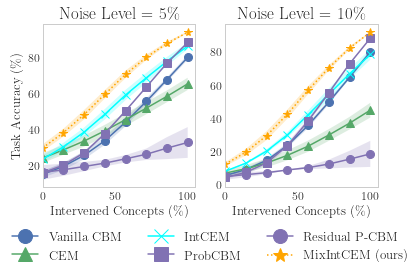

In [30]:
results_to_include = [
    dict(
        path='/anfs/bigdisc/me466/mixcem_results/cub_incomplete/',
        name='CUB-Incomplete',
        rename={'Posthoc Hybrid CBM': 'Hybrid Posthoc CBM'},
    ),
]
for res in results_to_include:
    res['results'] = joblib.load(os.path.join(res['path'], 'results.joblib'))
baselines_to_include = [
    "Joint CBM",
    # "Hybrid-CBM",
    "CEM",
    "IntCEM",
    "ProbCBM",
    # "Posthoc CBM",
    "Hybrid Posthoc CBM",
    "Entropy CMCMixIntCEM",
    # "Bayes MLP",
]

noise_levels = [
    # 0.01,
    0.05,
    0.1,
    # 0.25,
    # 0.5,
    # 0.75,
    # 0.9,
    # 0.99,
]

dataset_results = results_to_include[0]

fig, axs = plt.subplots(1, len(noise_levels), figsize=(3*len(noise_levels), 3))
results = dataset_results['results']
used_select_metric = dataset_results.get(
    'select_metric',
    select_metric,
)
dataset_results['selected_models'] = joblib.load(os.path.join(dataset_results['path'], f'selected_models_{used_select_metric}.joblib'))
print("For dataset", dataset_results['name'], "we selected")
for key, val in dataset_results['selected_models'].items():
    print(f"\t{key}: {val}")
selected_models = dataset_results['selected_models']
for col, noise_level in enumerate(noise_levels):
    ood_suffix = f'OOD_sap_{noise_level}_'
    ax = axs[col]
    for idx, label in enumerate(baselines_to_include):
        mode_key = " (Baseline)"
        mode_name = "Baseline OOD"
        label = dataset_results.get('rename', {}).get(label, label)
        model_name = selected_models.get(
            label + mode_key,
            label + mode_key,
        )
        ints = np.array(get_metric_from_dict(
            results,
            model_name,
            f"{ood_suffix if 'OOD' in mode_name else ''}test_acc_y_random_group_level_True_use_prior_False_ints",
        ))
        if len(ints) == 0:
            print("Skipping", model_name, "for", dataset_results['name'], "as we could not find any results...")
            continue
        label = rename_map.get(label, label)
        means = np.mean(ints, axis=0) * 100
        stds = np.std(ints, axis=0) * 100
        color = color_map.get(label, clrs[idx])
        marker = markers.get(label, "-x" if "Mix" in label else "-o")
        if dataset_results.get('intervention_freq', 1) != 1:
            freq = dataset_results.get('intervention_freq', 1)
            total_concepts = (len(means) - 1) * freq
            xticks = (
                [0] + list(100 * np.arange(1.0/total_concepts, 1, freq/total_concepts))
            )
        else:
            xticks = (
                [0] + list(100 * np.arange(1.0/(len(means) - 1), 1, 1.0/(len(means) - 1)))
            )
        if len(means) > max_limit:
            # Then let's only plot half the points to avoid clutter
            # Make the line first
            ax.plot(
                xticks,
                means,
                marker[:-1],
                color=color,
                label=label,
                markersize=8,
            )
            # Then make all the points
            ax.plot(
                xticks[::4],
                means[::4],
                marker[-1:],
                color=color,
                label=label,
                markersize=8,
            )
        else:
            # Otherwise, plot all points
            ax.plot(
                xticks,
                means,
                marker,
                color=color,
                label=label,
                markersize=8,
            )
        # print(mode_name, label, "means =", means)
        if show_variance:
            ax.fill_between(
                xticks,
                means - stds,
                means + stds,
                alpha=0.2,
                facecolor=color,
            )
    ax.set_xlim(0, 105)
    if col == 0:
        ax.set_ylabel("Task Accuracy (\%)", fontsize=13)

    ax.set_xlabel("Intervened Concepts (\%)", fontsize=13)
    ax.xaxis.set_tick_params(labelsize=12)
    ax.yaxis.set_tick_params(labelsize=12)
    ax.set_title(f"Noise Level = {int(noise_level*100)}\%", fontsize=20-3)
    ax.grid(False)
    handles, labels = ax.get_legend_handles_labels()
ax.legend(
    handles,
    labels,
    fontsize=13,
    loc='upper center',
    bbox_to_anchor=(-0.1,-0.2),
    ncol=3,
    markerscale=1.75,
)
plt.savefig(f"../figures/noise_ablation_tiny{'_variance' if show_variance else ''}.pdf", bbox_inches='tight')
plt.savefig(f"../figures/noise_ablation_tiny{'_variance' if show_variance else ''}.png", bbox_inches='tight')
plt.show()

For dataset CUB-Incomplete we selected
	DNN (Baseline): DNN_extra_dims_200
	Joint CBM (Baseline): CBM_Sigmoid_Baseline_cwl_1
	Hybrid-CBM (Baseline): Hybrid-CBM_Sigmoid_extra_dims_50_Baseline_cwl_1
	CEM (Baseline): CEM_Baseline_cwl_1
	IntCEM (Baseline): IntCEM_emb_size_16_intervention_weight_1_intervention_task_discount_1.1_Baseline_cwl_1
	ProbCBM (Baseline): ProbCBM_cwl_class_hidden_dim_64_hidden_dim_16_n_samples_inference_50_max_concept_epochs_70_max_task_epochs_75
	Posthoc CBM (Baseline): PCBM_reg_0.001_l1_0.99_penalty_1
	Hybrid Posthoc CBM (Baseline): HybridPCBM_reg_0.1_l1_0.99_penalty_1
	Entropy CMCMixIntCEM No Calibration (Baseline): Entropy_CMCMixIntCEM_t_1_r_1_concat_None_0_mpc_1_tmc_1_emc_50_cwc_False_ce_0_g_ood_0.1_emb_16_True_tip_0.25_itd_1.1_iw_0.1_cwl_1
	Entropy CMCMixIntCEM (Baseline): Entropy_CMCMixIntCEM_t_1_r_1_concat_None_0_mpc_1_tmc_1_emc_50_cwc_False_ce_30_g_ood_0.1_emb_16_True_tip_0.25_itd_1.1_iw_0.1_cwl_1
	Entropy CMCMixCEM No Calibration (Baseline): Entropy_CMCMix

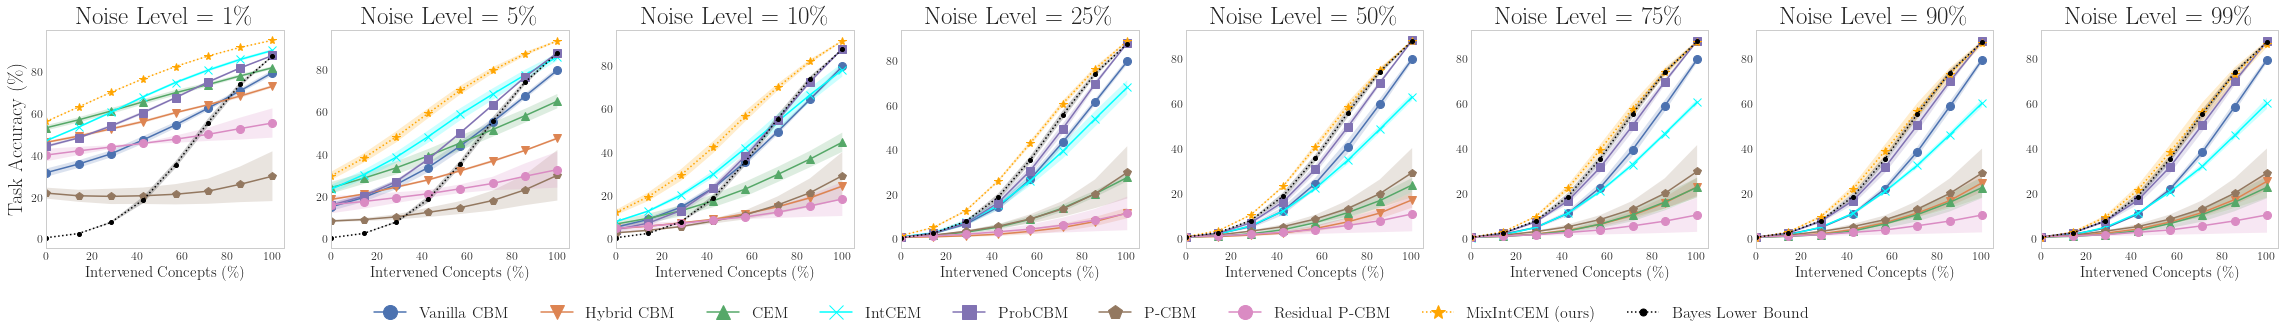

In [31]:
results_to_include = [
    dict(
        path='/anfs/bigdisc/me466/mixcem_results/cub_incomplete/',
        name='CUB-Incomplete',
        rename={'Posthoc Hybrid CBM': 'Hybrid Posthoc CBM'},
    ),
]
for res in results_to_include:
    res['results'] = joblib.load(os.path.join(res['path'], 'results.joblib'))
baselines_to_include = [
    "Joint CBM",
    "Hybrid-CBM",
    "CEM",
    "IntCEM",
    "ProbCBM",
    "Posthoc CBM",
    "Hybrid Posthoc CBM",
    "Entropy CMCMixIntCEM",
    "Bayes MLP",
]
noise_levels = [
    0.01,
    0.05,
    0.1,
    0.25,
    0.5,
    0.75,
    0.9,
    0.99,
]

dataset_results = results_to_include[0]

fig, axs = plt.subplots(1, len(noise_levels), figsize=(5*len(noise_levels), 4))
results = dataset_results['results']
used_select_metric = dataset_results.get(
    'select_metric',
    select_metric,
)
dataset_results['selected_models'] = joblib.load(os.path.join(dataset_results['path'], f'selected_models_{used_select_metric}.joblib'))
print("For dataset", dataset_results['name'], "we selected")
for key, val in dataset_results['selected_models'].items():
    print(f"\t{key}: {val}")
selected_models = dataset_results['selected_models']
for col, noise_level in enumerate(noise_levels):
    ood_suffix = f'OOD_sap_{noise_level}_'
    ax = axs[col]
    for idx, label in enumerate(baselines_to_include):
        mode_key = " (Baseline)"
        mode_name = "Baseline OOD"
        label = dataset_results.get('rename', {}).get(label, label)
        model_name = selected_models.get(
            label + mode_key,
            label + mode_key,
        )
        ints = np.array(get_metric_from_dict(
            results,
            model_name,
            f"{ood_suffix if 'OOD' in mode_name else ''}test_acc_y_random_group_level_True_use_prior_False_ints",
        ))
        if len(ints) == 0:
            print("Skipping", model_name, "for", dataset_results['name'], "as we could not find any results...")
            continue
        label = rename_map.get(label, label)
        means = np.mean(ints, axis=0) * 100
        stds = np.std(ints, axis=0) * 100
        color = color_map.get(label, clrs[idx])
        marker = markers.get(label, "-x" if "Mix" in label else "-o")
        if dataset_results.get('intervention_freq', 1) != 1:
            freq = dataset_results.get('intervention_freq', 1)
            total_concepts = (len(means) - 1) * freq
            xticks = (
                [0] + list(100 * np.arange(1.0/total_concepts, 1, freq/total_concepts))
            )
        else:
            xticks = (
                [0] + list(100 * np.arange(1.0/(len(means) - 1), 1, 1.0/(len(means) - 1)))
            )
        if len(means) > max_limit:
            # Then let's only plot half the points to avoid clutter
            # Make the line first
            ax.plot(
                xticks,
                means,
                marker[:-1],
                color=color,
                label=label,
                markersize=8,
            )
            # Then make all the points
            ax.plot(
                xticks[::4],
                means[::4],
                marker[-1:],
                color=color,
                label=label,
                markersize=8,
            )
        else:
            # Otherwise, plot all points
            ax.plot(
                xticks,
                means,
                marker,
                color=color,
                label=label,
                markersize=8,
            )
        # print(mode_name, label, "means =", means)
        if show_variance:
            ax.fill_between(
                xticks,
                means - stds,
                means + stds,
                alpha=0.2,
                facecolor=color,
            )
    ax.set_xlim(0, 105)
    if col == 0:
        ax.set_ylabel("Task Accuracy (\%)", fontsize=20)

    ax.set_xlabel("Intervened Concepts (\%)", fontsize=15)
    ax.xaxis.set_tick_params(labelsize=12)
    ax.yaxis.set_tick_params(labelsize=12)
    ax.grid(False)
    ax.set_title(f"Noise Level = {int(noise_level*100)}\%", fontsize=25)
    handles, labels = ax.get_legend_handles_labels()
ax.legend(
    handles,
    labels,
    fontsize=16,
    loc='upper center',
    bbox_to_anchor=(-4,-0.2),
    ncol=9,
    markerscale=1.75,
)
plt.savefig(f"../figures/noise_ablation_complete{'_variance' if show_variance else ''}.pdf", bbox_inches='tight')
plt.savefig(f"../figures/noise_ablation_complete{'_variance' if show_variance else ''}.png", bbox_inches='tight')
plt.show()

## Noise Ablation (without IntCEM's Losses)

For dataset CUB-Incomplete we selected
	DNN (Baseline): DNN_extra_dims_200
	Joint CBM (Baseline): CBM_Sigmoid_Baseline_cwl_1
	Hybrid-CBM (Baseline): Hybrid-CBM_Sigmoid_extra_dims_50_Baseline_cwl_1
	CEM (Baseline): CEM_Baseline_cwl_1
	IntCEM (Baseline): IntCEM_emb_size_16_intervention_weight_1_intervention_task_discount_1.1_Baseline_cwl_1
	ProbCBM (Baseline): ProbCBM_cwl_class_hidden_dim_64_hidden_dim_16_n_samples_inference_50_max_concept_epochs_70_max_task_epochs_75
	Posthoc CBM (Baseline): PCBM_reg_0.001_l1_0.99_penalty_1
	Hybrid Posthoc CBM (Baseline): HybridPCBM_reg_0.1_l1_0.99_penalty_1
	Entropy CMCMixIntCEM No Calibration (Baseline): Entropy_CMCMixIntCEM_t_1_r_1_concat_None_0_mpc_1_tmc_1_emc_50_cwc_False_ce_0_g_ood_0.1_emb_16_True_tip_0.25_itd_1.1_iw_0.1_cwl_1
	Entropy CMCMixIntCEM (Baseline): Entropy_CMCMixIntCEM_t_1_r_1_concat_None_0_mpc_1_tmc_1_emc_50_cwc_False_ce_30_g_ood_0.1_emb_16_True_tip_0.25_itd_1.1_iw_0.1_cwl_1
	Entropy CMCMixCEM No Calibration (Baseline): Entropy_CMCMix

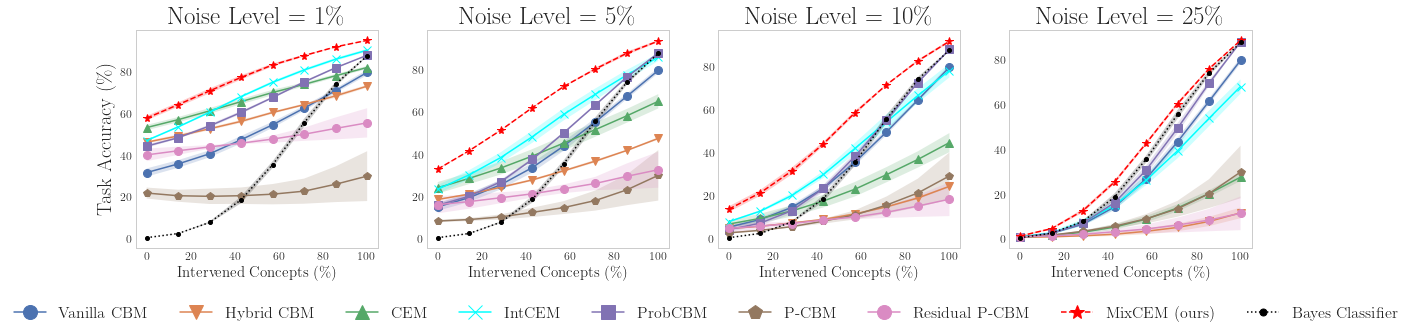

In [66]:
results_to_include = [
    dict(
        path='/anfs/bigdisc/me466/mixcem_results/cub_incomplete/',
        name='CUB-Incomplete',
        rename={'Posthoc Hybrid CBM': 'Hybrid Posthoc CBM'},
    ),
]
for res in results_to_include:
    res['results'] = joblib.load(os.path.join(res['path'], 'results.joblib'))
baselines_to_include = [
    "Joint CBM",
    "Hybrid-CBM",
    "CEM",
    "IntCEM",
    "ProbCBM",
    "Posthoc CBM",
    "Hybrid Posthoc CBM",
    "Entropy CMCMixCEM",
    "Bayes MLP",
]

noise_levels = [
    0.01,
    0.05,
    0.1,
    0.25,
    # 0.5,
    # 0.75,
    # 0.9,
    # 0.99,
]

dataset_results = results_to_include[0]

fig, axs = plt.subplots(1, len(noise_levels), figsize=(5*len(noise_levels), 4))
results = dataset_results['results']
used_select_metric = dataset_results.get(
    'select_metric',
    select_metric,
)
dataset_results['selected_models'] = joblib.load(os.path.join(dataset_results['path'], f'selected_models_{used_select_metric}.joblib'))
print("For dataset", dataset_results['name'], "we selected")
for key, val in dataset_results['selected_models'].items():
    print(f"\t{key}: {val}")
selected_models = dataset_results['selected_models']
for col, noise_level in enumerate(noise_levels):
    ood_suffix = f'OOD_sap_{noise_level}_'
    ax = axs[col]
    for idx, label in enumerate(baselines_to_include):
        mode_key = " (Baseline)"
        mode_name = "Baseline OOD"
        label = dataset_results.get('rename', {}).get(label, label)
        model_name = selected_models.get(
            label + mode_key,
            label + mode_key,
        )
        ints = np.array(get_metric_from_dict(
            results,
            model_name,
            f"{ood_suffix if 'OOD' in mode_name else ''}test_acc_y_random_group_level_True_use_prior_False_ints",
        ))
        if len(ints) == 0:
            print("Skipping", model_name, "for", dataset_results['name'], "as we could not find any results...")
            continue
        label = used_rename_map.get(label, label)
        means = np.mean(ints, axis=0) * 100
        stds = np.std(ints, axis=0) * 100
        color = color_map.get(label, clrs[idx])
        marker = markers.get(label, "-x" if "Mix" in label else "-o")
        if dataset_results.get('intervention_freq', 1) != 1:
            freq = dataset_results.get('intervention_freq', 1)
            total_concepts = (len(means) - 1) * freq
            xticks = (
                [0] + list(100 * np.arange(1.0/total_concepts, 1, freq/total_concepts))
            )
        else:
            xticks = (
                [0] + list(100 * np.arange(1.0/(len(means) - 1), 1, 1.0/(len(means) - 1)))
            )
        if len(means) > max_limit:
            # Then let's only plot half the points to avoid clutter
            # Make the line first
            ax.plot(
                xticks,
                means,
                marker[:-1],
                color=color,
                label=label,
                markersize=8,
            )
            # Then make all the points
            ax.plot(
                xticks[::4],
                means[::4],
                marker[-1:],
                color=color,
                label=label,
                markersize=8,
            )
        else:
            # Otherwise, plot all points
            ax.plot(
                xticks,
                means,
                marker,
                color=color,
                label=label,
                markersize=8,
            )
        # print(mode_name, label, "means =", means)
        if show_variance:
            ax.fill_between(
                xticks,
                means - stds,
                means + stds,
                alpha=0.2,
                facecolor=color,
            )
    ax.set_xlim(-5, 105)
    if col == 0:
        ax.set_ylabel("Task Accuracy (\%)", fontsize=20)

    ax.set_xlabel("Intervened Concepts (\%)", fontsize=15)
    ax.xaxis.set_tick_params(labelsize=12)
    ax.yaxis.set_tick_params(labelsize=12)
    ax.set_title(f"Noise Level = {int(noise_level*100)}\%", fontsize=25)
    ax.grid(False)
    handles, labels = ax.get_legend_handles_labels()
ax.legend(
    handles,
    labels,
    fontsize=16,
    loc='upper center',
    bbox_to_anchor=(-1.25,-0.2),
    ncol=9,
    markerscale=1.75,
)
plt.savefig(f"../figures/noise_ablation_true_mixcem{'_variance' if show_variance else ''}.pdf", bbox_inches='tight')
plt.savefig(f"../figures/noise_ablation_true_mixcem{'_variance' if show_variance else ''}.png", bbox_inches='tight')
plt.show()

For dataset CUB-Incomplete we selected
	DNN (Baseline): DNN_extra_dims_200
	Joint CBM (Baseline): CBM_Sigmoid_Baseline_cwl_1
	Hybrid-CBM (Baseline): Hybrid-CBM_Sigmoid_extra_dims_50_Baseline_cwl_1
	CEM (Baseline): CEM_Baseline_cwl_1
	IntCEM (Baseline): IntCEM_emb_size_16_intervention_weight_1_intervention_task_discount_1.1_Baseline_cwl_1
	ProbCBM (Baseline): ProbCBM_cwl_class_hidden_dim_64_hidden_dim_16_n_samples_inference_50_max_concept_epochs_70_max_task_epochs_75
	Posthoc CBM (Baseline): PCBM_reg_0.001_l1_0.99_penalty_1
	Hybrid Posthoc CBM (Baseline): HybridPCBM_reg_0.1_l1_0.99_penalty_1
	Entropy CMCMixIntCEM No Calibration (Baseline): Entropy_CMCMixIntCEM_t_1_r_1_concat_None_0_mpc_1_tmc_1_emc_50_cwc_False_ce_0_g_ood_0.1_emb_16_True_tip_0.25_itd_1.1_iw_0.1_cwl_1
	Entropy CMCMixIntCEM (Baseline): Entropy_CMCMixIntCEM_t_1_r_1_concat_None_0_mpc_1_tmc_1_emc_50_cwc_False_ce_30_g_ood_0.1_emb_16_True_tip_0.25_itd_1.1_iw_0.1_cwl_1
	Entropy CMCMixCEM No Calibration (Baseline): Entropy_CMCMix

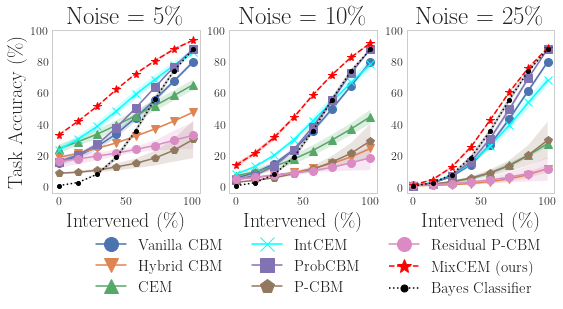

In [65]:
results_to_include = [
    dict(
        path='/anfs/bigdisc/me466/mixcem_results/cub_incomplete/',
        name='CUB-Incomplete',
        rename={'Posthoc Hybrid CBM': 'Hybrid Posthoc CBM'},
    ),
]
for res in results_to_include:
    res['results'] = joblib.load(os.path.join(res['path'], 'results.joblib'))
baselines_to_include = [
    "Joint CBM",
    "Hybrid-CBM",
    "CEM",
    "IntCEM",
    "ProbCBM",
    "Posthoc CBM",
    "Hybrid Posthoc CBM",
    "Entropy CMCMixCEM",
    "Bayes MLP",
]

noise_levels = [
    # 0.01,
    0.05,
    0.1,
    0.25,
    # 0.5,
    # 0.75,
    # 0.9,
    # 0.99,
]

dataset_results = results_to_include[0]

fig, axs = plt.subplots(1, len(noise_levels), figsize=(3*len(noise_levels), 3))
results = dataset_results['results']
used_select_metric = dataset_results.get(
    'select_metric',
    select_metric,
)
dataset_results['selected_models'] = joblib.load(os.path.join(dataset_results['path'], f'selected_models_{used_select_metric}.joblib'))
print("For dataset", dataset_results['name'], "we selected")
for key, val in dataset_results['selected_models'].items():
    print(f"\t{key}: {val}")
selected_models = dataset_results['selected_models']
for col, noise_level in enumerate(noise_levels):
    ood_suffix = f'OOD_sap_{noise_level}_'
    ax = axs[col]
    for idx, label in enumerate(baselines_to_include):
        mode_key = " (Baseline)"
        mode_name = "Baseline OOD"
        label = dataset_results.get('rename', {}).get(label, label)
        model_name = selected_models.get(
            label + mode_key,
            label + mode_key,
        )
        ints = np.array(get_metric_from_dict(
            results,
            model_name,
            f"{ood_suffix if 'OOD' in mode_name else ''}test_acc_y_random_group_level_True_use_prior_False_ints",
        ))
        if len(ints) == 0:
            print("Skipping", model_name, "for", dataset_results['name'], "as we could not find any results...")
            continue
        label = used_rename_map.get(label, label)
        means = np.mean(ints, axis=0) * 100
        stds = np.std(ints, axis=0) * 100
        color = color_map.get(label, clrs[idx])
        marker = markers.get(label, "-x" if "Mix" in label else "-o")
        if dataset_results.get('intervention_freq', 1) != 1:
            freq = dataset_results.get('intervention_freq', 1)
            total_concepts = (len(means) - 1) * freq
            xticks = (
                [0] + list(100 * np.arange(1.0/total_concepts, 1, freq/total_concepts))
            )
        else:
            xticks = (
                [0] + list(100 * np.arange(1.0/(len(means) - 1), 1, 1.0/(len(means) - 1)))
            )
        if len(means) > max_limit:
            # Then let's only plot half the points to avoid clutter
            # Make the line first
            ax.plot(
                xticks,
                means,
                marker[:-1],
                color=color,
                label=label,
                markersize=8,
            )
            # Then make all the points
            ax.plot(
                xticks[::4],
                means[::4],
                marker[-1:],
                color=color,
                label=label,
                markersize=8,
            )
        else:
            # Otherwise, plot all points
            ax.plot(
                xticks,
                means,
                marker,
                color=color,
                label=label,
                markersize=8,
            )
        # print(mode_name, label, "means =", means)
        if show_variance:
            ax.fill_between(
                xticks,
                means - stds,
                means + stds,
                alpha=0.2,
                facecolor=color,
            )
    ax.set_xlim(-5, 105)
    if col == 0:
        ax.set_ylabel("Task Accuracy (\%)", fontsize=20)

    ax.set_xlabel("Intervened (\%)", fontsize=20)
    ax.xaxis.set_tick_params(labelsize=12)
    ax.yaxis.set_tick_params(labelsize=12)
    ax.set_yticks(range(0, 101, 20))
    ax.set_title(f"Noise = {int(noise_level*100)}\%", fontsize=25)
    ax.grid(False)
    handles, labels = ax.get_legend_handles_labels()

ax.legend(
    handles,
    labels,
    fontsize=15,
    loc='upper center',
    bbox_to_anchor=(-0.6,-0.2),
    ncol=3,
    markerscale=1.75,
)
plt.savefig(f"../figures/noise_ablation_small_true_mixcem{'_variance' if show_variance else ''}.pdf", bbox_inches='tight')
plt.savefig(f"../figures/noise_ablation_small_true_mixcem{'_variance' if show_variance else ''}.png", bbox_inches='tight')
plt.show()

For dataset CUB-Incomplete we selected
	DNN (Baseline): DNN_extra_dims_200
	Joint CBM (Baseline): CBM_Sigmoid_Baseline_cwl_1
	Hybrid-CBM (Baseline): Hybrid-CBM_Sigmoid_extra_dims_50_Baseline_cwl_1
	CEM (Baseline): CEM_Baseline_cwl_1
	IntCEM (Baseline): IntCEM_emb_size_16_intervention_weight_1_intervention_task_discount_1.1_Baseline_cwl_1
	ProbCBM (Baseline): ProbCBM_cwl_class_hidden_dim_64_hidden_dim_16_n_samples_inference_50_max_concept_epochs_70_max_task_epochs_75
	Posthoc CBM (Baseline): PCBM_reg_0.001_l1_0.99_penalty_1
	Hybrid Posthoc CBM (Baseline): HybridPCBM_reg_0.1_l1_0.99_penalty_1
	Entropy CMCMixIntCEM No Calibration (Baseline): Entropy_CMCMixIntCEM_t_1_r_1_concat_None_0_mpc_1_tmc_1_emc_50_cwc_False_ce_0_g_ood_0.1_emb_16_True_tip_0.25_itd_1.1_iw_0.1_cwl_1
	Entropy CMCMixIntCEM (Baseline): Entropy_CMCMixIntCEM_t_1_r_1_concat_None_0_mpc_1_tmc_1_emc_50_cwc_False_ce_30_g_ood_0.1_emb_16_True_tip_0.25_itd_1.1_iw_0.1_cwl_1
	Entropy CMCMixCEM No Calibration (Baseline): Entropy_CMCMix

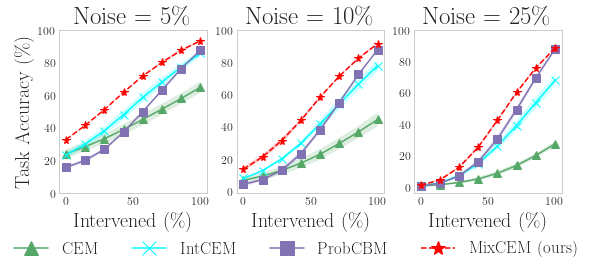

In [67]:
results_to_include = [
    dict(
        path='/anfs/bigdisc/me466/mixcem_results/cub_incomplete/',
        name='CUB-Incomplete',
        rename={'Posthoc Hybrid CBM': 'Hybrid Posthoc CBM'},
    ),
]
for res in results_to_include:
    res['results'] = joblib.load(os.path.join(res['path'], 'results.joblib'))
baselines_to_include = [
    # "Joint CBM",
    # "Hybrid-CBM",
    "CEM",
    "IntCEM",
    "ProbCBM",
    # "Posthoc CBM",
    # "Hybrid Posthoc CBM",
    "Entropy CMCMixCEM",
    # "Bayes MLP",
]

noise_levels = [
    # 0.01,
    0.05,
    0.1,
    0.25,
    # 0.5,
    # 0.75,
    # 0.9,
    # 0.99,
]

dataset_results = results_to_include[0]

fig, axs = plt.subplots(1, len(noise_levels), figsize=(3*len(noise_levels), 3))
results = dataset_results['results']
used_select_metric = dataset_results.get(
    'select_metric',
    select_metric,
)
dataset_results['selected_models'] = joblib.load(os.path.join(dataset_results['path'], f'selected_models_{used_select_metric}.joblib'))
print("For dataset", dataset_results['name'], "we selected")
for key, val in dataset_results['selected_models'].items():
    print(f"\t{key}: {val}")
selected_models = dataset_results['selected_models']
for col, noise_level in enumerate(noise_levels):
    ood_suffix = f'OOD_sap_{noise_level}_'
    ax = axs[col]
    for idx, label in enumerate(baselines_to_include):
        mode_key = " (Baseline)"
        mode_name = "Baseline OOD"
        label = dataset_results.get('rename', {}).get(label, label)
        model_name = selected_models.get(
            label + mode_key,
            label + mode_key,
        )
        ints = np.array(get_metric_from_dict(
            results,
            model_name,
            f"{ood_suffix if 'OOD' in mode_name else ''}test_acc_y_random_group_level_True_use_prior_False_ints",
        ))
        if len(ints) == 0:
            print("Skipping", model_name, "for", dataset_results['name'], "as we could not find any results...")
            continue
        label = used_rename_map.get(label, label)
        means = np.mean(ints, axis=0) * 100
        stds = np.std(ints, axis=0) * 100
        color = color_map.get(label, clrs[idx])
        marker = markers.get(label, "-x" if "Mix" in label else "-o")
        if dataset_results.get('intervention_freq', 1) != 1:
            freq = dataset_results.get('intervention_freq', 1)
            total_concepts = (len(means) - 1) * freq
            xticks = (
                [0] + list(100 * np.arange(1.0/total_concepts, 1, freq/total_concepts))
            )
        else:
            xticks = (
                [0] + list(100 * np.arange(1.0/(len(means) - 1), 1, 1.0/(len(means) - 1)))
            )
        if len(means) > max_limit:
            # Then let's only plot half the points to avoid clutter
            # Make the line first
            ax.plot(
                xticks,
                means,
                marker[:-1],
                color=color,
                label=label,
                markersize=8,
            )
            # Then make all the points
            ax.plot(
                xticks[::4],
                means[::4],
                marker[-1:],
                color=color,
                label=label,
                markersize=8,
            )
        else:
            # Otherwise, plot all points
            ax.plot(
                xticks,
                means,
                marker,
                color=color,
                label=label,
                markersize=8,
            )
        # print(mode_name, label, "means =", means)
        if show_variance:
            ax.fill_between(
                xticks,
                means - stds,
                means + stds,
                alpha=0.2,
                facecolor=color,
            )
    ax.set_xlim(-5, 105)
    if col == 0:
        ax.set_ylabel("Task Accuracy (\%)", fontsize=20)

    ax.set_xlabel("Intervened (\%)", fontsize=20)
    ax.xaxis.set_tick_params(labelsize=12)
    ax.yaxis.set_tick_params(labelsize=12)
    ax.set_yticks(range(0, 101, 20))
    ax.set_title(f"Noise = {int(noise_level*100)}\%", fontsize=25)
    ax.grid(False)
    handles, labels = ax.get_legend_handles_labels()

ax.legend(
    handles,
    labels,
    fontsize=17,
    loc='upper center',
    bbox_to_anchor=(-0.8,-0.2),
    ncol=4,
    markerscale=1.75,
)
plt.savefig(f"../figures/noise_ablation_small_true_mixcem_best_performing{'_variance' if show_variance else ''}.pdf", bbox_inches='tight')
plt.savefig(f"../figures/noise_ablation_small_true_mixcem_best_performing{'_variance' if show_variance else ''}.png", bbox_inches='tight')
plt.show()

For dataset CUB we selected
	DNN (Baseline): DNN_extra_dims_200
	Joint CBM (Baseline): CBM_Sigmoid_Baseline_cwl_10
	Joint Logit CBM (Baseline): CBM_Logit_Baseline_cwl_10
	Hybrid-CBM (Baseline): Hybrid-CBM_Sigmoid_extra_dims_50_Baseline_cwl_5
	CEM (Baseline): CEM_Baseline_cwl_1
	IntCEM (Baseline): IntCEM_emb_size_16_intervention_weight_1_intervention_task_discount_1.5_Baseline_cwl_1
	ProbCBM (Baseline): ProbCBM_cwl_class_hidden_dim_128_hidden_dim_32_n_samples_inference_50_max_concept_epochs_70_max_task_epochs_75
	Posthoc CBM (Baseline): PCBM_reg_1e-06_l1_0.99_penalty_1
	Posthoc Hybrid CBM (Baseline): HybridPCBM_reg_1e-06_l1_0.99_penalty_1
	Entropy CMCMixIntCEM No Calibration (Baseline): Entropy_CMCMixIntCEM_t_1_r_1_concat_None_0_mpc_1_tmc_1_emc_50_cwc_False_ce_0_g_ood_0.5_emb_16_True_tip_0.25_itd_1.1_iw_0.1_cwl_1
	Entropy CMCMixIntCEM (Baseline): Entropy_CMCMixIntCEM_t_1_r_1_concat_None_0_mpc_1_tmc_1_emc_50_cwc_False_ce_30_g_ood_0.1_emb_16_True_tip_0.25_itd_1.1_iw_0.1_cwl_1
	Entropy CMC

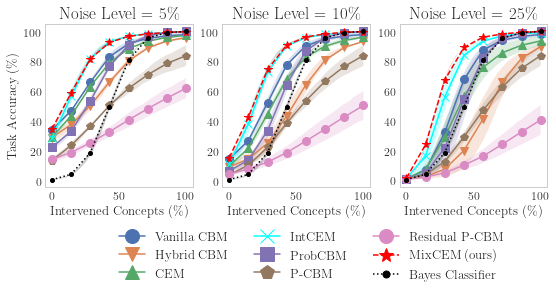

In [68]:
results_to_include = [
    dict(
        path='/anfs/bigdisc/me466/mixcem_results/cub_complete/',
        name='CUB',
        # rename={'Posthoc Hybrid CBM': 'Hybrid Posthoc CBM'},
    ),
]
for res in results_to_include:
    res['results'] = joblib.load(os.path.join(res['path'], 'results.joblib'))
baselines_to_include = [
    "Joint CBM",
    "Hybrid-CBM",
    "CEM",
    "IntCEM",
    "ProbCBM",
    "Posthoc CBM",
    # "Hybrid Posthoc CBM",
    "Posthoc Hybrid CBM",
    "Entropy CMCMixCEM",
    "Bayes MLP",
]

noise_levels = [
    # 0.01,
    0.05,
    0.1,
    0.25,
    # 0.5,
    # 0.75,
    # 0.9,
    # 0.99,
]

dataset_results = results_to_include[0]

fig, axs = plt.subplots(1, len(noise_levels), figsize=(3*len(noise_levels), 3))
results = dataset_results['results']
used_select_metric = dataset_results.get(
    'select_metric',
    select_metric,
)
dataset_results['selected_models'] = joblib.load(os.path.join(dataset_results['path'], f'selected_models_{used_select_metric}.joblib'))
print("For dataset", dataset_results['name'], "we selected")
for key, val in dataset_results['selected_models'].items():
    print(f"\t{key}: {val}")
selected_models = dataset_results['selected_models']
for col, noise_level in enumerate(noise_levels):
    ood_suffix = f'OOD_sap_{noise_level}_'
    ax = axs[col]
    for idx, label in enumerate(baselines_to_include):
        mode_key = " (Baseline)"
        mode_name = "Baseline OOD"
        label = dataset_results.get('rename', {}).get(label, label)
        model_name = selected_models.get(
            label + mode_key,
            label + mode_key,
        )
        ints = np.array(get_metric_from_dict(
            results,
            model_name,
            f"{ood_suffix if 'OOD' in mode_name else ''}test_acc_y_random_group_level_True_use_prior_False_ints",
        ))
        if len(ints) == 0:
            print("Skipping", model_name, "for", dataset_results['name'], "as we could not find any results...")
            continue
        label = used_rename_map.get(label, label)
        means = np.mean(ints, axis=0) * 100
        stds = np.std(ints, axis=0) * 100
        color = color_map.get(label, clrs[idx])
        marker = markers.get(label, "-x" if "Mix" in label else "-o")
        if dataset_results.get('intervention_freq', 1) != 1:
            freq = dataset_results.get('intervention_freq', 1)
            total_concepts = (len(means) - 1) * freq
            xticks = (
                [0] + list(100 * np.arange(1.0/total_concepts, 1, freq/total_concepts))
            )
        else:
            xticks = (
                [0] + list(100 * np.arange(1.0/(len(means) - 1), 1, 1.0/(len(means) - 1)))
            )
        if len(means) > max_limit:
            # Then let's only plot half the points to avoid clutter
            # Then make all the points
            ax.plot(
                xticks[::4],
                means[::4],
                marker,
                color=color,
                label=label,
                markersize=8,
            )
        else:
            # Otherwise, plot all points
            ax.plot(
                xticks,
                means,
                marker,
                color=color,
                label=label,
                markersize=8,
            )
        # print(mode_name, label, "means =", means)
        if show_variance:
            ax.fill_between(
                xticks,
                means - stds,
                means + stds,
                alpha=0.2,
                facecolor=color,
            )
    ax.set_xlim(-5, 105)
    if col == 0:
        ax.set_ylabel("Task Accuracy (\%)", fontsize=13)

    ax.set_xlabel("Intervened Concepts (\%)", fontsize=13)
    ax.xaxis.set_tick_params(labelsize=12)
    ax.yaxis.set_tick_params(labelsize=12)
    ax.set_yticks(range(0, 101, 20))
    ax.set_title(f"Noise Level = {int(noise_level*100)}\%", fontsize=20-3)
    ax.grid(False)
    handles, labels = ax.get_legend_handles_labels()
ax.legend(
    handles,
    labels,
    fontsize=13,
    loc='upper center',
    bbox_to_anchor=(-0.6,-0.2),
    ncol=3,
    markerscale=1.75,
)
plt.savefig(f"../figures/noise_ablation_small_true_mixcem_cub_comp{'_variance' if show_variance else ''}.pdf", bbox_inches='tight')
plt.savefig(f"../figures/noise_ablation_small_true_mixcem_cub_comp{'_variance' if show_variance else ''}.png", bbox_inches='tight')
plt.show()

For dataset CUB we selected
	DNN (Baseline): DNN_extra_dims_200
	Joint CBM (Baseline): CBM_Sigmoid_Baseline_cwl_10
	Joint Logit CBM (Baseline): CBM_Logit_Baseline_cwl_10
	Hybrid-CBM (Baseline): Hybrid-CBM_Sigmoid_extra_dims_50_Baseline_cwl_5
	CEM (Baseline): CEM_Baseline_cwl_1
	IntCEM (Baseline): IntCEM_emb_size_16_intervention_weight_1_intervention_task_discount_1.5_Baseline_cwl_1
	ProbCBM (Baseline): ProbCBM_cwl_class_hidden_dim_128_hidden_dim_32_n_samples_inference_50_max_concept_epochs_70_max_task_epochs_75
	Posthoc CBM (Baseline): PCBM_reg_1e-06_l1_0.99_penalty_1
	Posthoc Hybrid CBM (Baseline): HybridPCBM_reg_1e-06_l1_0.99_penalty_1
	Entropy CMCMixIntCEM No Calibration (Baseline): Entropy_CMCMixIntCEM_t_1_r_1_concat_None_0_mpc_1_tmc_1_emc_50_cwc_False_ce_0_g_ood_0.5_emb_16_True_tip_0.25_itd_1.1_iw_0.1_cwl_1
	Entropy CMCMixIntCEM (Baseline): Entropy_CMCMixIntCEM_t_1_r_1_concat_None_0_mpc_1_tmc_1_emc_50_cwc_False_ce_30_g_ood_0.1_emb_16_True_tip_0.25_itd_1.1_iw_0.1_cwl_1
	Entropy CMC

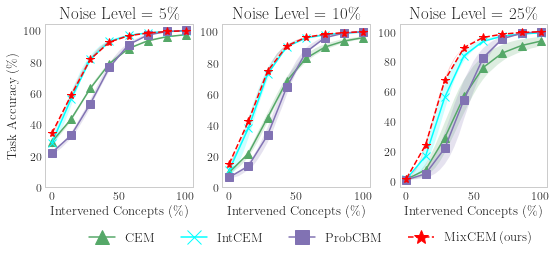

In [69]:
results_to_include = [
    dict(
        path='/anfs/bigdisc/me466/mixcem_results/cub_complete/',
        name='CUB',
        # rename={'Posthoc Hybrid CBM': 'Hybrid Posthoc CBM'},
    ),
]
for res in results_to_include:
    res['results'] = joblib.load(os.path.join(res['path'], 'results.joblib'))
baselines_to_include = [
    # "Joint CBM",
    # "Hybrid-CBM",
    "CEM",
    "IntCEM",
    "ProbCBM",
    # "Posthoc CBM",
    # "Hybrid Posthoc CBM",
    # "Posthoc Hybrid CBM",
    "Entropy CMCMixCEM",
    # "Bayes MLP",
]

noise_levels = [
    # 0.01,
    0.05,
    0.1,
    0.25,
    # 0.5,
    # 0.75,
    # 0.9,
    # 0.99,
]

dataset_results = results_to_include[0]

fig, axs = plt.subplots(1, len(noise_levels), figsize=(3*len(noise_levels), 3))
results = dataset_results['results']
used_select_metric = dataset_results.get(
    'select_metric',
    select_metric,
)
dataset_results['selected_models'] = joblib.load(os.path.join(dataset_results['path'], f'selected_models_{used_select_metric}.joblib'))
print("For dataset", dataset_results['name'], "we selected")
for key, val in dataset_results['selected_models'].items():
    print(f"\t{key}: {val}")
selected_models = dataset_results['selected_models']
for col, noise_level in enumerate(noise_levels):
    ood_suffix = f'OOD_sap_{noise_level}_'
    ax = axs[col]
    for idx, label in enumerate(baselines_to_include):
        mode_key = " (Baseline)"
        mode_name = "Baseline OOD"
        label = dataset_results.get('rename', {}).get(label, label)
        model_name = selected_models.get(
            label + mode_key,
            label + mode_key,
        )
        ints = np.array(get_metric_from_dict(
            results,
            model_name,
            f"{ood_suffix if 'OOD' in mode_name else ''}test_acc_y_random_group_level_True_use_prior_False_ints",
        ))
        if len(ints) == 0:
            print("Skipping", model_name, "for", dataset_results['name'], "as we could not find any results...")
            continue
        label = used_rename_map.get(label, label)
        means = np.mean(ints, axis=0) * 100
        stds = np.std(ints, axis=0) * 100
        color = color_map.get(label, clrs[idx])
        marker = markers.get(label, "-x" if "Mix" in label else "-o")
        if dataset_results.get('intervention_freq', 1) != 1:
            freq = dataset_results.get('intervention_freq', 1)
            total_concepts = (len(means) - 1) * freq
            xticks = (
                [0] + list(100 * np.arange(1.0/total_concepts, 1, freq/total_concepts))
            )
        else:
            xticks = (
                [0] + list(100 * np.arange(1.0/(len(means) - 1), 1, 1.0/(len(means) - 1)))
            )
        if len(means) > max_limit:
            # Then let's only plot half the points to avoid clutter
            # Then make all the points
            ax.plot(
                xticks[::4],
                means[::4],
                marker,
                color=color,
                label=label,
                markersize=8,
            )
        else:
            # Otherwise, plot all points
            ax.plot(
                xticks,
                means,
                marker,
                color=color,
                label=label,
                markersize=8,
            )
        # print(mode_name, label, "means =", means)
        if show_variance:
            ax.fill_between(
                xticks,
                means - stds,
                means + stds,
                alpha=0.2,
                facecolor=color,
            )
    ax.set_xlim(-5, 105)
    if col == 0:
        ax.set_ylabel("Task Accuracy (\%)", fontsize=13)

    ax.set_xlabel("Intervened Concepts (\%)", fontsize=13)
    ax.xaxis.set_tick_params(labelsize=12)
    ax.yaxis.set_tick_params(labelsize=12)
    ax.set_yticks(range(0, 101, 20))
    ax.set_title(f"Noise Level = {int(noise_level*100)}\%", fontsize=20-3)
    ax.grid(False)
    handles, labels = ax.get_legend_handles_labels()
ax.legend(
    handles,
    labels,
    fontsize=13,
    loc='upper center',
    bbox_to_anchor=(-0.6,-0.2),
    ncol=4,
    markerscale=1.75,
)
plt.savefig(f"../figures/noise_ablation_small_true_mixcem_cub_comp_best_performing{'_variance' if show_variance else ''}.pdf", bbox_inches='tight')
plt.savefig(f"../figures/noise_ablation_small_true_mixcem_cub_comp_best_performing{'_variance' if show_variance else ''}.png", bbox_inches='tight')
plt.show()

For dataset CUB-Incomplete we selected
	DNN (Baseline): DNN_extra_dims_200
	Joint CBM (Baseline): CBM_Sigmoid_Baseline_cwl_1
	Hybrid-CBM (Baseline): Hybrid-CBM_Sigmoid_extra_dims_50_Baseline_cwl_1
	CEM (Baseline): CEM_Baseline_cwl_1
	IntCEM (Baseline): IntCEM_emb_size_16_intervention_weight_1_intervention_task_discount_1.1_Baseline_cwl_1
	ProbCBM (Baseline): ProbCBM_cwl_class_hidden_dim_64_hidden_dim_16_n_samples_inference_50_max_concept_epochs_70_max_task_epochs_75
	Posthoc CBM (Baseline): PCBM_reg_0.001_l1_0.99_penalty_1
	Hybrid Posthoc CBM (Baseline): HybridPCBM_reg_0.1_l1_0.99_penalty_1
	Entropy CMCMixIntCEM No Calibration (Baseline): Entropy_CMCMixIntCEM_t_1_r_1_concat_None_0_mpc_1_tmc_1_emc_50_cwc_False_ce_0_g_ood_0.1_emb_16_True_tip_0.25_itd_1.1_iw_0.1_cwl_1
	Entropy CMCMixIntCEM (Baseline): Entropy_CMCMixIntCEM_t_1_r_1_concat_None_0_mpc_1_tmc_1_emc_50_cwc_False_ce_30_g_ood_0.1_emb_16_True_tip_0.25_itd_1.1_iw_0.1_cwl_1
	Entropy CMCMixCEM No Calibration (Baseline): Entropy_CMCMix

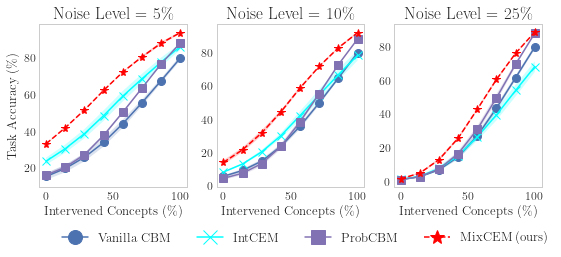

In [70]:
results_to_include = [
    dict(
        path='/anfs/bigdisc/me466/mixcem_results/cub_incomplete/',
        name='CUB-Incomplete',
        rename={'Posthoc Hybrid CBM': 'Hybrid Posthoc CBM'},
    ),
]
for res in results_to_include:
    res['results'] = joblib.load(os.path.join(res['path'], 'results.joblib'))
baselines_to_include = [
    "Joint CBM",
    # "Hybrid-CBM",
    # "CEM",
    "IntCEM",
    "ProbCBM",
    # "Posthoc CBM",
    # "Hybrid Posthoc CBM",
    "Entropy CMCMixCEM",
    # "Bayes MLP",
]

noise_levels = [
    # 0.01,
    0.05,
    0.1,
    0.25,
    # 0.5,
    # 0.75,
    # 0.9,
    # 0.99,
]

dataset_results = results_to_include[0]

fig, axs = plt.subplots(1, len(noise_levels), figsize=(3*len(noise_levels), 3))
results = dataset_results['results']
used_select_metric = dataset_results.get(
    'select_metric',
    select_metric,
)
dataset_results['selected_models'] = joblib.load(os.path.join(dataset_results['path'], f'selected_models_{used_select_metric}.joblib'))
print("For dataset", dataset_results['name'], "we selected")
for key, val in dataset_results['selected_models'].items():
    print(f"\t{key}: {val}")
selected_models = dataset_results['selected_models']
for col, noise_level in enumerate(noise_levels):
    ood_suffix = f'OOD_sap_{noise_level}_'
    ax = axs[col]
    for idx, label in enumerate(baselines_to_include):
        mode_key = " (Baseline)"
        mode_name = "Baseline OOD"
        label = dataset_results.get('rename', {}).get(label, label)
        model_name = selected_models.get(
            label + mode_key,
            label + mode_key,
        )
        ints = np.array(get_metric_from_dict(
            results,
            model_name,
            f"{ood_suffix if 'OOD' in mode_name else ''}test_acc_y_random_group_level_True_use_prior_False_ints",
        ))
        if len(ints) == 0:
            print("Skipping", model_name, "for", dataset_results['name'], "as we could not find any results...")
            continue
        label = used_rename_map.get(label, label)
        means = np.mean(ints, axis=0) * 100
        stds = np.std(ints, axis=0) * 100
        color = color_map.get(label, clrs[idx])
        marker = markers.get(label, "-x" if "Mix" in label else "-o")
        if dataset_results.get('intervention_freq', 1) != 1:
            freq = dataset_results.get('intervention_freq', 1)
            total_concepts = (len(means) - 1) * freq
            xticks = (
                [0] + list(100 * np.arange(1.0/total_concepts, 1, freq/total_concepts))
            )
        else:
            xticks = (
                [0] + list(100 * np.arange(1.0/(len(means) - 1), 1, 1.0/(len(means) - 1)))
            )
        if len(means) > max_limit:
            # Then let's only plot half the points to avoid clutter
            # Make the line first
            ax.plot(
                xticks,
                means,
                marker[:-1],
                color=color,
                label=label,
                markersize=8,
            )
            # Then make all the points
            ax.plot(
                xticks[::4],
                means[::4],
                marker[-1:],
                color=color,
                label=label,
                markersize=8,
            )
        else:
            # Otherwise, plot all points
            ax.plot(
                xticks,
                means,
                marker,
                color=color,
                label=label,
                markersize=8,
            )
        # print(mode_name, label, "means =", means)
        if show_variance:
            ax.fill_between(
                xticks,
                means - stds,
                means + stds,
                alpha=0.2,
                facecolor=color,
            )
    ax.set_xlim(-5, 105)
    if col == 0:
        ax.set_ylabel("Task Accuracy (\%)", fontsize=13)

    ax.set_xlabel("Intervened Concepts (\%)", fontsize=13)
    ax.xaxis.set_tick_params(labelsize=12)
    ax.yaxis.set_tick_params(labelsize=12)
    ax.set_title(f"Noise Level = {int(noise_level*100)}\%", fontsize=20-3)
    ax.grid(False)
    handles, labels = ax.get_legend_handles_labels()
ax.legend(
    handles,
    labels,
    fontsize=13,
    loc='upper center',
    bbox_to_anchor=(-0.6,-0.2),
    ncol=4,
    markerscale=1.75,
)
plt.savefig(f"../figures/noise_ablation_smaller_true_mixcem{'_variance' if show_variance else ''}.pdf", bbox_inches='tight')
plt.savefig(f"../figures/noise_ablation_smaller_true_mixcem{'_variance' if show_variance else ''}.png", bbox_inches='tight')
plt.show()

For dataset CUB-Incomplete we selected
	DNN (Baseline): DNN_extra_dims_200
	Joint CBM (Baseline): CBM_Sigmoid_Baseline_cwl_1
	Hybrid-CBM (Baseline): Hybrid-CBM_Sigmoid_extra_dims_50_Baseline_cwl_1
	CEM (Baseline): CEM_Baseline_cwl_1
	IntCEM (Baseline): IntCEM_emb_size_16_intervention_weight_1_intervention_task_discount_1.1_Baseline_cwl_1
	ProbCBM (Baseline): ProbCBM_cwl_class_hidden_dim_64_hidden_dim_16_n_samples_inference_50_max_concept_epochs_70_max_task_epochs_75
	Posthoc CBM (Baseline): PCBM_reg_0.001_l1_0.99_penalty_1
	Hybrid Posthoc CBM (Baseline): HybridPCBM_reg_0.1_l1_0.99_penalty_1
	Entropy CMCMixIntCEM No Calibration (Baseline): Entropy_CMCMixIntCEM_t_1_r_1_concat_None_0_mpc_1_tmc_1_emc_50_cwc_False_ce_0_g_ood_0.1_emb_16_True_tip_0.25_itd_1.1_iw_0.1_cwl_1
	Entropy CMCMixIntCEM (Baseline): Entropy_CMCMixIntCEM_t_1_r_1_concat_None_0_mpc_1_tmc_1_emc_50_cwc_False_ce_30_g_ood_0.1_emb_16_True_tip_0.25_itd_1.1_iw_0.1_cwl_1
	Entropy CMCMixCEM No Calibration (Baseline): Entropy_CMCMix

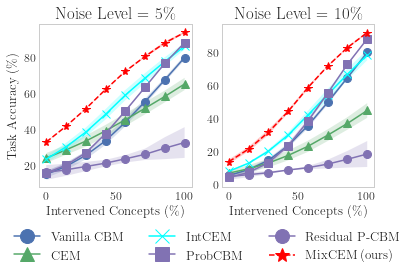

In [71]:
results_to_include = [
    dict(
        path='/anfs/bigdisc/me466/mixcem_results/cub_incomplete/',
        name='CUB-Incomplete',
        rename={'Posthoc Hybrid CBM': 'Hybrid Posthoc CBM'},
    ),
]
for res in results_to_include:
    res['results'] = joblib.load(os.path.join(res['path'], 'results.joblib'))
baselines_to_include = [
    "Joint CBM",
    # "Hybrid-CBM",
    "CEM",
    "IntCEM",
    "ProbCBM",
    # "Posthoc CBM",
    "Hybrid Posthoc CBM",
    "Entropy CMCMixCEM",
    # "Bayes MLP",
]

noise_levels = [
    # 0.01,
    0.05,
    0.1,
    # 0.25,
    # 0.5,
    # 0.75,
    # 0.9,
    # 0.99,
]

dataset_results = results_to_include[0]

fig, axs = plt.subplots(1, len(noise_levels), figsize=(3*len(noise_levels), 3))
results = dataset_results['results']
used_select_metric = dataset_results.get(
    'select_metric',
    select_metric,
)
dataset_results['selected_models'] = joblib.load(os.path.join(dataset_results['path'], f'selected_models_{used_select_metric}.joblib'))
print("For dataset", dataset_results['name'], "we selected")
for key, val in dataset_results['selected_models'].items():
    print(f"\t{key}: {val}")
selected_models = dataset_results['selected_models']
for col, noise_level in enumerate(noise_levels):
    ood_suffix = f'OOD_sap_{noise_level}_'
    ax = axs[col]
    for idx, label in enumerate(baselines_to_include):
        mode_key = " (Baseline)"
        mode_name = "Baseline OOD"
        label = dataset_results.get('rename', {}).get(label, label)
        model_name = selected_models.get(
            label + mode_key,
            label + mode_key,
        )
        ints = np.array(get_metric_from_dict(
            results,
            model_name,
            f"{ood_suffix if 'OOD' in mode_name else ''}test_acc_y_random_group_level_True_use_prior_False_ints",
        ))
        if len(ints) == 0:
            print("Skipping", model_name, "for", dataset_results['name'], "as we could not find any results...")
            continue
        label = used_rename_map.get(label, label)
        means = np.mean(ints, axis=0) * 100
        stds = np.std(ints, axis=0) * 100
        color = color_map.get(label, clrs[idx])
        marker = markers.get(label, "-x" if "Mix" in label else "-o")
        if dataset_results.get('intervention_freq', 1) != 1:
            freq = dataset_results.get('intervention_freq', 1)
            total_concepts = (len(means) - 1) * freq
            xticks = (
                [0] + list(100 * np.arange(1.0/total_concepts, 1, freq/total_concepts))
            )
        else:
            xticks = (
                [0] + list(100 * np.arange(1.0/(len(means) - 1), 1, 1.0/(len(means) - 1)))
            )
        if len(means) > max_limit:
            # Then let's only plot half the points to avoid clutter
            # Make the line first
            ax.plot(
                xticks,
                means,
                marker[:-1],
                color=color,
                label=label,
                markersize=8,
            )
            # Then make all the points
            ax.plot(
                xticks[::4],
                means[::4],
                marker[-1:],
                color=color,
                label=label,
                markersize=8,
            )
        else:
            # Otherwise, plot all points
            ax.plot(
                xticks,
                means,
                marker,
                color=color,
                label=label,
                markersize=8,
            )
        # print(mode_name, label, "means =", means)
        if show_variance:
            ax.fill_between(
                xticks,
                means - stds,
                means + stds,
                alpha=0.2,
                facecolor=color,
            )
    ax.set_xlim(-5, 105)
    if col == 0:
        ax.set_ylabel("Task Accuracy (\%)", fontsize=13)

    ax.set_xlabel("Intervened Concepts (\%)", fontsize=13)
    ax.xaxis.set_tick_params(labelsize=12)
    ax.yaxis.set_tick_params(labelsize=12)
    ax.set_title(f"Noise Level = {int(noise_level*100)}\%", fontsize=20-3)
    ax.grid(False)
    handles, labels = ax.get_legend_handles_labels()
ax.legend(
    handles,
    labels,
    fontsize=13,
    loc='upper center',
    bbox_to_anchor=(-0.1,-0.2),
    ncol=3,
    markerscale=1.75,
)
plt.savefig(f"../figures/noise_ablation_tiny_true_mixcem{'_variance' if show_variance else ''}.pdf", bbox_inches='tight')
plt.savefig(f"../figures/noise_ablation_tiny_true_mixcem{'_variance' if show_variance else ''}.png", bbox_inches='tight')
plt.show()

For dataset CUB-Incomplete we selected
	DNN (Baseline): DNN_extra_dims_200
	Joint CBM (Baseline): CBM_Sigmoid_Baseline_cwl_1
	Hybrid-CBM (Baseline): Hybrid-CBM_Sigmoid_extra_dims_50_Baseline_cwl_1
	CEM (Baseline): CEM_Baseline_cwl_1
	IntCEM (Baseline): IntCEM_emb_size_16_intervention_weight_1_intervention_task_discount_1.1_Baseline_cwl_1
	ProbCBM (Baseline): ProbCBM_cwl_class_hidden_dim_64_hidden_dim_16_n_samples_inference_50_max_concept_epochs_70_max_task_epochs_75
	Posthoc CBM (Baseline): PCBM_reg_0.001_l1_0.99_penalty_1
	Hybrid Posthoc CBM (Baseline): HybridPCBM_reg_0.1_l1_0.99_penalty_1
	Entropy CMCMixIntCEM No Calibration (Baseline): Entropy_CMCMixIntCEM_t_1_r_1_concat_None_0_mpc_1_tmc_1_emc_50_cwc_False_ce_0_g_ood_0.1_emb_16_True_tip_0.25_itd_1.1_iw_0.1_cwl_1
	Entropy CMCMixIntCEM (Baseline): Entropy_CMCMixIntCEM_t_1_r_1_concat_None_0_mpc_1_tmc_1_emc_50_cwc_False_ce_30_g_ood_0.1_emb_16_True_tip_0.25_itd_1.1_iw_0.1_cwl_1
	Entropy CMCMixCEM No Calibration (Baseline): Entropy_CMCMix

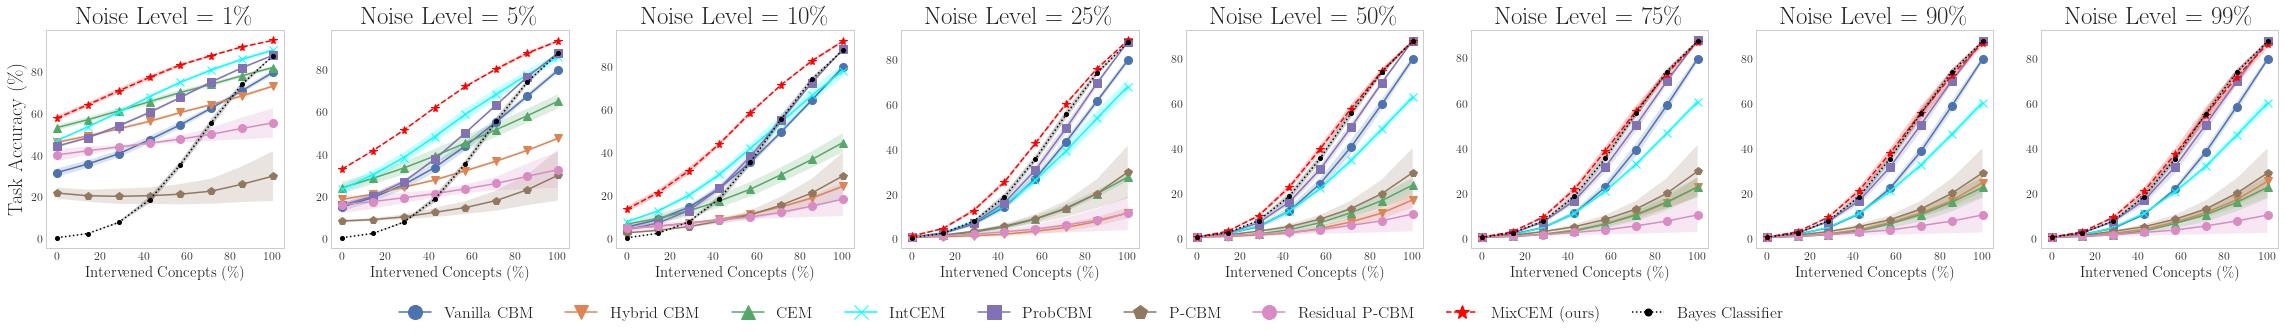

In [72]:
results_to_include = [
    dict(
        path='/anfs/bigdisc/me466/mixcem_results/cub_incomplete/',
        name='CUB-Incomplete',
        rename={'Posthoc Hybrid CBM': 'Hybrid Posthoc CBM'},
    ),
]
for res in results_to_include:
    res['results'] = joblib.load(os.path.join(res['path'], 'results.joblib'))
baselines_to_include = [
    "Joint CBM",
    "Hybrid-CBM",
    "CEM",
    "IntCEM",
    "ProbCBM",
    "Posthoc CBM",
    "Hybrid Posthoc CBM",
    "Entropy CMCMixCEM",
    "Bayes MLP",
]
noise_levels = [
    0.01,
    0.05,
    0.1,
    0.25,
    0.5,
    0.75,
    0.9,
    0.99,
]

dataset_results = results_to_include[0]

fig, axs = plt.subplots(1, len(noise_levels), figsize=(5*len(noise_levels), 4))
results = dataset_results['results']
used_select_metric = dataset_results.get(
    'select_metric',
    select_metric,
)
dataset_results['selected_models'] = joblib.load(os.path.join(dataset_results['path'], f'selected_models_{used_select_metric}.joblib'))
print("For dataset", dataset_results['name'], "we selected")
for key, val in dataset_results['selected_models'].items():
    print(f"\t{key}: {val}")
selected_models = dataset_results['selected_models']
for col, noise_level in enumerate(noise_levels):
    ood_suffix = f'OOD_sap_{noise_level}_'
    ax = axs[col]
    for idx, label in enumerate(baselines_to_include):
        mode_key = " (Baseline)"
        mode_name = "Baseline OOD"
        label = dataset_results.get('rename', {}).get(label, label)
        model_name = selected_models.get(
            label + mode_key,
            label + mode_key,
        )
        ints = np.array(get_metric_from_dict(
            results,
            model_name,
            f"{ood_suffix if 'OOD' in mode_name else ''}test_acc_y_random_group_level_True_use_prior_False_ints",
        ))
        if len(ints) == 0:
            print("Skipping", model_name, "for", dataset_results['name'], "as we could not find any results...")
            continue
        label = used_rename_map.get(label, label)
        means = np.mean(ints, axis=0) * 100
        stds = np.std(ints, axis=0) * 100
        color = color_map.get(label, clrs[idx])
        marker = markers.get(label, "-x" if "Mix" in label else "-o")
        if dataset_results.get('intervention_freq', 1) != 1:
            freq = dataset_results.get('intervention_freq', 1)
            total_concepts = (len(means) - 1) * freq
            xticks = (
                [0] + list(100 * np.arange(1.0/total_concepts, 1, freq/total_concepts))
            )
        else:
            xticks = (
                [0] + list(100 * np.arange(1.0/(len(means) - 1), 1, 1.0/(len(means) - 1)))
            )
        if len(means) > max_limit:
            # Then let's only plot half the points to avoid clutter
            # Make the line first
            ax.plot(
                xticks,
                means,
                marker[:-1],
                color=color,
                label=label,
                markersize=8,
            )
            # Then make all the points
            ax.plot(
                xticks[::4],
                means[::4],
                marker[-1:],
                color=color,
                label=label,
                markersize=8,
            )
        else:
            # Otherwise, plot all points
            ax.plot(
                xticks,
                means,
                marker,
                color=color,
                label=label,
                markersize=8,
            )
        # print(mode_name, label, "means =", means)
        if show_variance:
            ax.fill_between(
                xticks,
                means - stds,
                means + stds,
                alpha=0.2,
                facecolor=color,
            )
    ax.set_xlim(-5, 105)
    if col == 0:
        ax.set_ylabel("Task Accuracy (\%)", fontsize=20)

    ax.set_xlabel("Intervened Concepts (\%)", fontsize=15)
    ax.xaxis.set_tick_params(labelsize=12)
    ax.yaxis.set_tick_params(labelsize=12)
    ax.grid(False)
    ax.set_title(f"Noise Level = {int(noise_level*100)}\%", fontsize=25)
    handles, labels = ax.get_legend_handles_labels()
ax.legend(
    handles,
    labels,
    fontsize=16,
    loc='upper center',
    bbox_to_anchor=(-4,-0.2),
    ncol=9,
    markerscale=1.75,
)
plt.savefig(f"../figures/noise_ablation_complete_true_mixcem{'_variance' if show_variance else ''}.pdf", bbox_inches='tight')
plt.savefig(f"../figures/noise_ablation_complete_true_mixcem{'_variance' if show_variance else ''}.png", bbox_inches='tight')
plt.show()

## OOD Results (with IntCEM's loss)

For dataset \texttt{TravelingBirds} we selected
	DNN (Baseline): DNN_extra_dims_200
	Joint CBM (Baseline): CBM_Sigmoid_Baseline_cwl_1
	Joint Logit CBM (Baseline): CBM_Logit_Baseline_cwl_5
	Sequential CBM (Baseline): CBM_Seq
	Independent CBM (Baseline): CBM_Ind
	Hybrid-CBM (Baseline): Hybrid-CBM_Sigmoid_extra_dims_200_Baseline_cwl_5
	CEM (Baseline): CEM_emb_size_16_Baseline_cwl_1
	IntCEM (Baseline): IntCEM_intervention_weight_0.1_intervention_task_discount_1.1_Baseline_cwl_1
	ProbCBM (Baseline): ProbCBM_class_hidden_dim_32_hidden_dim_4_cwl_1
	Posthoc CBM (Baseline): PCBM_reg_0.1_l1_0.99_penalty_1
	Hybrid Posthoc CBM (Baseline): HybridPCBM_reg_0.1_l1_0.99_penalty_1
	Entropy CMCMixIntCEM No Calibration (Baseline): Entropy_CMCMixIntCEM_t_1_r_1_concat_None_0_mpc_1_tmc_1_emc_50_cwc_False_ce_0_g_ood_0.5_emb_16_True_tip_0.25_itd_1.1_iw_0.1_cwl_1
	Entropy CMCMixIntCEM (Baseline): Entropy_CMCMixIntCEM_t_1_r_1_concat_None_0_mpc_1_tmc_1_emc_50_cwc_False_ce_30_g_ood_0.5_emb_16_True_tip_0.25_itd_1.1

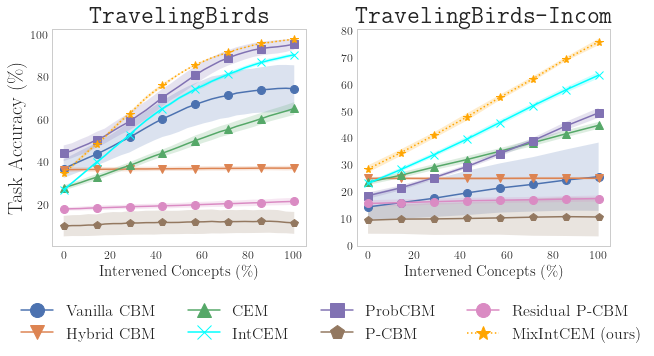

In [73]:
results_to_include = [
    dict(
        path='/anfs/bigdisc/me466/mixcem_results/travelingbirds_complete/',
        name=r'\texttt{TravelingBirds}',
    ),

    dict(
        path='/anfs/bigdisc/me466/mixcem_results/travelingbirds_incomplete/',
        name=r'\texttt{TravelingBirds-Incom}',
    ),
]
for res in results_to_include:
    res['results'] = joblib.load(os.path.join(res['path'], 'results.joblib'))

baselines_to_include = [
    "Joint CBM",
    "Hybrid-CBM",
    "CEM",
    "IntCEM",
    "ProbCBM",
    "Posthoc CBM",
    "Hybrid Posthoc CBM",
    "Entropy CMCMixIntCEM",
]

fig, axs = plt.subplots(1, len(results_to_include), figsize=(5*len(results_to_include), 4))
for col, dataset_results in enumerate(results_to_include):
    results = dataset_results['results']
    used_select_metric = dataset_results.get(
        'select_metric',
        select_metric,
    )
    dataset_results['selected_models'] = joblib.load(os.path.join(dataset_results['path'], f'selected_models_{used_select_metric}.joblib'))
    print("For dataset", dataset_results['name'], "we selected")
    for key, val in dataset_results['selected_models'].items():
        print(f"\t{key}: {val}")
    selected_models = dataset_results['selected_models']
    ax = axs[col]
    for idx, label in enumerate(baselines_to_include):
        mode_key = " (Baseline)"
        mode_name = "Baseline"
        label = dataset_results.get('rename', {}).get(label, label)
        model_name = selected_models.get(
            label + mode_key,
            label + mode_key,
        )
        ints = np.array(get_metric_from_dict(
            results,
            model_name,
            f"{ood_suffix if 'OOD' in mode_name else ''}test_acc_y_random_group_level_True_use_prior_False_ints",
        ))
        if len(ints) == 0:
            print("Skipping", model_name, "for", dataset_results['name'], "as we could not find any results...")
            continue
        label = rename_map.get(label, label)
        means = np.mean(ints, axis=0) * 100
        stds = np.std(ints, axis=0) * 100
        color = color_map.get(label, clrs[idx])
        marker = markers.get(label, "-x" if "Mix" in label else "-o")
        if dataset_results.get('intervention_freq', 1) != 1:
            freq = dataset_results.get('intervention_freq', 1)
            total_concepts = (len(means) - 1) * freq
            xticks = (
                [0] + list(100 * np.arange(1.0/total_concepts, 1, freq/total_concepts))
            )
        else:
            xticks = (
                [0] + list(100 * np.arange(1.0/(len(means) - 1), 1, 1.0/(len(means) - 1)))
            )
        if len(means) > max_limit:
            # Then let's only plot half the points to avoid clutter
            # Make the line first
            ax.plot(
                xticks,
                means,
                marker[:-1],
                color=color,
                label=label,
                markersize=8,
            )
            # Then make all the points
            ax.plot(
                xticks[::4],
                means[::4],
                marker[-1:],
                color=color,
                label=label,
                markersize=8,
            )
        else:
            # Otherwise, plot all points
            ax.plot(
                xticks,
                means,
                marker,
                color=color,
                label=label,
                markersize=8,
            )
        # print(mode_name, label, "means =", means)
        if show_variance:
            ax.fill_between(
                xticks,
                means - stds,
                means + stds,
                alpha=0.2,
                facecolor=color,
            )
    ax.set_xlim(-5, 105)
    if col == 0:
        ax.set_ylabel("Task Accuracy (\%)", fontsize=20)

    ax.set_xlabel("Intervened Concepts (\%)", fontsize=15)
    ax.xaxis.set_tick_params(labelsize=12)
    ax.yaxis.set_tick_params(labelsize=12)
    ax.set_title(dataset_results['name'], fontsize=25)
    ax.grid(False)
    handles, labels = ax.get_legend_handles_labels()
ax.legend(
    handles,
    labels,
    fontsize=16,
    loc='upper center',
    bbox_to_anchor=(-0.1,-0.2),
    ncol=4,
    markerscale=1.75,
)
plt.savefig(f"../figures/spurious_results{'_variance' if show_variance else ''}.pdf", bbox_inches='tight')
plt.savefig(f"../figures/spurious_results{'_variance' if show_variance else ''}.png", bbox_inches='tight')
plt.show()

For dataset \texttt{TravelingBirds-Incom} we selected
	DNN (Baseline): DNN_extra_dims_200
	Joint CBM (Baseline): CBM_Sigmoid_Baseline_cwl_1
	Joint Logit CBM (Baseline): CBM_Logit_Baseline_cwl_1
	Sequential CBM (Baseline): CBM_Seq
	Independent CBM (Baseline): CBM_Ind
	Hybrid-CBM (Baseline): Hybrid-CBM_Sigmoid_extra_dims_200_Baseline_cwl_1
	CEM (Baseline): CEM_emb_size_16_Baseline_cwl_1
	IntCEM (Baseline): IntCEM_intervention_weight_0.1_intervention_task_discount_1.5_Baseline_cwl_1
	ProbCBM (Baseline): ProbCBM_class_hidden_dim_32_hidden_dim_8_cwl_1
	Posthoc CBM (Baseline): PCBM_reg_0.1_l1_0.99_penalty_1
	Hybrid Posthoc CBM (Baseline): HybridPCBM_reg_0.001_l1_0.99_penalty_1
	Linear CMCMixIntCEM No Calibration (Baseline): Linear_CMCMixIntCEM_t_1_r_0.1_concat_None_0_mpc_1_tmc_1_emc_50_cwc_False_ce_0_g_ood_0.1_emb_16_True_tip_0.25_itd_1.1_iw_0.1_cwl_1
	Linear CMCMixIntCEM (Baseline): Linear_CMCMixIntCEM_t_1_r_1_concat_None_0_mpc_1_tmc_1_emc_50_cwc_False_ce_30_g_ood_0.1_emb_16_True_tip_0.25_i

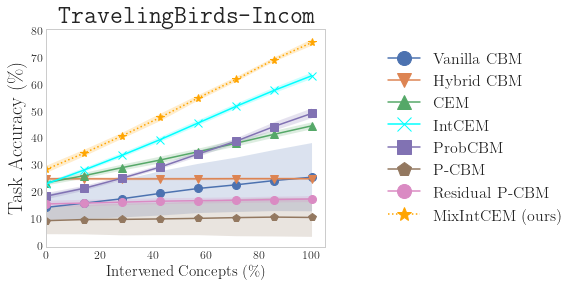

In [41]:
results_to_include = [
    dict(
        path='/anfs/bigdisc/me466/mixcem_results/travelingbirds_incomplete/',
        name=r'\texttt{TravelingBirds-Incom}',
        # remap={'Entropy CMCMixIntCEM': 'Linear CMCMixIntCEM'}
    ),
]
for res in results_to_include:
    res['results'] = joblib.load(os.path.join(res['path'], 'results.joblib'))

baselines_to_include = [
    "Joint CBM",
    "Hybrid-CBM",
    "CEM",
    "IntCEM",
    "ProbCBM",
    "Posthoc CBM",
    "Hybrid Posthoc CBM",
    "Entropy CMCMixIntCEM",
]

fig, axs = plt.subplots(1, len(results_to_include), figsize=(5*len(results_to_include), 4), squeeze=False)
for col, dataset_results in enumerate(results_to_include):
    results = dataset_results['results']
    used_select_metric = dataset_results.get(
        'select_metric',
        select_metric,
    )
    dataset_results['selected_models'] = joblib.load(os.path.join(dataset_results['path'], f'selected_models_{used_select_metric}.joblib'))
    print("For dataset", dataset_results['name'], "we selected")
    for key, val in dataset_results['selected_models'].items():
        print(f"\t{key}: {val}")
    selected_models = dataset_results['selected_models']
    ax = axs[0, col]
    for idx, label in enumerate(baselines_to_include):
        mode_key = " (Baseline)"
        mode_name = "Baseline"
        label = dataset_results.get('rename', {}).get(label, label)
        model_name = selected_models.get(
            label + mode_key,
            label + mode_key,
        )
        ints = np.array(get_metric_from_dict(
            results,
            model_name,
            f"{ood_suffix if 'OOD' in mode_name else ''}test_acc_y_random_group_level_True_use_prior_False_ints",
        ))
        if len(ints) == 0:
            print("Skipping", model_name, "for", dataset_results['name'], "as we could not find any results...")
            continue
        label = rename_map.get(label, label)
        means = np.mean(ints, axis=0) * 100
        stds = np.std(ints, axis=0) * 100
        color = color_map.get(label, clrs[idx])
        marker = markers.get(label, "-x" if "Mix" in label else "-o")
        if dataset_results.get('intervention_freq', 1) != 1:
            freq = dataset_results.get('intervention_freq', 1)
            total_concepts = (len(means) - 1) * freq
            xticks = (
                [0] + list(100 * np.arange(1.0/total_concepts, 1, freq/total_concepts))
            )
        else:
            xticks = (
                [0] + list(100 * np.arange(1.0/(len(means) - 1), 1, 1.0/(len(means) - 1)))
            )
        if len(means) > max_limit:
            # Then let's only plot half the points to avoid clutter
            # Make the line first
            ax.plot(
                xticks,
                means,
                marker[:-1],
                color=color,
                label=label,
                markersize=8,
            )
            # Then make all the points
            ax.plot(
                xticks[::4],
                means[::4],
                marker[-1:],
                color=color,
                label=label,
                markersize=8,
            )
        else:
            # Otherwise, plot all points
            ax.plot(
                xticks,
                means,
                marker,
                color=color,
                label=label,
                markersize=8,
            )
        # print(mode_name, label, "means =", means)
        if show_variance:
            ax.fill_between(
                xticks,
                means - stds,
                means + stds,
                alpha=0.2,
                facecolor=color,
            )
    ax.set_xlim(0, 105)
    if col == 0:
        ax.set_ylabel("Task Accuracy (\%)", fontsize=20)

    ax.set_xlabel("Intervened Concepts (\%)", fontsize=15)
    ax.xaxis.set_tick_params(labelsize=12)
    ax.yaxis.set_tick_params(labelsize=12)
    ax.set_title(dataset_results['name'], fontsize=25)
    ax.grid(False)
    handles, labels = ax.get_legend_handles_labels()
ax.legend(
    handles,
    labels,
    fontsize=16,
    loc='center right',
    bbox_to_anchor=(1.9,0.5),
    ncol=1,
    markerscale=1.75,
)
plt.savefig(f"../figures/spurious_results_incomplete_only{'_variance' if show_variance else ''}.pdf", bbox_inches='tight')
plt.savefig(f"../figures/spurious_results_incomplete_only{'_variance' if show_variance else ''}.png", bbox_inches='tight')
plt.show()

For dataset \texttt{TravelingBirds} we selected
	DNN (Baseline): DNN_extra_dims_200
	Joint CBM (Baseline): CBM_Sigmoid_Baseline_cwl_1
	Joint Logit CBM (Baseline): CBM_Logit_Baseline_cwl_5
	Sequential CBM (Baseline): CBM_Seq
	Independent CBM (Baseline): CBM_Ind
	Hybrid-CBM (Baseline): Hybrid-CBM_Sigmoid_extra_dims_200_Baseline_cwl_5
	CEM (Baseline): CEM_emb_size_16_Baseline_cwl_1
	IntCEM (Baseline): IntCEM_intervention_weight_0.1_intervention_task_discount_1.1_Baseline_cwl_1
	ProbCBM (Baseline): ProbCBM_class_hidden_dim_32_hidden_dim_4_cwl_1
	Posthoc CBM (Baseline): PCBM_reg_0.1_l1_0.99_penalty_1
	Hybrid Posthoc CBM (Baseline): HybridPCBM_reg_0.1_l1_0.99_penalty_1
	Entropy CMCMixIntCEM No Calibration (Baseline): Entropy_CMCMixIntCEM_t_1_r_1_concat_None_0_mpc_1_tmc_1_emc_50_cwc_False_ce_0_g_ood_0.5_emb_16_True_tip_0.25_itd_1.1_iw_0.1_cwl_1
	Entropy CMCMixIntCEM (Baseline): Entropy_CMCMixIntCEM_t_1_r_1_concat_None_0_mpc_1_tmc_1_emc_50_cwc_False_ce_30_g_ood_0.5_emb_16_True_tip_0.25_itd_1.1

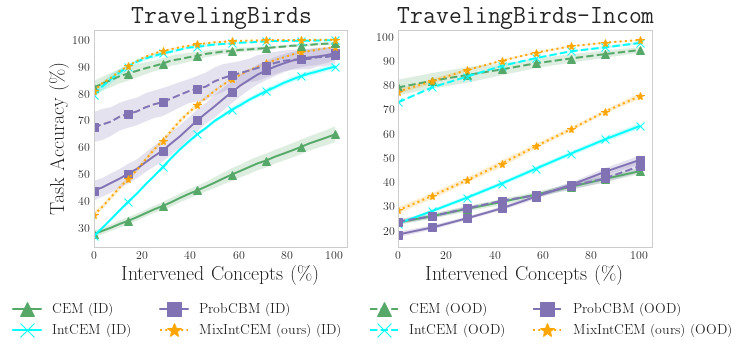

In [42]:
results_to_include = [
    dict(
        path='/anfs/bigdisc/me466/mixcem_results/travelingbirds_complete/',
        name=r'\texttt{TravelingBirds}',
        # remap={'Entropy CMCMixIntCEM': 'Linear CMCMixIntCEM'}
    ),

    dict(
        path='/anfs/bigdisc/me466/mixcem_results/travelingbirds_incomplete/',
        name=r'\texttt{TravelingBirds-Incom}',
        # remap={'Entropy CMCMixIntCEM': 'Linear CMCMixIntCEM'}
    ),
]
for res in results_to_include:
    res['results'] = joblib.load(os.path.join(res['path'], 'results.joblib'))

baselines_to_include = [
    "CEM",
    "IntCEM",
    "ProbCBM",
    "Entropy CMCMixIntCEM",
]


fig, axs = plt.subplots(1, len(results_to_include), figsize=(5*len(results_to_include), 4))
for col, dataset_results in enumerate(results_to_include):
    results = dataset_results['results']
    used_select_metric = dataset_results.get(
        'select_metric',
        select_metric,
    )
    dataset_results['selected_models'] = joblib.load(os.path.join(dataset_results['path'], f'selected_models_{used_select_metric}.joblib'))
    print("For dataset", dataset_results['name'], "we selected")
    for key, val in dataset_results['selected_models'].items():
        print(f"\t{key}: {val}")
    selected_models = dataset_results['selected_models']
    ax = axs[col]
    for idx, label in enumerate(baselines_to_include):
        mode_key = " (Baseline)"
        mode_name = "Baseline"
        label = dataset_results.get('rename', {}).get(label, label)
        model_name = selected_models.get(
            label + mode_key,
            label + mode_key,
        )
        ints = np.array(get_metric_from_dict(
            results,
            model_name,
            f"{ood_suffix if 'OOD' in mode_name else ''}test_acc_y_random_group_level_True_use_prior_False_ints",
        ))
        if len(ints) == 0:
            print("Skipping", model_name, "for", dataset_results['name'], "as we could not find any results...")
            continue
        label = rename_map.get(label, label)
        means = np.mean(ints, axis=0) * 100
        stds = np.std(ints, axis=0) * 100
        color = color_map.get(label, clrs[idx])
        marker = markers.get(label, "-x" if "Mix" in label else "-o")
        if dataset_results.get('intervention_freq', 1) != 1:
            freq = dataset_results.get('intervention_freq', 1)
            total_concepts = (len(means) - 1) * freq
            xticks = (
                [0] + list(100 * np.arange(1.0/total_concepts, 1, freq/total_concepts))
            )
        else:
            xticks = (
                [0] + list(100 * np.arange(1.0/(len(means) - 1), 1, 1.0/(len(means) - 1)))
            )
        if len(means) > max_limit:
            # Then let's only plot half the points to avoid clutter
            # Make the line first
            ax.plot(
                xticks,
                means,
                marker[:-1],
                color=color,
                label=label,
                markersize=8,
                linewidth=2,
            )
            # Then make all the points
            ax.plot(
                xticks[::4],
                means[::4],
                marker[-1:],
                color=color,
                label=label + " (ID)",
                markersize=8,
            )
        else:
            # Otherwise, plot all points
            ax.plot(
                xticks,
                means,
                marker,
                color=color,
                label=label + " (ID)",
                markersize=8,
                linewidth=2,
            )
        # print(mode_name, label, "means =", means)
        if show_variance:
            ax.fill_between(
                xticks,
                means - stds,
                means + stds,
                alpha=0.2,
                facecolor=color,
            )

for col, dataset_results in enumerate(results_to_include):
    results = dataset_results['results']
    used_select_metric = dataset_results.get(
        'select_metric',
        select_metric,
    )
    dataset_results['selected_models'] = joblib.load(os.path.join(dataset_results['path'], f'selected_models_{used_select_metric}.joblib'))
    print("For dataset", dataset_results['name'], "we selected")
    for key, val in dataset_results['selected_models'].items():
        print(f"\t{key}: {val}")
    selected_models = dataset_results['selected_models']
    ax = axs[col]
    for idx, label in enumerate(baselines_to_include):
        mode_key = " (Baseline)"
        mode_name = "Baseline"
        label = dataset_results.get('rename', {}).get(label, label)
        model_name = selected_models.get(
            label + mode_key,
            label + mode_key,
        )
        ints = np.array(get_metric_from_dict(
            results,
            model_name,
            f"{ood_suffix if 'OOD' in mode_name else ''}val_acc_y_random_group_level_True_use_prior_False_ints",
        ))
        if len(ints) == 0:
            print("Skipping", model_name, "for", dataset_results['name'], "as we could not find any results...")
            continue
        label = rename_map.get(label, label)
        means = np.mean(ints, axis=0) * 100
        stds = np.std(ints, axis=0) * 100
        color = color_map.get(label, clrs[idx])
        marker = markers.get(label, "-x" if "Mix" in label else "-o")
        marker = marker.replace('-', '--')
        if dataset_results.get('intervention_freq', 1) != 1:
            freq = dataset_results.get('intervention_freq', 1)
            total_concepts = (len(means) - 1) * freq
            xticks = (
                [0] + list(100 * np.arange(1.0/total_concepts, 1, freq/total_concepts))
            )
        else:
            xticks = (
                [0] + list(100 * np.arange(1.0/(len(means) - 1), 1, 1.0/(len(means) - 1)))
            )
        if len(means) > max_limit:
            # Then let's only plot half the points to avoid clutter
            # Make the line first
            ax.plot(
                xticks,
                means,
                marker[:-1],
                color=color,
                label=label + " (OOD)",
                markersize=8,
                linewidth=2,
            )
            # Then make all the points
            ax.plot(
                xticks[::4],
                means[::4],
                marker[-1:],
                color=color,
                label=label,
                markersize=8,
            )
        else:
            # Otherwise, plot all points
            ax.plot(
                xticks,
                means,
                marker,
                color=color,
                label=label + " (OOD)",
                markersize=8,
                linewidth=2,
            )
        # print(mode_name, label, "means =", means)
        if show_variance:
            ax.fill_between(
                xticks,
                means - stds,
                means + stds,
                alpha=0.2,
                facecolor=color,
            )
    ax.set_xlim(0, 105)
    if col == 0:
        ax.set_ylabel("Task Accuracy (\%)", fontsize=20)

    ax.set_xlabel("Intervened Concepts (\%)", fontsize=20)
    ax.xaxis.set_tick_params(labelsize=12)
    ax.yaxis.set_tick_params(labelsize=12)
    ax.set_title(dataset_results['name'], fontsize=25)
    ax.grid(False)
    handles, labels = ax.get_legend_handles_labels()
ax.legend(
    handles,
    labels,
    fontsize=14,
    loc='upper center',
    bbox_to_anchor=(-0.1,-0.2),
    ncol=4,
    markerscale=1.75,
)

plt.savefig(f"../figures/spurious_results_with_val{'_variance' if show_variance else ''}.pdf", bbox_inches='tight')
plt.savefig(f"../figures/spurious_results_with_val{'_variance' if show_variance else ''}.png", bbox_inches='tight')
plt.show()

For dataset \texttt{TravelingBirds} we selected
	DNN (Baseline): DNN_extra_dims_200
	Joint CBM (Baseline): CBM_Sigmoid_Baseline_cwl_1
	Joint Logit CBM (Baseline): CBM_Logit_Baseline_cwl_5
	Sequential CBM (Baseline): CBM_Seq
	Independent CBM (Baseline): CBM_Ind
	Hybrid-CBM (Baseline): Hybrid-CBM_Sigmoid_extra_dims_200_Baseline_cwl_5
	CEM (Baseline): CEM_emb_size_16_Baseline_cwl_1
	IntCEM (Baseline): IntCEM_intervention_weight_0.1_intervention_task_discount_1.1_Baseline_cwl_1
	ProbCBM (Baseline): ProbCBM_class_hidden_dim_32_hidden_dim_4_cwl_1
	Posthoc CBM (Baseline): PCBM_reg_0.1_l1_0.99_penalty_1
	Hybrid Posthoc CBM (Baseline): HybridPCBM_reg_0.1_l1_0.99_penalty_1
	Entropy CMCMixIntCEM No Calibration (Baseline): Entropy_CMCMixIntCEM_t_1_r_1_concat_None_0_mpc_1_tmc_1_emc_50_cwc_False_ce_0_g_ood_0.5_emb_16_True_tip_0.25_itd_1.1_iw_0.1_cwl_1
	Entropy CMCMixIntCEM (Baseline): Entropy_CMCMixIntCEM_t_1_r_1_concat_None_0_mpc_1_tmc_1_emc_50_cwc_False_ce_30_g_ood_0.5_emb_16_True_tip_0.25_itd_1.1

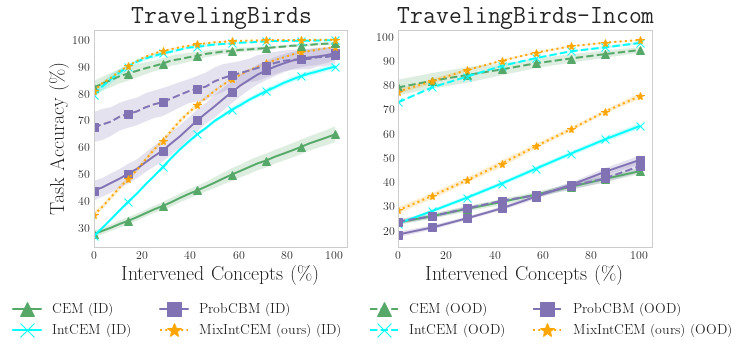

In [43]:
results_to_include = [
    dict(
        path='/anfs/bigdisc/me466/mixcem_results/travelingbirds_complete/',
        name=r'\texttt{TravelingBirds}',
    ),

    dict(
        path='/anfs/bigdisc/me466/mixcem_results/travelingbirds_incomplete/',
        name=r'\texttt{TravelingBirds-Incom}',
    ),
]
for res in results_to_include:
    res['results'] = joblib.load(os.path.join(res['path'], 'results.joblib'))

baselines_to_include = [
    "CEM",
    "IntCEM",
    "ProbCBM",
    "Entropy CMCMixIntCEM",
]

fig, axs = plt.subplots(1, len(results_to_include), figsize=(5*len(results_to_include), 4))
for col, dataset_results in enumerate(results_to_include):
    results = dataset_results['results']
    used_select_metric = dataset_results.get(
        'select_metric',
        select_metric,
    )
    dataset_results['selected_models'] = joblib.load(os.path.join(dataset_results['path'], f'selected_models_{used_select_metric}.joblib'))
    print("For dataset", dataset_results['name'], "we selected")
    for key, val in dataset_results['selected_models'].items():
        print(f"\t{key}: {val}")
    selected_models = dataset_results['selected_models']
    ax = axs[col]
    for idx, label in enumerate(baselines_to_include):
        mode_key = " (Baseline)"
        mode_name = "Baseline"
        label = dataset_results.get('rename', {}).get(label, label)
        model_name = selected_models.get(
            label + mode_key,
            label + mode_key,
        )
        ints = np.array(get_metric_from_dict(
            results,
            model_name,
            f"{ood_suffix if 'OOD' in mode_name else ''}test_acc_y_random_group_level_True_use_prior_False_ints",
        ))
        if len(ints) == 0:
            print("Skipping", model_name, "for", dataset_results['name'], "as we could not find any results...")
            continue
        label = rename_map.get(label, label)
        means = np.mean(ints, axis=0) * 100
        stds = np.std(ints, axis=0) * 100
        color = color_map.get(label, clrs[idx])
        marker = markers.get(label, "-x" if "Mix" in label else "-o")
        if dataset_results.get('intervention_freq', 1) != 1:
            freq = dataset_results.get('intervention_freq', 1)
            total_concepts = (len(means) - 1) * freq
            xticks = (
                [0] + list(100 * np.arange(1.0/total_concepts, 1, freq/total_concepts))
            )
        else:
            xticks = (
                [0] + list(100 * np.arange(1.0/(len(means) - 1), 1, 1.0/(len(means) - 1)))
            )
        if len(means) > max_limit:
            # Then let's only plot half the points to avoid clutter
            # Make the line first
            ax.plot(
                xticks,
                means,
                marker[:-1],
                color=color,
                label=label,
                markersize=8,
                linewidth=2,
            )
            # Then make all the points
            ax.plot(
                xticks[::4],
                means[::4],
                marker[-1:],
                color=color,
                label=label + " (ID)",
                markersize=8,
            )
        else:
            # Otherwise, plot all points
            ax.plot(
                xticks,
                means,
                marker,
                color=color,
                label=label + " (ID)",
                markersize=8,
                linewidth=2,
            )
        # print(mode_name, label, "means =", means)
        if show_variance:
            ax.fill_between(
                xticks,
                means - stds,
                means + stds,
                alpha=0.2,
                facecolor=color,
            )

for col, dataset_results in enumerate(results_to_include):
    results = dataset_results['results']
    used_select_metric = dataset_results.get(
        'select_metric',
        select_metric,
    )
    dataset_results['selected_models'] = joblib.load(os.path.join(dataset_results['path'], f'selected_models_{used_select_metric}.joblib'))
    print("For dataset", dataset_results['name'], "we selected")
    for key, val in dataset_results['selected_models'].items():
        print(f"\t{key}: {val}")
    selected_models = dataset_results['selected_models']
    ax = axs[col]
    for idx, label in enumerate(baselines_to_include):
        mode_key = " (Baseline)"
        mode_name = "Baseline"
        label = dataset_results.get('rename', {}).get(label, label)
        model_name = selected_models.get(
            label + mode_key,
            label + mode_key,
        )
        ints = np.array(get_metric_from_dict(
            results,
            model_name,
            f"{ood_suffix if 'OOD' in mode_name else ''}val_acc_y_random_group_level_True_use_prior_False_ints",
        ))
        if len(ints) == 0:
            print("Skipping", model_name, "for", dataset_results['name'], "as we could not find any results...")
            continue
        label = rename_map.get(label, label)
        means = np.mean(ints, axis=0) * 100
        stds = np.std(ints, axis=0) * 100
        color = color_map.get(label, clrs[idx])
        marker = markers.get(label, "-x" if "Mix" in label else "-o")
        marker = marker.replace('-', '--')
        if dataset_results.get('intervention_freq', 1) != 1:
            freq = dataset_results.get('intervention_freq', 1)
            total_concepts = (len(means) - 1) * freq
            xticks = (
                [0] + list(100 * np.arange(1.0/total_concepts, 1, freq/total_concepts))
            )
        else:
            xticks = (
                [0] + list(100 * np.arange(1.0/(len(means) - 1), 1, 1.0/(len(means) - 1)))
            )
        if len(means) > max_limit:
            # Then let's only plot half the points to avoid clutter
            # Make the line first
            ax.plot(
                xticks,
                means,
                marker[:-1],
                color=color,
                label=label + " (OOD)",
                markersize=8,
                linewidth=2,
            )
            # Then make all the points
            ax.plot(
                xticks[::4],
                means[::4],
                marker[-1:],
                color=color,
                label=label,
                markersize=8,
            )
        else:
            # Otherwise, plot all points
            ax.plot(
                xticks,
                means,
                marker,
                color=color,
                label=label + " (OOD)",
                markersize=8,
                linewidth=2,
            )
        # print(mode_name, label, "means =", means)
        if show_variance:
            ax.fill_between(
                xticks,
                means - stds,
                means + stds,
                alpha=0.2,
                facecolor=color,
            )
    ax.set_xlim(0, 105)
    if col == 0:
        ax.set_ylabel("Task Accuracy (\%)", fontsize=20)

    ax.set_xlabel("Intervened Concepts (\%)", fontsize=20)
    ax.xaxis.set_tick_params(labelsize=12)
    ax.yaxis.set_tick_params(labelsize=12)
    ax.set_title(dataset_results['name'], fontsize=25)
    ax.grid(False)
    handles, labels = ax.get_legend_handles_labels()
ax.legend(
    handles,
    labels,
    fontsize=14,
    loc='upper center',
    bbox_to_anchor=(-0.1,-0.2),
    ncol=4,
    markerscale=1.75,
)

plt.savefig(f"../figures/spurious_results_with_val{'_variance' if show_variance else ''}.pdf", bbox_inches='tight')
plt.savefig(f"../figures/spurious_results_with_val{'_variance' if show_variance else ''}.png", bbox_inches='tight')
plt.show()

For dataset \texttt{TravelingBirds} we selected
	DNN (Baseline): DNN_extra_dims_200
	Joint CBM (Baseline): CBM_Sigmoid_Baseline_cwl_1
	Joint Logit CBM (Baseline): CBM_Logit_Baseline_cwl_5
	Sequential CBM (Baseline): CBM_Seq
	Independent CBM (Baseline): CBM_Ind
	Hybrid-CBM (Baseline): Hybrid-CBM_Sigmoid_extra_dims_200_Baseline_cwl_5
	CEM (Baseline): CEM_emb_size_16_Baseline_cwl_1
	IntCEM (Baseline): IntCEM_intervention_weight_0.1_intervention_task_discount_1.1_Baseline_cwl_1
	ProbCBM (Baseline): ProbCBM_class_hidden_dim_32_hidden_dim_4_cwl_1
	Posthoc CBM (Baseline): PCBM_reg_0.1_l1_0.99_penalty_1
	Hybrid Posthoc CBM (Baseline): HybridPCBM_reg_0.1_l1_0.99_penalty_1
	Entropy CMCMixIntCEM No Calibration (Baseline): Entropy_CMCMixIntCEM_t_1_r_1_concat_None_0_mpc_1_tmc_1_emc_50_cwc_False_ce_0_g_ood_0.5_emb_16_True_tip_0.25_itd_1.1_iw_0.1_cwl_1
	Entropy CMCMixIntCEM (Baseline): Entropy_CMCMixIntCEM_t_1_r_1_concat_None_0_mpc_1_tmc_1_emc_50_cwc_False_ce_30_g_ood_0.5_emb_16_True_tip_0.25_itd_1.1

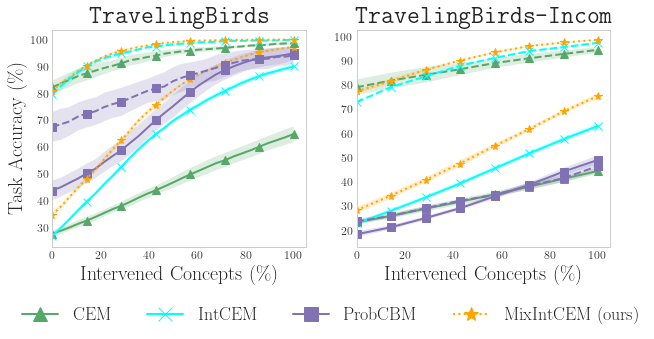

In [44]:
results_to_include = [
    dict(
        path='/anfs/bigdisc/me466/mixcem_results/travelingbirds_complete/',
        name=r'\texttt{TravelingBirds}',
    ),

    dict(
        path='/anfs/bigdisc/me466/mixcem_results/travelingbirds_incomplete/',
        name=r'\texttt{TravelingBirds-Incom}',
    ),
]
for res in results_to_include:
    res['results'] = joblib.load(os.path.join(res['path'], 'results.joblib'))

baselines_to_include = [
    "CEM",
    "IntCEM",
    "ProbCBM",
    "Entropy CMCMixIntCEM",
]

fig, axs = plt.subplots(1, len(results_to_include), figsize=(5*len(results_to_include), 4))
for col, dataset_results in enumerate(results_to_include):
    results = dataset_results['results']
    used_select_metric = dataset_results.get(
        'select_metric',
        select_metric,
    )
    dataset_results['selected_models'] = joblib.load(os.path.join(dataset_results['path'], f'selected_models_{used_select_metric}.joblib'))
    print("For dataset", dataset_results['name'], "we selected")
    for key, val in dataset_results['selected_models'].items():
        print(f"\t{key}: {val}")
    selected_models = dataset_results['selected_models']
    ax = axs[col]
    for idx, label in enumerate(baselines_to_include):
        mode_key = " (Baseline)"
        mode_name = "Baseline"
        label = dataset_results.get('rename', {}).get(label, label)
        model_name = selected_models.get(
            label + mode_key,
            label + mode_key,
        )
        ints = np.array(get_metric_from_dict(
            results,
            model_name,
            f"{ood_suffix if 'OOD' in mode_name else ''}test_acc_y_random_group_level_True_use_prior_False_ints",
        ))
        if len(ints) == 0:
            print("Skipping", model_name, "for", dataset_results['name'], "as we could not find any results...")
            continue
        label = rename_map.get(label, label)
        means = np.mean(ints, axis=0) * 100
        stds = np.std(ints, axis=0) * 100
        color = color_map.get(label, clrs[idx])
        marker = markers.get(label, "-x" if "Mix" in label else "-o")
        if dataset_results.get('intervention_freq', 1) != 1:
            freq = dataset_results.get('intervention_freq', 1)
            total_concepts = (len(means) - 1) * freq
            xticks = (
                [0] + list(100 * np.arange(1.0/total_concepts, 1, freq/total_concepts))
            )
        else:
            xticks = (
                [0] + list(100 * np.arange(1.0/(len(means) - 1), 1, 1.0/(len(means) - 1)))
            )
        if len(means) > max_limit:
            # Then let's only plot half the points to avoid clutter
            # Make the line first
            ax.plot(
                xticks,
                means,
                marker[:-1],
                color=color,
                label=label,
                markersize=8,
                linewidth=2,
            )
            # Then make all the points
            ax.plot(
                xticks[::4],
                means[::4],
                marker[-1:],
                color=color,
                label=label,
                markersize=8,
            )
        else:
            # Otherwise, plot all points
            ax.plot(
                xticks,
                means,
                marker,
                color=color,
                label=label,
                markersize=8,
                linewidth=2,
            )
        # print(mode_name, label, "means =", means)
        if show_variance:
            ax.fill_between(
                xticks,
                means - stds,
                means + stds,
                alpha=0.2,
                facecolor=color,
            )

for col, dataset_results in enumerate(results_to_include):
    results = dataset_results['results']
    used_select_metric = dataset_results.get(
        'select_metric',
        select_metric,
    )
    dataset_results['selected_models'] = joblib.load(os.path.join(dataset_results['path'], f'selected_models_{used_select_metric}.joblib'))
    print("For dataset", dataset_results['name'], "we selected")
    for key, val in dataset_results['selected_models'].items():
        print(f"\t{key}: {val}")
    selected_models = dataset_results['selected_models']
    ax = axs[col]
    for idx, label in enumerate(baselines_to_include):
        mode_key = " (Baseline)"
        mode_name = "Baseline"
        label = dataset_results.get('rename', {}).get(label, label)
        model_name = selected_models.get(
            label + mode_key,
            label + mode_key,
        )
        ints = np.array(get_metric_from_dict(
            results,
            model_name,
            f"{ood_suffix if 'OOD' in mode_name else ''}val_acc_y_random_group_level_True_use_prior_False_ints",
        ))
        if len(ints) == 0:
            print("Skipping", model_name, "for", dataset_results['name'], "as we could not find any results...")
            continue
        label = rename_map.get(label, label)
        means = np.mean(ints, axis=0) * 100
        stds = np.std(ints, axis=0) * 100
        color = color_map.get(label, clrs[idx])
        marker = markers.get(label, "-x" if "Mix" in label else "-o")
        marker = marker.replace('-', '--')
        if dataset_results.get('intervention_freq', 1) != 1:
            freq = dataset_results.get('intervention_freq', 1)
            total_concepts = (len(means) - 1) * freq
            xticks = (
                [0] + list(100 * np.arange(1.0/total_concepts, 1, freq/total_concepts))
            )
        else:
            xticks = (
                [0] + list(100 * np.arange(1.0/(len(means) - 1), 1, 1.0/(len(means) - 1)))
            )
        if len(means) > max_limit:
            # Then let's only plot half the points to avoid clutter
            # Make the line first
            ax.plot(
                xticks,
                means,
                marker[:-1],
                color=color,
                label=label,
                markersize=8,
                linewidth=2,
            )
            # Then make all the points
            ax.plot(
                xticks[::4],
                means[::4],
                marker[-1:],
                color=color,
                label=label,
                markersize=8,
            )
        else:
            # Otherwise, plot all points
            ax.plot(
                xticks,
                means,
                marker,
                color=color,
                label=label,
                markersize=8,
                linewidth=2,
            )
        # print(mode_name, label, "means =", means)
        if show_variance:
            ax.fill_between(
                xticks,
                means - stds,
                means + stds,
                alpha=0.2,
                facecolor=color,
            )
    ax.set_xlim(0, 105)
    if col == 0:
        ax.set_ylabel("Task Accuracy (\%)", fontsize=20)

    ax.set_xlabel("Intervened Concepts (\%)", fontsize=20)
    ax.xaxis.set_tick_params(labelsize=12)
    ax.yaxis.set_tick_params(labelsize=12)
    ax.set_title(dataset_results['name'], fontsize=25)
    ax.grid(False)
    handles, labels = ax.get_legend_handles_labels()
ax.legend(
    handles[:len(baselines_to_include)],
    labels[:len(baselines_to_include)],
    fontsize=18,
    loc='upper center',
    bbox_to_anchor=(-0.1,-0.2),
    ncol=4,
    markerscale=1.75,
)

plt.savefig(f"../figures/spurious_results_with_val_v2{'_variance' if show_variance else ''}.pdf", bbox_inches='tight')
plt.savefig(f"../figures/spurious_results_with_val_v2{'_variance' if show_variance else ''}.png", bbox_inches='tight')
plt.show()

### Spurious Correlations Plots Without IntCEM's Losses

For dataset \texttt{TravelingBirds} we selected
	DNN (Baseline): DNN_extra_dims_200
	Joint CBM (Baseline): CBM_Sigmoid_Baseline_cwl_1
	Joint Logit CBM (Baseline): CBM_Logit_Baseline_cwl_5
	Sequential CBM (Baseline): CBM_Seq
	Independent CBM (Baseline): CBM_Ind
	Hybrid-CBM (Baseline): Hybrid-CBM_Sigmoid_extra_dims_200_Baseline_cwl_5
	CEM (Baseline): CEM_emb_size_16_Baseline_cwl_1
	IntCEM (Baseline): IntCEM_intervention_weight_0.1_intervention_task_discount_1.1_Baseline_cwl_1
	ProbCBM (Baseline): ProbCBM_class_hidden_dim_32_hidden_dim_4_cwl_1
	Posthoc CBM (Baseline): PCBM_reg_0.1_l1_0.99_penalty_1
	Hybrid Posthoc CBM (Baseline): HybridPCBM_reg_0.1_l1_0.99_penalty_1
	Entropy CMCMixIntCEM No Calibration (Baseline): Entropy_CMCMixIntCEM_t_1_r_1_concat_None_0_mpc_1_tmc_1_emc_50_cwc_False_ce_0_g_ood_0.5_emb_16_True_tip_0.25_itd_1.1_iw_0.1_cwl_1
	Entropy CMCMixIntCEM (Baseline): Entropy_CMCMixIntCEM_t_1_r_1_concat_None_0_mpc_1_tmc_1_emc_50_cwc_False_ce_30_g_ood_0.5_emb_16_True_tip_0.25_itd_1.1

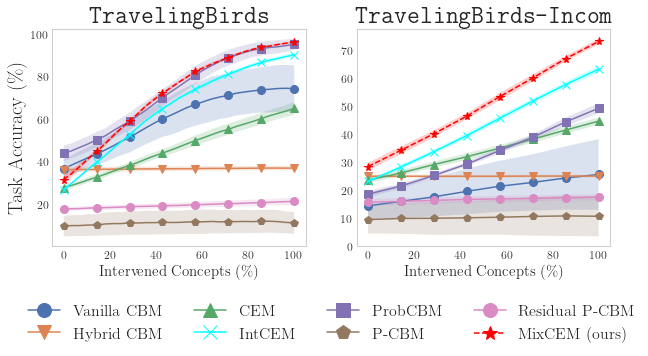

In [74]:
results_to_include = [
    dict(
        path='/anfs/bigdisc/me466/mixcem_results/travelingbirds_complete/',
        name=r'\texttt{TravelingBirds}',
    ),

    dict(
        path='/anfs/bigdisc/me466/mixcem_results/travelingbirds_incomplete/',
        name=r'\texttt{TravelingBirds-Incom}',
    ),
]
for res in results_to_include:
    res['results'] = joblib.load(os.path.join(res['path'], 'results.joblib'))

baselines_to_include = [
    "Joint CBM",
    "Hybrid-CBM",
    "CEM",
    "IntCEM",
    "ProbCBM",
    "Posthoc CBM",
    "Hybrid Posthoc CBM",
    "Entropy CMCMixCEM",
]

fig, axs = plt.subplots(1, len(results_to_include), figsize=(5*len(results_to_include), 4))
for col, dataset_results in enumerate(results_to_include):
    results = dataset_results['results']
    used_select_metric = dataset_results.get(
        'select_metric',
        select_metric,
    )
    dataset_results['selected_models'] = joblib.load(os.path.join(dataset_results['path'], f'selected_models_{used_select_metric}.joblib'))
    print("For dataset", dataset_results['name'], "we selected")
    for key, val in dataset_results['selected_models'].items():
        print(f"\t{key}: {val}")
    selected_models = dataset_results['selected_models']
    ax = axs[col]
    for idx, label in enumerate(baselines_to_include):
        mode_key = " (Baseline)"
        mode_name = "Baseline"
        label = dataset_results.get('rename', {}).get(label, label)
        model_name = selected_models.get(
            label + mode_key,
            label + mode_key,
        )
        ints = np.array(get_metric_from_dict(
            results,
            model_name,
            f"{ood_suffix if 'OOD' in mode_name else ''}test_acc_y_random_group_level_True_use_prior_False_ints",
        ))
        if len(ints) == 0:
            print("Skipping", model_name, "for", dataset_results['name'], "as we could not find any results...")
            continue
        label = used_rename_map.get(label, label)
        means = np.mean(ints, axis=0) * 100
        stds = np.std(ints, axis=0) * 100
        color = color_map.get(label, clrs[idx])
        marker = markers.get(label, "-x" if "Mix" in label else "-o")
        if dataset_results.get('intervention_freq', 1) != 1:
            freq = dataset_results.get('intervention_freq', 1)
            total_concepts = (len(means) - 1) * freq
            xticks = (
                [0] + list(100 * np.arange(1.0/total_concepts, 1, freq/total_concepts))
            )
        else:
            xticks = (
                [0] + list(100 * np.arange(1.0/(len(means) - 1), 1, 1.0/(len(means) - 1)))
            )
        if len(means) > max_limit:
            # Then let's only plot half the points to avoid clutter
            # Make the line first
            ax.plot(
                xticks,
                means,
                marker[:-1],
                color=color,
                label=label,
                markersize=8,
            )
            # Then make all the points
            ax.plot(
                xticks[::4],
                means[::4],
                marker[-1:],
                color=color,
                label=label,
                markersize=8,
            )
        else:
            # Otherwise, plot all points
            ax.plot(
                xticks,
                means,
                marker,
                color=color,
                label=label,
                markersize=8,
            )
        # print(mode_name, label, "means =", means)
        if show_variance:
            ax.fill_between(
                xticks,
                means - stds,
                means + stds,
                alpha=0.2,
                facecolor=color,
            )
    ax.set_xlim(-5, 105)
    if col == 0:
        ax.set_ylabel("Task Accuracy (\%)", fontsize=20)

    ax.set_xlabel("Intervened Concepts (\%)", fontsize=15)
    ax.xaxis.set_tick_params(labelsize=12)
    ax.yaxis.set_tick_params(labelsize=12)
    ax.set_title(dataset_results['name'], fontsize=25)
    ax.grid(False)
    handles, labels = ax.get_legend_handles_labels()
ax.legend(
    handles,
    labels,
    fontsize=16,
    loc='upper center',
    bbox_to_anchor=(-0.1,-0.2),
    ncol=4,
    markerscale=1.75,
)
plt.savefig(f"../figures/spurious_results_real_mixcem{'_variance' if show_variance else ''}.pdf", bbox_inches='tight')
plt.savefig(f"../figures/spurious_results_real_mixcem{'_variance' if show_variance else ''}.png", bbox_inches='tight')
plt.show()

For dataset \texttt{TravelingBirds-Incom} we selected
	DNN (Baseline): DNN_extra_dims_200
	Joint CBM (Baseline): CBM_Sigmoid_Baseline_cwl_1
	Joint Logit CBM (Baseline): CBM_Logit_Baseline_cwl_1
	Sequential CBM (Baseline): CBM_Seq
	Independent CBM (Baseline): CBM_Ind
	Hybrid-CBM (Baseline): Hybrid-CBM_Sigmoid_extra_dims_200_Baseline_cwl_1
	CEM (Baseline): CEM_emb_size_16_Baseline_cwl_1
	IntCEM (Baseline): IntCEM_intervention_weight_0.1_intervention_task_discount_1.5_Baseline_cwl_1
	ProbCBM (Baseline): ProbCBM_class_hidden_dim_32_hidden_dim_8_cwl_1
	Posthoc CBM (Baseline): PCBM_reg_0.1_l1_0.99_penalty_1
	Hybrid Posthoc CBM (Baseline): HybridPCBM_reg_0.001_l1_0.99_penalty_1
	Linear CMCMixIntCEM No Calibration (Baseline): Linear_CMCMixIntCEM_t_1_r_0.1_concat_None_0_mpc_1_tmc_1_emc_50_cwc_False_ce_0_g_ood_0.1_emb_16_True_tip_0.25_itd_1.1_iw_0.1_cwl_1
	Linear CMCMixIntCEM (Baseline): Linear_CMCMixIntCEM_t_1_r_1_concat_None_0_mpc_1_tmc_1_emc_50_cwc_False_ce_30_g_ood_0.1_emb_16_True_tip_0.25_i

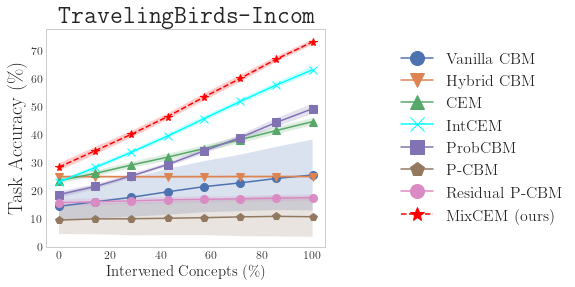

In [75]:
results_to_include = [
    dict(
        path='/anfs/bigdisc/me466/mixcem_results/travelingbirds_incomplete/',
        name=r'\texttt{TravelingBirds-Incom}',
    ),
]
for res in results_to_include:
    res['results'] = joblib.load(os.path.join(res['path'], 'results.joblib'))

baselines_to_include = [
    "Joint CBM",
    "Hybrid-CBM",
    "CEM",
    "IntCEM",
    "ProbCBM",
    "Posthoc CBM",
    "Hybrid Posthoc CBM",
    "Entropy CMCMixCEM",
]

fig, axs = plt.subplots(1, len(results_to_include), figsize=(5*len(results_to_include), 4), squeeze=False)
for col, dataset_results in enumerate(results_to_include):
    results = dataset_results['results']
    used_select_metric = dataset_results.get(
        'select_metric',
        select_metric,
    )
    dataset_results['selected_models'] = joblib.load(os.path.join(dataset_results['path'], f'selected_models_{used_select_metric}.joblib'))
    print("For dataset", dataset_results['name'], "we selected")
    for key, val in dataset_results['selected_models'].items():
        print(f"\t{key}: {val}")
    selected_models = dataset_results['selected_models']
    ax = axs[0, col]
    for idx, label in enumerate(baselines_to_include):
        mode_key = " (Baseline)"
        mode_name = "Baseline"
        label = dataset_results.get('rename', {}).get(label, label)
        model_name = selected_models.get(
            label + mode_key,
            label + mode_key,
        )
        ints = np.array(get_metric_from_dict(
            results,
            model_name,
            f"{ood_suffix if 'OOD' in mode_name else ''}test_acc_y_random_group_level_True_use_prior_False_ints",
        ))
        if len(ints) == 0:
            print("Skipping", model_name, "for", dataset_results['name'], "as we could not find any results...")
            continue
        label = used_rename_map.get(label, label)
        means = np.mean(ints, axis=0) * 100
        stds = np.std(ints, axis=0) * 100
        color = color_map.get(label, clrs[idx])
        marker = markers.get(label, "-x" if "Mix" in label else "-o")
        if dataset_results.get('intervention_freq', 1) != 1:
            freq = dataset_results.get('intervention_freq', 1)
            total_concepts = (len(means) - 1) * freq
            xticks = (
                [0] + list(100 * np.arange(1.0/total_concepts, 1, freq/total_concepts))
            )
        else:
            xticks = (
                [0] + list(100 * np.arange(1.0/(len(means) - 1), 1, 1.0/(len(means) - 1)))
            )
        if len(means) > max_limit:
            # Then let's only plot half the points to avoid clutter
            # Make the line first
            ax.plot(
                xticks,
                means,
                marker[:-1],
                color=color,
                label=label,
                markersize=8,
            )
            # Then make all the points
            ax.plot(
                xticks[::4],
                means[::4],
                marker[-1:],
                color=color,
                label=label,
                markersize=8,
            )
        else:
            # Otherwise, plot all points
            ax.plot(
                xticks,
                means,
                marker,
                color=color,
                label=label,
                markersize=8,
            )
        # print(mode_name, label, "means =", means)
        if show_variance:
            ax.fill_between(
                xticks,
                means - stds,
                means + stds,
                alpha=0.2,
                facecolor=color,
            )
    ax.set_xlim(-5, 105)
    if col == 0:
        ax.set_ylabel("Task Accuracy (\%)", fontsize=20)

    ax.set_xlabel("Intervened Concepts (\%)", fontsize=15)
    ax.xaxis.set_tick_params(labelsize=12)
    ax.yaxis.set_tick_params(labelsize=12)
    ax.set_title(dataset_results['name'], fontsize=25)
    ax.grid(False)
    handles, labels = ax.get_legend_handles_labels()
ax.legend(
    handles,
    labels,
    fontsize=16,
    loc='center right',
    bbox_to_anchor=(1.9,0.5),
    ncol=1,
    markerscale=1.75,
)
plt.savefig(f"../figures/spurious_results_incomplete_only_true_mixcem{'_variance' if show_variance else ''}.pdf", bbox_inches='tight')
plt.savefig(f"../figures/spurious_results_incomplete_only_true_mixcem{'_variance' if show_variance else ''}.png", bbox_inches='tight')
plt.show()

For dataset \texttt{TravelingBirds} we selected
	DNN (Baseline): DNN_extra_dims_200
	Joint CBM (Baseline): CBM_Sigmoid_Baseline_cwl_1
	Joint Logit CBM (Baseline): CBM_Logit_Baseline_cwl_5
	Sequential CBM (Baseline): CBM_Seq
	Independent CBM (Baseline): CBM_Ind
	Hybrid-CBM (Baseline): Hybrid-CBM_Sigmoid_extra_dims_200_Baseline_cwl_5
	CEM (Baseline): CEM_emb_size_16_Baseline_cwl_1
	IntCEM (Baseline): IntCEM_intervention_weight_0.1_intervention_task_discount_1.1_Baseline_cwl_1
	ProbCBM (Baseline): ProbCBM_class_hidden_dim_32_hidden_dim_4_cwl_1
	Posthoc CBM (Baseline): PCBM_reg_0.1_l1_0.99_penalty_1
	Hybrid Posthoc CBM (Baseline): HybridPCBM_reg_0.1_l1_0.99_penalty_1
	Entropy CMCMixIntCEM No Calibration (Baseline): Entropy_CMCMixIntCEM_t_1_r_1_concat_None_0_mpc_1_tmc_1_emc_50_cwc_False_ce_0_g_ood_0.5_emb_16_True_tip_0.25_itd_1.1_iw_0.1_cwl_1
	Entropy CMCMixIntCEM (Baseline): Entropy_CMCMixIntCEM_t_1_r_1_concat_None_0_mpc_1_tmc_1_emc_50_cwc_False_ce_30_g_ood_0.5_emb_16_True_tip_0.25_itd_1.1

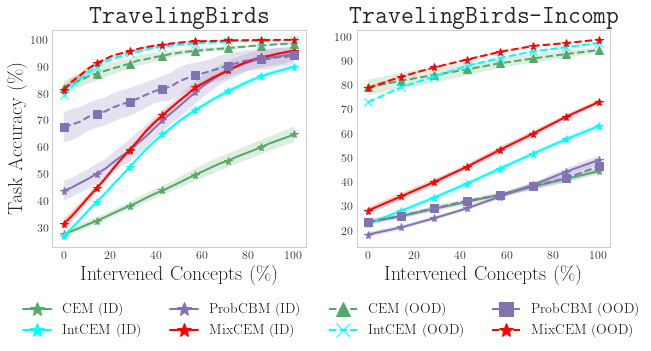

In [76]:
results_to_include = [
    dict(
        path='/anfs/bigdisc/me466/mixcem_results/travelingbirds_complete/',
        name=r'\texttt{TravelingBirds}',
    ),

    dict(
        path='/anfs/bigdisc/me466/mixcem_results/travelingbirds_incomplete/',
        name=r'\texttt{TravelingBirds-Incomp}',
    ),
]
for res in results_to_include:
    res['results'] = joblib.load(os.path.join(res['path'], 'results.joblib'))

baselines_to_include = [
    "CEM",
    "IntCEM",
    "ProbCBM",
    "Entropy CMCMixCEM",
]

fig, axs = plt.subplots(1, len(results_to_include), figsize=(5*len(results_to_include), 4))
for col, dataset_results in enumerate(results_to_include):
    results = dataset_results['results']
    used_select_metric = dataset_results.get(
        'select_metric',
        select_metric,
    )
    dataset_results['selected_models'] = joblib.load(os.path.join(dataset_results['path'], f'selected_models_{used_select_metric}.joblib'))
    print("For dataset", dataset_results['name'], "we selected")
    for key, val in dataset_results['selected_models'].items():
        print(f"\t{key}: {val}")
    selected_models = dataset_results['selected_models']
    ax = axs[col]
    for idx, label in enumerate(baselines_to_include):
        mode_key = " (Baseline)"
        mode_name = "Baseline"
        label = dataset_results.get('rename', {}).get(label, label)
        model_name = selected_models.get(
            label + mode_key,
            label + mode_key,
        )
        ints = np.array(get_metric_from_dict(
            results,
            model_name,
            f"{ood_suffix if 'OOD' in mode_name else ''}test_acc_y_random_group_level_True_use_prior_False_ints",
        ))
        if len(ints) == 0:
            print("Skipping", model_name, "for", dataset_results['name'], "as we could not find any results...")
            continue
        label = used_rename_map.get(label, label)
        means = np.mean(ints, axis=0) * 100
        stds = np.std(ints, axis=0) * 100
        color = color_map.get(label, clrs[idx])
        marker = '-' + marker[-1:]
        if dataset_results.get('intervention_freq', 1) != 1:
            freq = dataset_results.get('intervention_freq', 1)
            total_concepts = (len(means) - 1) * freq
            xticks = (
                [0] + list(100 * np.arange(1.0/total_concepts, 1, freq/total_concepts))
            )
        else:
            xticks = (
                [0] + list(100 * np.arange(1.0/(len(means) - 1), 1, 1.0/(len(means) - 1)))
            )
        if len(means) > max_limit:
            # Then let's only plot half the points to avoid clutter
            # Make the line first
            ax.plot(
                xticks,
                means,
                marker[:-1],
                color=color,
                label=label,
                markersize=8,
                linewidth=2,
            )
            # Then make all the points
            ax.plot(
                xticks[::4],
                means[::4],
                marker[-1:],
                color=color,
                label=label.replace(" (ours)", "") + " (ID)",
                markersize=8,
            )
        else:
            # Otherwise, plot all points
            ax.plot(
                xticks,
                means,
                marker,
                color=color,
                label=label.replace(" (ours)", "") + " (ID)",
                markersize=8,
                linewidth=2,
            )
        # print(mode_name, label, "means =", means)
        if show_variance:
            ax.fill_between(
                xticks,
                means - stds,
                means + stds,
                alpha=0.2,
                facecolor=color,
            )

for col, dataset_results in enumerate(results_to_include):
    results = dataset_results['results']
    used_select_metric = dataset_results.get(
        'select_metric',
        select_metric,
    )
    dataset_results['selected_models'] = joblib.load(os.path.join(dataset_results['path'], f'selected_models_{used_select_metric}.joblib'))
    print("For dataset", dataset_results['name'], "we selected")
    for key, val in dataset_results['selected_models'].items():
        print(f"\t{key}: {val}")
    selected_models = dataset_results['selected_models']
    ax = axs[col]
    for idx, label in enumerate(baselines_to_include):
        mode_key = " (Baseline)"
        mode_name = "Baseline"
        label = dataset_results.get('rename', {}).get(label, label)
        model_name = selected_models.get(
            label + mode_key,
            label + mode_key,
        )
        ints = np.array(get_metric_from_dict(
            results,
            model_name,
            f"{ood_suffix if 'OOD' in mode_name else ''}val_acc_y_random_group_level_True_use_prior_False_ints",
        ))
        if len(ints) == 0:
            print("Skipping", model_name, "for", dataset_results['name'], "as we could not find any results...")
            continue
        label = used_rename_map.get(label, label)
        means = np.mean(ints, axis=0) * 100
        stds = np.std(ints, axis=0) * 100
        color = color_map.get(label, clrs[idx])
        marker = markers.get(label, "-x" if "Mix" in label else "-o")
        marker = '--' + marker[-1:]
        if dataset_results.get('intervention_freq', 1) != 1:
            freq = dataset_results.get('intervention_freq', 1)
            total_concepts = (len(means) - 1) * freq
            xticks = (
                [0] + list(100 * np.arange(1.0/total_concepts, 1, freq/total_concepts))
            )
        else:
            xticks = (
                [0] + list(100 * np.arange(1.0/(len(means) - 1), 1, 1.0/(len(means) - 1)))
            )
        if len(means) > max_limit:
            # Then let's only plot half the points to avoid clutter
            # Make the line first
            ax.plot(
                xticks,
                means,
                marker[:-1],
                color=color,
                label=label.replace(" (ours)", "") + " (OOD)",
                markersize=8,
                linewidth=2,
            )
            # Then make all the points
            ax.plot(
                xticks[::4],
                means[::4],
                marker[-1:],
                color=color,
                label=label,
                markersize=8,
            )
        else:
            # Otherwise, plot all points
            ax.plot(
                xticks,
                means,
                marker,
                color=color,
                label=label.replace(" (ours)", "") + " (OOD)",
                markersize=8,
                linewidth=2,
            )
        # print(mode_name, label, "means =", means)
        if show_variance:
            ax.fill_between(
                xticks,
                means - stds,
                means + stds,
                alpha=0.2,
                facecolor=color,
            )
    ax.set_xlim(-5, 105)
    if col == 0:
        ax.set_ylabel("Task Accuracy (\%)", fontsize=20)

    ax.set_xlabel("Intervened Concepts (\%)", fontsize=20)
    ax.xaxis.set_tick_params(labelsize=12)
    ax.yaxis.set_tick_params(labelsize=12)
    ax.set_title(dataset_results['name'], fontsize=25)
    ax.grid(False)
    handles, labels = ax.get_legend_handles_labels()
ax.legend(
    handles,
    labels,
    fontsize=14,
    loc='upper center',
    bbox_to_anchor=(-0.1,-0.2),
    ncol=4,
    markerscale=1.75,
)

plt.savefig(f"../figures/spurious_results_with_val_true_mixcem{'_variance' if show_variance else ''}.pdf", bbox_inches='tight')
plt.savefig(f"../figures/spurious_results_with_val_true_mixcem{'_variance' if show_variance else ''}.png", bbox_inches='tight')
plt.show()

For dataset \texttt{TravelingBirds} we selected
	DNN (Baseline): DNN_extra_dims_200
	Joint CBM (Baseline): CBM_Sigmoid_Baseline_cwl_1
	Joint Logit CBM (Baseline): CBM_Logit_Baseline_cwl_5
	Sequential CBM (Baseline): CBM_Seq
	Independent CBM (Baseline): CBM_Ind
	Hybrid-CBM (Baseline): Hybrid-CBM_Sigmoid_extra_dims_200_Baseline_cwl_5
	CEM (Baseline): CEM_emb_size_16_Baseline_cwl_1
	IntCEM (Baseline): IntCEM_intervention_weight_0.1_intervention_task_discount_1.1_Baseline_cwl_1
	ProbCBM (Baseline): ProbCBM_class_hidden_dim_32_hidden_dim_4_cwl_1
	Posthoc CBM (Baseline): PCBM_reg_0.1_l1_0.99_penalty_1
	Hybrid Posthoc CBM (Baseline): HybridPCBM_reg_0.1_l1_0.99_penalty_1
	Entropy CMCMixIntCEM No Calibration (Baseline): Entropy_CMCMixIntCEM_t_1_r_1_concat_None_0_mpc_1_tmc_1_emc_50_cwc_False_ce_0_g_ood_0.5_emb_16_True_tip_0.25_itd_1.1_iw_0.1_cwl_1
	Entropy CMCMixIntCEM (Baseline): Entropy_CMCMixIntCEM_t_1_r_1_concat_None_0_mpc_1_tmc_1_emc_50_cwc_False_ce_30_g_ood_0.5_emb_16_True_tip_0.25_itd_1.1

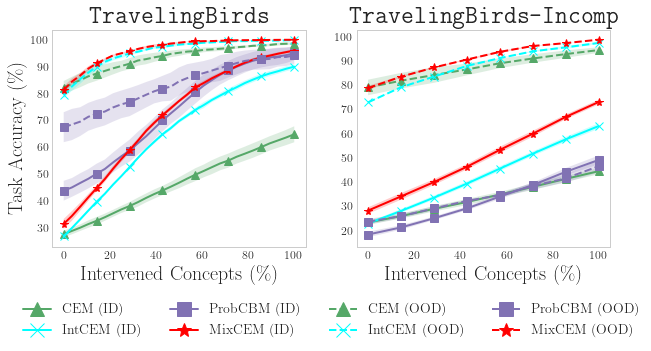

In [77]:
results_to_include = [
    dict(
        path='/anfs/bigdisc/me466/mixcem_results/travelingbirds_complete/',
        name=r'\texttt{TravelingBirds}',
    ),

    dict(
        path='/anfs/bigdisc/me466/mixcem_results/travelingbirds_incomplete/',
        name=r'\texttt{TravelingBirds-Incomp}',
    ),
]
for res in results_to_include:
    res['results'] = joblib.load(os.path.join(res['path'], 'results.joblib'))

baselines_to_include = [
    "CEM",
    "IntCEM",
    "ProbCBM",
    "Entropy CMCMixCEM",
]

fig, axs = plt.subplots(1, len(results_to_include), figsize=(5*len(results_to_include), 4))
for col, dataset_results in enumerate(results_to_include):
    results = dataset_results['results']
    used_select_metric = dataset_results.get(
        'select_metric',
        select_metric,
    )
    dataset_results['selected_models'] = joblib.load(os.path.join(dataset_results['path'], f'selected_models_{used_select_metric}.joblib'))
    print("For dataset", dataset_results['name'], "we selected")
    for key, val in dataset_results['selected_models'].items():
        print(f"\t{key}: {val}")
    selected_models = dataset_results['selected_models']
    ax = axs[col]
    for idx, label in enumerate(baselines_to_include):
        mode_key = " (Baseline)"
        mode_name = "Baseline"
        label = dataset_results.get('rename', {}).get(label, label)
        model_name = selected_models.get(
            label + mode_key,
            label + mode_key,
        )
        ints = np.array(get_metric_from_dict(
            results,
            model_name,
            f"{ood_suffix if 'OOD' in mode_name else ''}test_acc_y_random_group_level_True_use_prior_False_ints",
        ))
        if len(ints) == 0:
            print("Skipping", model_name, "for", dataset_results['name'], "as we could not find any results...")
            continue
        label = used_rename_map.get(label, label)
        means = np.mean(ints, axis=0) * 100
        stds = np.std(ints, axis=0) * 100
        color = color_map.get(label, clrs[idx])
        marker = markers.get(label, "-x" if "Mix" in label else "-o")
        marker = '-' + marker[-1:]
        if dataset_results.get('intervention_freq', 1) != 1:
            freq = dataset_results.get('intervention_freq', 1)
            total_concepts = (len(means) - 1) * freq
            xticks = (
                [0] + list(100 * np.arange(1.0/total_concepts, 1, freq/total_concepts))
            )
        else:
            xticks = (
                [0] + list(100 * np.arange(1.0/(len(means) - 1), 1, 1.0/(len(means) - 1)))
            )
        if len(means) > max_limit:
            # Then let's only plot half the points to avoid clutter
            # Make the line first
            ax.plot(
                xticks,
                means,
                marker[:-1],
                color=color,
                label=label,
                markersize=8,
                linewidth=2,
            )
            # Then make all the points
            ax.plot(
                xticks[::4],
                means[::4],
                marker[-1:],
                color=color,
                label=label.replace(" (ours)", "") + " (ID)",
                markersize=8,
            )
        else:
            # Otherwise, plot all points
            ax.plot(
                xticks,
                means,
                marker,
                color=color,
                label=label.replace(" (ours)", "") + " (ID)",
                markersize=8,
                linewidth=2,
            )
        # print(mode_name, label, "means =", means)
        if show_variance:
            ax.fill_between(
                xticks,
                means - stds,
                means + stds,
                alpha=0.2,
                facecolor=color,
            )

for col, dataset_results in enumerate(results_to_include):
    results = dataset_results['results']
    used_select_metric = dataset_results.get(
        'select_metric',
        select_metric,
    )
    dataset_results['selected_models'] = joblib.load(os.path.join(dataset_results['path'], f'selected_models_{used_select_metric}.joblib'))
    print("For dataset", dataset_results['name'], "we selected")
    for key, val in dataset_results['selected_models'].items():
        print(f"\t{key}: {val}")
    selected_models = dataset_results['selected_models']
    ax = axs[col]
    for idx, label in enumerate(baselines_to_include):
        mode_key = " (Baseline)"
        mode_name = "Baseline"
        label = dataset_results.get('rename', {}).get(label, label)
        model_name = selected_models.get(
            label + mode_key,
            label + mode_key,
        )
        ints = np.array(get_metric_from_dict(
            results,
            model_name,
            f"{ood_suffix if 'OOD' in mode_name else ''}val_acc_y_random_group_level_True_use_prior_False_ints",
        ))
        if len(ints) == 0:
            print("Skipping", model_name, "for", dataset_results['name'], "as we could not find any results...")
            continue
        label = used_rename_map.get(label, label)
        means = np.mean(ints, axis=0) * 100
        stds = np.std(ints, axis=0) * 100
        color = color_map.get(label, clrs[idx])
        marker = markers.get(label, "-x" if "Mix" in label else "-o")
        marker = '--' + marker[-1:]
        if dataset_results.get('intervention_freq', 1) != 1:
            freq = dataset_results.get('intervention_freq', 1)
            total_concepts = (len(means) - 1) * freq
            xticks = (
                [0] + list(100 * np.arange(1.0/total_concepts, 1, freq/total_concepts))
            )
        else:
            xticks = (
                [0] + list(100 * np.arange(1.0/(len(means) - 1), 1, 1.0/(len(means) - 1)))
            )
        if len(means) > max_limit:
            # Then let's only plot half the points to avoid clutter
            # Make the line first
            ax.plot(
                xticks,
                means,
                marker[:-1],
                color=color,
                label=label.replace(" (ours)", "") + " (OOD)",
                markersize=8,
                linewidth=2,
            )
            # Then make all the points
            ax.plot(
                xticks[::4],
                means[::4],
                marker[-1:],
                color=color,
                label=label,
                markersize=8,
            )
        else:
            # Otherwise, plot all points
            ax.plot(
                xticks,
                means,
                marker,
                color=color,
                label=label.replace(" (ours)", "") + " (OOD)",
                markersize=8,
                linewidth=2,
            )
        # print(mode_name, label, "means =", means)
        if show_variance:
            ax.fill_between(
                xticks,
                means - stds,
                means + stds,
                alpha=0.2,
                facecolor=color,
            )
    ax.set_xlim(-5, 105)
    if col == 0:
        ax.set_ylabel("Task Accuracy (\%)", fontsize=20)

    ax.set_xlabel("Intervened Concepts (\%)", fontsize=20)
    ax.xaxis.set_tick_params(labelsize=12)
    ax.yaxis.set_tick_params(labelsize=12)
    ax.set_title(dataset_results['name'], fontsize=25)
    ax.grid(False)
    handles, labels = ax.get_legend_handles_labels()
ax.legend(
    handles,
    labels,
    fontsize=14,
    loc='upper center',
    bbox_to_anchor=(-0.1,-0.2),
    ncol=4,
    markerscale=1.75,
)

plt.savefig(f"../figures/spurious_results_with_val_true_mixcem{'_variance' if show_variance else ''}.pdf", bbox_inches='tight')
plt.savefig(f"../figures/spurious_results_with_val_true_mixcem{'_variance' if show_variance else ''}.png", bbox_inches='tight')
plt.show()

For dataset \texttt{TravelingBirds} we selected
	DNN (Baseline): DNN_extra_dims_200
	Joint CBM (Baseline): CBM_Sigmoid_Baseline_cwl_1
	Joint Logit CBM (Baseline): CBM_Logit_Baseline_cwl_5
	Sequential CBM (Baseline): CBM_Seq
	Independent CBM (Baseline): CBM_Ind
	Hybrid-CBM (Baseline): Hybrid-CBM_Sigmoid_extra_dims_200_Baseline_cwl_5
	CEM (Baseline): CEM_emb_size_16_Baseline_cwl_1
	IntCEM (Baseline): IntCEM_intervention_weight_0.1_intervention_task_discount_1.1_Baseline_cwl_1
	ProbCBM (Baseline): ProbCBM_class_hidden_dim_32_hidden_dim_4_cwl_1
	Posthoc CBM (Baseline): PCBM_reg_0.1_l1_0.99_penalty_1
	Hybrid Posthoc CBM (Baseline): HybridPCBM_reg_0.1_l1_0.99_penalty_1
	Entropy CMCMixIntCEM No Calibration (Baseline): Entropy_CMCMixIntCEM_t_1_r_1_concat_None_0_mpc_1_tmc_1_emc_50_cwc_False_ce_0_g_ood_0.5_emb_16_True_tip_0.25_itd_1.1_iw_0.1_cwl_1
	Entropy CMCMixIntCEM (Baseline): Entropy_CMCMixIntCEM_t_1_r_1_concat_None_0_mpc_1_tmc_1_emc_50_cwc_False_ce_30_g_ood_0.5_emb_16_True_tip_0.25_itd_1.1

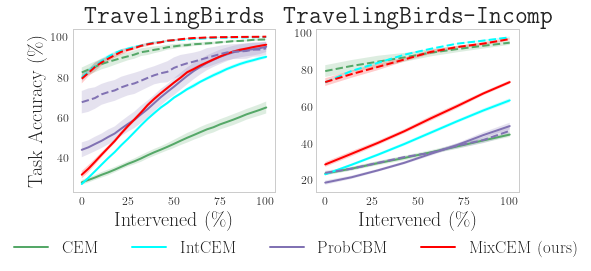

In [78]:
results_to_include = [
    dict(
        path='/anfs/bigdisc/me466/mixcem_results/travelingbirds_complete/',
        name=r'\texttt{TravelingBirds}',
    ),

    dict(
        path='/anfs/bigdisc/me466/mixcem_results/travelingbirds_incomplete/',
        name=r'\texttt{TravelingBirds-Incomp}',
    ),
]
for res in results_to_include:
    res['results'] = joblib.load(os.path.join(res['path'], 'results.joblib'))

baselines_to_include = [
    "CEM",
    "IntCEM",
    "ProbCBM",
    "Entropy CMCMixCEM",
]

fig, axs = plt.subplots(1, len(results_to_include), figsize=(4*len(results_to_include), 3))
for col, dataset_results in enumerate(results_to_include):
    results = dataset_results['results']
    used_select_metric = dataset_results.get(
        'select_metric',
        select_metric,
    )
    dataset_results['selected_models'] = joblib.load(os.path.join(dataset_results['path'], f'selected_models_{used_select_metric}.joblib'))
    print("For dataset", dataset_results['name'], "we selected")
    for key, val in dataset_results['selected_models'].items():
        print(f"\t{key}: {val}")
    selected_models = dataset_results['selected_models']
    ax = axs[col]
    for idx, label in enumerate(baselines_to_include):
        mode_key = " (Baseline)"
        mode_name = "Baseline"
        label = dataset_results.get('rename', {}).get(label, label)
        model_name = selected_models.get(
            label + mode_key,
            label + mode_key,
        )
        ints = np.array(get_metric_from_dict(
            results,
            model_name,
            f"{ood_suffix if 'OOD' in mode_name else ''}test_acc_y_random_group_level_True_use_prior_False_ints",
        ))
        if len(ints) == 0:
            print("Skipping", model_name, "for", dataset_results['name'], "as we could not find any results...")
            continue
        label = used_rename_map.get(label, label)
        means = np.mean(ints, axis=0) * 100
        stds = np.std(ints, axis=0) * 100
        color = color_map.get(label, clrs[idx])
        marker = markers.get(label, "-x" if "Mix" in label else "-o")
        marker = '-' + marker[-1:]
        if dataset_results.get('intervention_freq', 1) != 1:
            freq = dataset_results.get('intervention_freq', 1)
            total_concepts = (len(means) - 1) * freq
            xticks = (
                [0] + list(100 * np.arange(1.0/total_concepts, 1, freq/total_concepts))
            )
        else:
            xticks = (
                [0] + list(100 * np.arange(1.0/(len(means) - 1), 1, 1.0/(len(means) - 1)))
            )
        if len(means) > max_limit:
            # Then let's only plot half the points to avoid clutter
            # Make the line first
            ax.plot(
                xticks,
                means,
                marker[:-1],
                color=color,
                label=label,
                markersize=8,
                linewidth=2,
            )
            # # Then make all the points
            # ax.plot(
            #     xticks[::4],
            #     means[::4],
            #     marker[-1:],
            #     color=color,
            #     label=label,
            #     markersize=8,
            # )
        else:
            # Otherwise, plot all points
            ax.plot(
                xticks,
                means,
                marker[:-1],
                color=color,
                label=label,
                markersize=8,
                linewidth=2,
            )
        # print(mode_name, label, "means =", means)
        if show_variance:
            ax.fill_between(
                xticks,
                means - stds,
                means + stds,
                alpha=0.2,
                facecolor=color,
            )

for col, dataset_results in enumerate(results_to_include):
    results = dataset_results['results']
    used_select_metric = dataset_results.get(
        'select_metric',
        select_metric,
    )
    dataset_results['selected_models'] = joblib.load(os.path.join(dataset_results['path'], f'selected_models_{used_select_metric}.joblib'))
    print("For dataset", dataset_results['name'], "we selected")
    for key, val in dataset_results['selected_models'].items():
        print(f"\t{key}: {val}")
    selected_models = dataset_results['selected_models']
    ax = axs[col]
    for idx, label in enumerate(baselines_to_include):
        mode_key = " (Baseline)"
        mode_name = "Baseline"
        label = dataset_results.get('rename', {}).get(label, label)
        model_name = selected_models.get(
            label + mode_key,
            label + mode_key,
        )
        if 'MixCEM' in label:
            # Then for the validation accuracy, we will use that of the
            # uncalibrated model, as otherwise it is not a fair comparison
            ints = np.array(get_metric_from_dict(
                results,
                selected_models.get(
                    "Entropy CMCMixCEM No Calibration" + mode_key,
                    "Entropy CMCMixCEM No Calibration" + mode_key,
                ),
                f"{ood_suffix if 'OOD' in mode_name else ''}val_acc_y_random_group_level_True_use_prior_False_ints",
            ))
        else:
            ints = np.array(get_metric_from_dict(
                results,
                model_name,
                f"{ood_suffix if 'OOD' in mode_name else ''}val_acc_y_random_group_level_True_use_prior_False_ints",
            ))
        if len(ints) == 0:
            print("Skipping", model_name, "for", dataset_results['name'], "as we could not find any results...")
            continue
        label = used_rename_map.get(label, label)
        means = np.mean(ints, axis=0) * 100
        stds = np.std(ints, axis=0) * 100
        color = color_map.get(label, clrs[idx])
        marker = markers.get(label, "-x" if "Mix" in label else "-o")
        marker = '--' + marker[-1:]
        if dataset_results.get('intervention_freq', 1) != 1:
            freq = dataset_results.get('intervention_freq', 1)
            total_concepts = (len(means) - 1) * freq
            xticks = (
                [0] + list(100 * np.arange(1.0/total_concepts, 1, freq/total_concepts))
            )
        else:
            xticks = (
                [0] + list(100 * np.arange(1.0/(len(means) - 1), 1, 1.0/(len(means) - 1)))
            )
        if len(means) > max_limit:
            # Then let's only plot half the points to avoid clutter
            # Make the line first
            ax.plot(
                xticks,
                means,
                marker[:-1],
                color=color,
                label=label,
                markersize=8,
                linewidth=2,
            )
            # # Then make all the points
            # ax.plot(
            #     xticks[::4],
            #     means[::4],
            #     marker[-1:],
            #     color=color,
            #     label=label,
            #     markersize=8,
            # )
        else:
            # Otherwise, plot all points
            ax.plot(
                xticks,
                means,
                marker[:-1],
                color=color,
                label=label,
                markersize=8,
                linewidth=2,
            )
        # print(mode_name, label, "means =", means)
        if show_variance:
            ax.fill_between(
                xticks,
                means - stds,
                means + stds,
                alpha=0.2,
                facecolor=color,
            )
    ax.set_xlim(-5, 105)
    if col == 0:
        ax.set_ylabel("Task Accuracy (\%)", fontsize=20)

    ax.set_xlabel("Intervened (\%)", fontsize=20)
    ax.xaxis.set_tick_params(labelsize=12)
    ax.yaxis.set_tick_params(labelsize=12)
    ax.set_title(dataset_results['name'], fontsize=25)
    ax.grid(False)
    handles, labels = ax.get_legend_handles_labels()
ax.legend(
    handles[:len(baselines_to_include)],
    labels[:len(baselines_to_include)],
    fontsize=17,
    loc='upper center',
    bbox_to_anchor=(-0.1,-0.2),
    ncol=4,
    markerscale=1.75,
)

plt.savefig(f"../figures/spurious_results_with_val_v2_true_mixcem{'_variance' if show_variance else ''}.pdf", bbox_inches='tight')
plt.savefig(f"../figures/spurious_results_with_val_v2_true_mixcem{'_variance' if show_variance else ''}.png", bbox_inches='tight')
plt.show()

For dataset \texttt{TravelingBirds} we selected
	DNN (Baseline): DNN_extra_dims_200
	Joint CBM (Baseline): CBM_Sigmoid_Baseline_cwl_1
	Joint Logit CBM (Baseline): CBM_Logit_Baseline_cwl_5
	Sequential CBM (Baseline): CBM_Seq
	Independent CBM (Baseline): CBM_Ind
	Hybrid-CBM (Baseline): Hybrid-CBM_Sigmoid_extra_dims_200_Baseline_cwl_5
	CEM (Baseline): CEM_emb_size_16_Baseline_cwl_1
	IntCEM (Baseline): IntCEM_intervention_weight_0.1_intervention_task_discount_1.1_Baseline_cwl_1
	ProbCBM (Baseline): ProbCBM_class_hidden_dim_32_hidden_dim_4_cwl_1
	Posthoc CBM (Baseline): PCBM_reg_0.1_l1_0.99_penalty_1
	Hybrid Posthoc CBM (Baseline): HybridPCBM_reg_0.1_l1_0.99_penalty_1
	Entropy CMCMixIntCEM No Calibration (Baseline): Entropy_CMCMixIntCEM_t_1_r_1_concat_None_0_mpc_1_tmc_1_emc_50_cwc_False_ce_0_g_ood_0.5_emb_16_True_tip_0.25_itd_1.1_iw_0.1_cwl_1
	Entropy CMCMixIntCEM (Baseline): Entropy_CMCMixIntCEM_t_1_r_1_concat_None_0_mpc_1_tmc_1_emc_50_cwc_False_ce_30_g_ood_0.5_emb_16_True_tip_0.25_itd_1.1

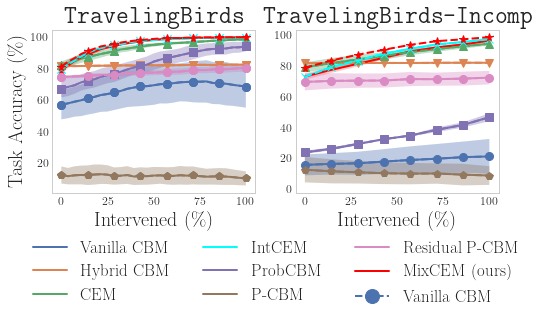

In [79]:
results_to_include = [
    dict(
        path='/anfs/bigdisc/me466/mixcem_results/travelingbirds_complete/',
        name=r'\texttt{TravelingBirds}',
    ),

    dict(
        path='/anfs/bigdisc/me466/mixcem_results/travelingbirds_incomplete/',
        name=r'\texttt{TravelingBirds-Incomp}',
    ),
]
for res in results_to_include:
    res['results'] = joblib.load(os.path.join(res['path'], 'results.joblib'))

baselines_to_include = [
    "Joint CBM",
    "Hybrid-CBM",
    "CEM",
    "IntCEM",
    "ProbCBM",
    "Posthoc CBM",
    "Hybrid Posthoc CBM",
    "Entropy CMCMixCEM",
    "Bayes MLP",
]

fig, axs = plt.subplots(1, len(results_to_include), figsize=(4*len(results_to_include), 3))
for col, dataset_results in enumerate(results_to_include):
    results = dataset_results['results']
    used_select_metric = dataset_results.get(
        'select_metric',
        select_metric,
    )
    dataset_results['selected_models'] = joblib.load(os.path.join(dataset_results['path'], f'selected_models_{used_select_metric}.joblib'))
    print("For dataset", dataset_results['name'], "we selected")
    for key, val in dataset_results['selected_models'].items():
        print(f"\t{key}: {val}")
    selected_models = dataset_results['selected_models']
    ax = axs[col]
    for idx, label in enumerate(baselines_to_include):
        mode_key = " (Baseline)"
        mode_name = "Baseline"
        label = dataset_results.get('rename', {}).get(label, label)
        model_name = selected_models.get(
            label + mode_key,
            label + mode_key,
        )
        if 'MixCEM' in label:
            # Then for the validation accuracy, we will use that of the
            # uncalibrated model, as otherwise it is not a fair comparison
            ints = np.array(get_metric_from_dict(
                results,
                selected_models.get(
                    "Entropy CMCMixCEM No Calibration" + mode_key,
                    "Entropy CMCMixCEM No Calibration" + mode_key,
                ),
                f"{ood_suffix if 'OOD' in mode_name else ''}val_acc_y_random_group_level_True_use_prior_False_ints",
            ))
        else:
            ints = np.array(get_metric_from_dict(
                results,
                model_name,
                f"{ood_suffix if 'OOD' in mode_name else ''}val_acc_y_random_group_level_True_use_prior_False_ints",
            ))
        if len(ints) == 0:
            print("Skipping", model_name, "for", dataset_results['name'], "as we could not find any results...")
            continue
        label = used_rename_map.get(label, label)
        means = np.mean(ints, axis=0) * 100
        stds = np.std(ints, axis=0) * 100
        color = color_map.get(label, clrs[idx])
        marker = markers.get(label, "-x" if "Mix" in label else "-o")
        marker = '-' + marker[-1:]
        if dataset_results.get('intervention_freq', 1) != 1:
            freq = dataset_results.get('intervention_freq', 1)
            total_concepts = (len(means) - 1) * freq
            xticks = (
                [0] + list(100 * np.arange(1.0/total_concepts, 1, freq/total_concepts))
            )
        else:
            xticks = (
                [0] + list(100 * np.arange(1.0/(len(means) - 1), 1, 1.0/(len(means) - 1)))
            )
        if len(means) > max_limit:
            # Then let's only plot half the points to avoid clutter
            # Make the line first
            ax.plot(
                xticks,
                means,
                marker[:-1],
                color=color,
                label=label,
                markersize=8,
                linewidth=2,
            )
            # Then make all the points
            ax.plot(
                xticks[::4],
                means[::4],
                marker[-1:],
                color=color,
                label=label,
                markersize=8,
            )
        else:
            # Otherwise, plot all points
            ax.plot(
                xticks,
                means,
                marker[:-1],
                color=color,
                label=label,
                markersize=8,
                linewidth=2,
            )
        # print(mode_name, label, "means =", means)
        if show_variance:
            ax.fill_between(
                xticks,
                means - stds,
                means + stds,
                alpha=0.2,
                facecolor=color,
            )

for col, dataset_results in enumerate(results_to_include):
    results = dataset_results['results']
    used_select_metric = dataset_results.get(
        'select_metric',
        select_metric,
    )
    dataset_results['selected_models'] = joblib.load(os.path.join(dataset_results['path'], f'selected_models_{used_select_metric}.joblib'))
    print("For dataset", dataset_results['name'], "we selected")
    for key, val in dataset_results['selected_models'].items():
        print(f"\t{key}: {val}")
    selected_models = dataset_results['selected_models']
    ax = axs[col]
    for idx, label in enumerate(baselines_to_include):
        mode_key = " (Baseline)"
        mode_name = "Baseline"
        label = dataset_results.get('rename', {}).get(label, label)
        model_name = selected_models.get(
            label + mode_key,
            label + mode_key,
        )
        ints = np.array(get_metric_from_dict(
            results,
            model_name,
            f"{ood_suffix if 'OOD' in mode_name else ''}val_acc_y_random_group_level_True_use_prior_False_ints",
        ))
        if len(ints) == 0:
            print("Skipping", model_name, "for", dataset_results['name'], "as we could not find any results...")
            continue
        label = used_rename_map.get(label, label)
        means = np.mean(ints, axis=0) * 100
        stds = np.std(ints, axis=0) * 100
        color = color_map.get(label, clrs[idx])
        marker = markers.get(label, "-x" if "Mix" in label else "-o")
        marker = '--' + marker[-1:]
        if dataset_results.get('intervention_freq', 1) != 1:
            freq = dataset_results.get('intervention_freq', 1)
            total_concepts = (len(means) - 1) * freq
            xticks = (
                [0] + list(100 * np.arange(1.0/total_concepts, 1, freq/total_concepts))
            )
        else:
            xticks = (
                [0] + list(100 * np.arange(1.0/(len(means) - 1), 1, 1.0/(len(means) - 1)))
            )
        if len(means) > max_limit:
            # Then let's only plot half the points to avoid clutter
            # Make the line first
            ax.plot(
                xticks,
                means,
                marker[:-1],
                color=color,
                label=label,
                markersize=8,
                linewidth=2,
            )
            # Then make all the points
            ax.plot(
                xticks[::4],
                means[::4],
                marker[-1:],
                color=color,
                label=label,
                markersize=8,
            )
        else:
            # Otherwise, plot all points
            ax.plot(
                xticks,
                means,
                marker,
                color=color,
                label=label,
                markersize=8,
                linewidth=2,
            )
        # print(mode_name, label, "means =", means)
        if show_variance:
            ax.fill_between(
                xticks,
                means - stds,
                means + stds,
                alpha=0.2,
                facecolor=color,
            )
    ax.set_xlim(-5, 105)
    if col == 0:
        ax.set_ylabel("Task Accuracy (\%)", fontsize=20)

    ax.set_xlabel("Intervened (\%)", fontsize=20)
    ax.xaxis.set_tick_params(labelsize=12)
    ax.yaxis.set_tick_params(labelsize=12)
    ax.set_title(dataset_results['name'], fontsize=25)
    ax.grid(False)
    handles, labels = ax.get_legend_handles_labels()

ax.legend(
    handles[:len(baselines_to_include)],
    labels[:len(baselines_to_include)],
    fontsize=17,
    loc='upper center',
    bbox_to_anchor=(-0.1,-0.2),
    ncol=3,
    markerscale=1.75,
)

plt.savefig(f"../figures/spurious_results_with_val_v2_true_mixcem_complete{'_variance' if show_variance else ''}.pdf", bbox_inches='tight')
plt.savefig(f"../figures/spurious_results_with_val_v2_true_mixcem_complete{'_variance' if show_variance else ''}.png", bbox_inches='tight')
plt.show()

For dataset \texttt{TravelingBirds} we selected
	DNN (Baseline): DNN_extra_dims_200
	Joint CBM (Baseline): CBM_Sigmoid_Baseline_cwl_1
	Joint Logit CBM (Baseline): CBM_Logit_Baseline_cwl_5
	Sequential CBM (Baseline): CBM_Seq
	Independent CBM (Baseline): CBM_Ind
	Hybrid-CBM (Baseline): Hybrid-CBM_Sigmoid_extra_dims_200_Baseline_cwl_5
	CEM (Baseline): CEM_emb_size_16_Baseline_cwl_1
	IntCEM (Baseline): IntCEM_intervention_weight_0.1_intervention_task_discount_1.1_Baseline_cwl_1
	ProbCBM (Baseline): ProbCBM_class_hidden_dim_32_hidden_dim_4_cwl_1
	Posthoc CBM (Baseline): PCBM_reg_0.1_l1_0.99_penalty_1
	Hybrid Posthoc CBM (Baseline): HybridPCBM_reg_0.1_l1_0.99_penalty_1
	Entropy CMCMixIntCEM No Calibration (Baseline): Entropy_CMCMixIntCEM_t_1_r_1_concat_None_0_mpc_1_tmc_1_emc_50_cwc_False_ce_0_g_ood_0.5_emb_16_True_tip_0.25_itd_1.1_iw_0.1_cwl_1
	Entropy CMCMixIntCEM (Baseline): Entropy_CMCMixIntCEM_t_1_r_1_concat_None_0_mpc_1_tmc_1_emc_50_cwc_False_ce_30_g_ood_0.5_emb_16_True_tip_0.25_itd_1.1

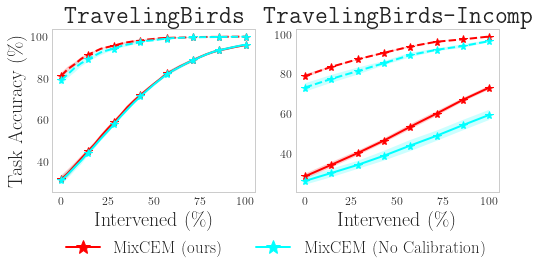

In [80]:
results_to_include = [
    dict(
        path='/anfs/bigdisc/me466/mixcem_results/travelingbirds_complete/',
        name=r'\texttt{TravelingBirds}',
    ),

    dict(
        path='/anfs/bigdisc/me466/mixcem_results/travelingbirds_incomplete/',
        name=r'\texttt{TravelingBirds-Incomp}',
    ),
]
for res in results_to_include:
    res['results'] = joblib.load(os.path.join(res['path'], 'results.joblib'))

baselines_to_include = [
    # "Joint CBM",
    # "Hybrid-CBM",
    # "CEM",
    # "IntCEM",
    # "ProbCBM",
    # "Posthoc CBM",
    # "Hybrid Posthoc CBM",
    "Entropy CMCMixCEM",
    "Entropy CMCMixCEM No Calibration",
    # "Bayes MLP",
]

fig, axs = plt.subplots(1, len(results_to_include), figsize=(4*len(results_to_include), 3))
for col, dataset_results in enumerate(results_to_include):
    results = dataset_results['results']
    used_select_metric = dataset_results.get(
        'select_metric',
        select_metric,
    )
    dataset_results['selected_models'] = joblib.load(os.path.join(dataset_results['path'], f'selected_models_{used_select_metric}.joblib'))
    print("For dataset", dataset_results['name'], "we selected")
    for key, val in dataset_results['selected_models'].items():
        print(f"\t{key}: {val}")
    selected_models = dataset_results['selected_models']
    ax = axs[col]
    for idx, label in enumerate(baselines_to_include):
        mode_key = " (Baseline)"
        mode_name = "Baseline"
        label = dataset_results.get('rename', {}).get(label, label)
        model_name = selected_models.get(
            label + mode_key,
            label + mode_key,
        )
        ints = np.array(get_metric_from_dict(
            results,
            model_name,
            f"{ood_suffix if 'OOD' in mode_name else ''}test_acc_y_random_group_level_True_use_prior_False_ints",
        ))
        if len(ints) == 0:
            print("Skipping", model_name, "for", dataset_results['name'], "as we could not find any results...")
            continue
        label = used_rename_map.get(label, label)
        means = np.mean(ints, axis=0) * 100
        stds = np.std(ints, axis=0) * 100
        color = color_map.get(label, clrs[idx])
        marker = markers.get(label, "-x" if "Mix" in label else "-o")
        marker = '-' + marker[-1:]
        if dataset_results.get('intervention_freq', 1) != 1:
            freq = dataset_results.get('intervention_freq', 1)
            total_concepts = (len(means) - 1) * freq
            xticks = (
                [0] + list(100 * np.arange(1.0/total_concepts, 1, freq/total_concepts))
            )
        else:
            xticks = (
                [0] + list(100 * np.arange(1.0/(len(means) - 1), 1, 1.0/(len(means) - 1)))
            )
        if len(means) > max_limit:
            # Then let's only plot half the points to avoid clutter
            # Make the line first
            ax.plot(
                xticks,
                means,
                marker[:-1],
                color=color,
                label=label,
                markersize=8,
                linewidth=2,
            )
            # Then make all the points
            ax.plot(
                xticks[::4],
                means[::4],
                marker[-1:],
                color=color,
                label=label,
                markersize=8,
            )
        else:
            # Otherwise, plot all points
            ax.plot(
                xticks,
                means,
                marker,
                color=color,
                label=label,
                markersize=8,
                linewidth=2,
            )
        # print(mode_name, label, "means =", means)
        if show_variance:
            ax.fill_between(
                xticks,
                means - stds,
                means + stds,
                alpha=0.2,
                facecolor=color,
            )

for col, dataset_results in enumerate(results_to_include):
    results = dataset_results['results']
    used_select_metric = dataset_results.get(
        'select_metric',
        select_metric,
    )
    dataset_results['selected_models'] = joblib.load(os.path.join(dataset_results['path'], f'selected_models_{used_select_metric}.joblib'))
    print("For dataset", dataset_results['name'], "we selected")
    for key, val in dataset_results['selected_models'].items():
        print(f"\t{key}: {val}")
    selected_models = dataset_results['selected_models']
    ax = axs[col]
    for idx, label in enumerate(baselines_to_include):
        mode_key = " (Baseline)"
        mode_name = "Baseline"
        label = dataset_results.get('rename', {}).get(label, label)
        model_name = selected_models.get(
            label + mode_key,
            label + mode_key,
        )
        ints = np.array(get_metric_from_dict(
            results,
            model_name,
            f"{ood_suffix if 'OOD' in mode_name else ''}val_acc_y_random_group_level_True_use_prior_False_ints",
        ))
        if len(ints) == 0:
            print("Skipping", model_name, "for", dataset_results['name'], "as we could not find any results...")
            continue
        label = used_rename_map.get(label, label)
        means = np.mean(ints, axis=0) * 100
        stds = np.std(ints, axis=0) * 100
        color = color_map.get(label, clrs[idx])
        marker = markers.get(label, "-x" if "Mix" in label else "-o")
        marker = '--' + marker[-1:]
        if dataset_results.get('intervention_freq', 1) != 1:
            freq = dataset_results.get('intervention_freq', 1)
            total_concepts = (len(means) - 1) * freq
            xticks = (
                [0] + list(100 * np.arange(1.0/total_concepts, 1, freq/total_concepts))
            )
        else:
            xticks = (
                [0] + list(100 * np.arange(1.0/(len(means) - 1), 1, 1.0/(len(means) - 1)))
            )
        if len(means) > max_limit:
            # Then let's only plot half the points to avoid clutter
            # Make the line first
            ax.plot(
                xticks,
                means,
                marker[:-1],
                color=color,
                label=label,
                markersize=8,
                linewidth=2,
            )
            # Then make all the points
            ax.plot(
                xticks[::4],
                means[::4],
                marker[-1:],
                color=color,
                label=label,
                markersize=8,
            )
        else:
            # Otherwise, plot all points
            ax.plot(
                xticks,
                means,
                marker,
                color=color,
                label=label,
                markersize=8,
                linewidth=2,
            )
        # print(mode_name, label, "means =", means)
        if show_variance:
            ax.fill_between(
                xticks,
                means - stds,
                means + stds,
                alpha=0.2,
                facecolor=color,
            )
    ax.set_xlim(-5, 105)
    if col == 0:
        ax.set_ylabel("Task Accuracy (\%)", fontsize=20)

    ax.set_xlabel("Intervened (\%)", fontsize=20)
    ax.xaxis.set_tick_params(labelsize=12)
    ax.yaxis.set_tick_params(labelsize=12)
    ax.set_title(dataset_results['name'], fontsize=25)
    ax.grid(False)
    handles, labels = ax.get_legend_handles_labels()

ax.legend(
    handles[:len(baselines_to_include)],
    labels[:len(baselines_to_include)],
    fontsize=17,
    loc='upper center',
    bbox_to_anchor=(-0.1,-0.2),
    ncol=3,
    markerscale=1.75,
)

plt.show()

# Sandbox

In [39]:
CONCEPT_SEMANTICS_SENTENCE_TEST = [
    "a bird with a dagger bill",
    "a bird with am all-purpose bill",
    "a bird with brown wings",
    "a bird with dark black wings",
    "a bird with white wings",
    "a brown bird",
    "a dark black bird",
    "a white bird",
]

IDXs = [
    1,
    6,
    10,
    20,
    21,
    249,
    259,
    260,
]


CONCEPT_SEMANTICS_NEGATION_TEST = [
    "a bird with a bill",
    "a bird with a bill",
    "bird wings",
    "bird wings",
    "bird wings",
    "a bird",
    "a bird",
    "a bird",
]

In [1]:
import os
import numpy as np
import pandas as pd

def attr_line_to_val(line):
    return int(line.split(" ")[2])

def get_sample_attributes(idx, lines):
    return np.array([
        attr_line_to_val(lines[x]) for x in range((idx - 1) * 312, idx * 312)
    ])
    
root_dir = "/anfs/bigdisc/me466/waterbirds"
cub_root_dir = "/homes/me466/data/CUB200/"
metadata_df = pd.read_csv(
    os.path.join(root_dir, 'metadata.csv')
)
image_true_idx = metadata_df['img_id'].values
with open(
    os.path.join(
        cub_root_dir,
        'CUB_200_2011/attributes/image_attribute_labels.txt',
    ),
    'r',
) as f:
    lines = [x.rstrip() for x in f]
attributes = np.array([
    get_sample_attributes(idx, lines) for idx in image_true_idx
])

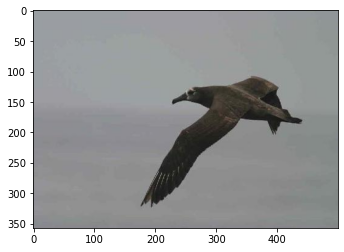

test_img_idx = 24
Processing 'blue wings' and 'wings without any blue' with similarities tensor([[0.8990]]) (between them), tensor([[0.2409]]) (pos emb), tensor([[0.2383]]) (neg emb)
contrastive probs scale of correct label 0 = tensor(0.4474)
cosine similarity probs of correct label 0 = 0.43520424
Processing 'brown wings' and 'wings without any brown' with similarities tensor([[0.9139]]) (between them), tensor([[0.2669]]) (pos emb), tensor([[0.2432]]) (neg emb)
contrastive probs scale of correct label 1 = tensor(0.8744)
cosine similarity probs of correct label 1 = 0.91435295
Processing 'yellow wings' and 'wings without any yellow' with similarities tensor([[0.8826]]) (between them), tensor([[0.2224]]) (pos emb), tensor([[0.2376]]) (neg emb)
contrastive probs scale of correct label 0 = tensor(0.7730)
cosine similarity probs of correct label 0 = 0.8205849
Processing 'green wings' and 'wings without any green' with similarities tensor([[0.8679]]) (between them), tensor([[0.2405]]) (pos em

In [53]:
import torch
import clip
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

from cem.data.cub_loader import CONCEPT_SEMANTICS_SENTENCE, CONCEPT_SEMANTICS_NEGATION
device = "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)
img_selected = "001.Black_footed_Albatross/Black_Footed_Albatross_0008_796083.jpg" #"027.Shiny_Cowbird/Shiny_Cowbird_0007_24434.jpg"
im = Image.open(f"/homes/me466/data/CUB200/CUB_200_2011/images/{img_selected}")
plt.imshow(im)
plt.show()
test_img = preprocess(im).unsqueeze(0).to(device)
with open('/homes/me466/data/CUB200/CUB_200_2011/images.txt', 'r') as f:
    img_names = [x.rstrip().split(" ")[-1] for x in f]
test_img_idx = img_names.index(img_selected)
print("test_img_idx =", test_img_idx)
test_img_emb = model.encode_image(test_img)
test_img_emb = test_img_emb / test_img_emb.norm(dim=1, keepdim=True)
test_img_attrs = attributes[test_img_idx, :]
embeddings = []
with torch.no_grad():
    for idx, (pos_descr, neg_descr) in enumerate(zip(CONCEPT_SEMANTICS_SENTENCE, CONCEPT_SEMANTICS_NEGATION)):
        # idx = IDXs[idx]
        pos_text = clip.tokenize([pos_descr]).to(device)
        pos_emb = model.encode_text(pos_text)
        pos_emb = pos_emb / pos_emb.norm(dim=1, keepdim=True)
        neg_text = clip.tokenize([neg_descr]).to(device)
        neg_emb = model.encode_text(neg_text)
        neg_emb = neg_emb / neg_emb.norm(dim=1, keepdim=True)

        score_pos = (pos_emb - test_img_emb).pow(2).sum(-1).sqrt()
        score_neg = (neg_emb - test_img_emb).pow(2).sum(-1).sqrt()
        # probs = torch.sigmoid(
        #     score_neg - score_pos
        # )
        # probs = [1-probs, probs]
        # print("contrastive probs =", probs)
        
        cont_probs = torch.sigmoid(
            100 * (score_neg - score_pos)
        )
        cont_probs = [1-cont_probs, cont_probs]

        score_pos = pos_emb @ test_img_emb.t()
        score_neg = neg_emb @ test_img_emb.t()
        cos_probs = (model.logit_scale.exp() * torch.concat([score_neg, score_pos], dim=0)).softmax(dim=0).cpu().numpy()
        print(f"Processing '{pos_descr}' and '{neg_descr}' with similarities {pos_emb @ neg_emb.t()} (between them), {score_pos} (pos emb), {score_neg} (neg emb)")
        print(f"contrastive probs scale of correct label {test_img_attrs[idx]} =", cont_probs[test_img_attrs[idx]][0])
        print(f"cosine similarity probs of correct label {test_img_attrs[idx]} =", cos_probs[test_img_attrs[idx], 0])
        # probs = (torch.concat([score_neg, score_pos], dim=0)).softmax(dim=0)
        # print("cosine similarity probs no scale =", probs)
        
        embeddings.append((pos_emb, neg_emb))
embs = np.array([
    np.concatenate(x, axis=0)
    for x in embeddings
])

In [37]:
with open('../cub_ViT-B_32_concept_embeddings.npy', 'wb') as f:
    np.save(f, embs)

In [51]:
import torch
import clip
from PIL import Image

device = 'cpu'
model, preprocess = clip.load("ViT-B/32", device=device)
if not os.path.exists('/homes/me466/data/CUB200/CUB_200_2011/clip_ViT-B_32_embeddings'):
    os.makedirs('/homes/me466/data/CUB200/CUB_200_2011/clip_ViT-B_32_embeddings')
count = 0
for subdir, dirs, files in os.walk('/homes/me466/data/CUB200/CUB_200_2011/images/'):
    for file in files:
        if not file.endswith(".jpg"):
            continue
        count += 1

current_count = 0
batch_size = 512
current_batch = []
for subdir, dirs, files in os.walk('/homes/me466/data/CUB200/CUB_200_2011/images/'):
    for file in files:
        if not file.endswith(".jpg"):
            continue
        image_filename = os.path.join(subdir, file)
        dirname = os.path.dirname(image_filename)
        emb_directory = dirname.replace('/images/', '/clip_ViT-B_32_embeddings/')
        if not os.path.exists(emb_directory):
            os.makedirs(emb_directory)

        emb_filename = os.path.join(emb_directory, file.replace('jpg', 'npy'))
        image = preprocess(Image.open(image_filename)).unsqueeze(0).to(device)
        current_batch.append((image, emb_filename))
        if len(current_batch) == batch_size:
            print("Flushing the batch!")
            # Then time to fush the batch!
            with torch.no_grad():
                batch_of_images = torch.cat([x[0] for x in current_batch], axis=0)
                image_features = model.encode_image(batch_of_images)
                for idx, (_, current_file_name) in enumerate(current_batch):
                    print(f"\tSaving image {idx + 1}/{batch_size}")
                    with open(current_file_name, 'wb') as f:
                        np.save(f, image_features[idx, :])
            current_batch = []
        print(f"[{100 * current_count/count:.2f}%] Saving embedding for", image_filename, "to", emb_filename)
        current_count += 1


[0.00%] Saving embedding for /homes/me466/data/CUB200/CUB_200_2011/images/005.Crested_Auklet/Crested_Auklet_0001_794941.jpg to /homes/me466/data/CUB200/CUB_200_2011/clip_ViT-B_32_embeddings/005.Crested_Auklet/Crested_Auklet_0001_794941.npy
[0.01%] Saving embedding for /homes/me466/data/CUB200/CUB_200_2011/images/005.Crested_Auklet/Crested_Auklet_0029_1824.jpg to /homes/me466/data/CUB200/CUB_200_2011/clip_ViT-B_32_embeddings/005.Crested_Auklet/Crested_Auklet_0029_1824.npy
[0.02%] Saving embedding for /homes/me466/data/CUB200/CUB_200_2011/images/005.Crested_Auklet/Crested_Auklet_0074_794949.jpg to /homes/me466/data/CUB200/CUB_200_2011/clip_ViT-B_32_embeddings/005.Crested_Auklet/Crested_Auklet_0074_794949.npy
[0.03%] Saving embedding for /homes/me466/data/CUB200/CUB_200_2011/images/005.Crested_Auklet/Crested_Auklet_0045_794940.jpg to /homes/me466/data/CUB200/CUB_200_2011/clip_ViT-B_32_embeddings/005.Crested_Auklet/Crested_Auklet_0045_794940.npy
[0.03%] Saving embedding for /homes/me466/da

KeyboardInterrupt: 